# Exploratory Data Analysis (EDA) on House Prices Dataset

## Introduction

In this project, we will perform **Exploratory Data Analysis (EDA)** on the **House Prices: Advanced Regression Techniques** dataset from Kaggle. The goal of EDA is to understand the dataset by examining its structure, cleaning the data, and visualizing key features. This process will help us uncover important patterns and relationships in the data, and provide insights into which features might be useful for predictive modeling in future steps.

We will follow these 7 key steps throughout the analysis:

### Steps of the EDA Process

todo: these steps should be updated

1. **Understanding the Data**: This includes looking at the data types of various columns, understanding what each column represents, and identifying any key columns.
2. **Summary Statistics**: Calculating basic statistics like mean, median, mode, standard deviation, and range for numerical columns.
3. **Data Cleaning**: Identifying and handling missing values, outliers, and any inconsistencies in the data.
4. **Data Visualization**: Creating visualizations such as histograms, box plots, scatter plots, and correlation matrices to get a sense of the distributions, relationships, and patterns in the data.
5. **Feature Engineering**: Creating new features or modifying existing ones to better capture the underlying patterns in the data.
6. **Identifying Trends and Patterns**: Using the summary statistics and visualizations to identify any obvious trends, patterns, or anomalies in the data.
7. **Initial Hypothesis Testing**: Formulating and testing initial hypotheses about the data based on the observations from the EDA.

---

Let's begin by loading all the required modules and the dataset and reviewing its structure.

In [37]:
import pandas as pd
import numpy as np
import pprint

In [38]:
df = pd.read_csv('../data/train.csv')
print(df.shape)

(1460, 81)


## Understanding the Data
In the first step of our Exploratory Data Analysis (EDA), we'll begin by examining the structure of the dataset and familiarizing ourselves with the information it provides. This involves inspecting the first few rows to understand the general layout, including the columns and their data types.
Additionally, we have helpful documentation (data_description.txt) available in the data folder that explains the meaning of each column. In real-world scenarios, this file would typically be produced after extensive exploration and collaboration with business stakeholders to gain a thorough understanding of each feature. For this project, I’ve reformatted the content of the data description into a data frame to make it easier to reference and work with. As we progress through the analysis, we will continue adding features to this data frame to enhance our understanding of the dataset.

In [39]:
def parse_data_description_to_dict(file_path):
    field_dict = {}
    current_field = None
    description = ''
    valid_options = {}

    with open(file_path, 'r') as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        line = lines[i].rstrip('\n')

        # Skip empty lines
        if not line.strip():
            i += 1
            continue

        # Detect a new field (line does not start with space)
        if not line.startswith(' '):
            # Save the previous field's data
            if current_field:
                field_dict[current_field] = {
                    'Description': description.strip(),
                    'Valid Options': valid_options if valid_options else None
                }

            # Start parsing a new field
            # The line contains the field name and description
            # Field name and description are separated by a colon ':', if present
            if ':' in line:
                parts = line.split(':', 1)
                current_field = parts[0].strip()
                description = parts[1].strip()
            else:
                current_field = line.strip()
                description = ''
            valid_options = {}
            i += 1
        else:
            # Indented lines
            # Check for option lines starting with exactly 7 spaces
            if line.startswith('       '):  # 7 spaces
                option_line = line.strip()

                # Split the option code and its description
                if '\t' in option_line:
                    option_parts = option_line.split('\t', 1)
                else:
                    option_parts = option_line.split(None, 1)

                if len(option_parts) == 2:
                    code, desc = option_parts
                    valid_options[code.strip()] = desc.strip()
                else:
                    # Handle lines that are continuation of the description
                    description += ' ' + option_line.strip()
                i += 1
            else:
                # Lines with indentation but not exactly 7 spaces
                # May be continuation of description
                description += ' ' + line.strip()
                i += 1

    # Save data for the last field
    if current_field:
        field_dict[current_field] = {
            'Description': description.strip(),
            'Valid Options': valid_options if valid_options else None
        }

    return field_dict



# Example usage:
file_path = '../data/data_description.txt'  # Replace with your actual file path
data_description_dict = parse_data_description_to_dict(file_path)

# Print a field with options to verify
# print(data_description_dict)
import pprint
pprint.pprint(data_description_dict)

# Access specific features of a field
print("Description:", data_description_dict['Exterior1st']['Description'])
print("Valid Options:", data_description_dict['Exterior1st']['Valid Options'])

{'1stFlrSF': {'Description': 'First Floor square feet', 'Valid Options': None},
 '2ndFlrSF': {'Description': 'Second floor square feet', 'Valid Options': None},
 '3SsnPorch': {'Description': 'Three season porch area in square feet',
               'Valid Options': None},
 'Alley': {'Description': 'Type of alley access to property',
           'Valid Options': {'Grvl': 'Gravel',
                             'NA': 'No alley access',
                             'Pave': 'Paved'}},
 'Bedroom': {'Description': 'Bedrooms above grade (does NOT include basement '
                            'bedrooms)',
             'Valid Options': None},
 'BldgType': {'Description': 'Type of dwelling',
              'Valid Options': {'1Fam': 'Single-family Detached',
                                '2FmCon': 'Two-family Conversion; originally '
                                          'built as one-family dwelling',
                                'Duplx': 'Duplex',
                                'TwnhsE':

lets make sure fields in this dict are the same as actual dataset fields:

In [40]:
# Extract the field names from the data_description_dict
description_fields = set(data_description_dict.keys())

# Extract the column names from the DataFrame
df_fields = set(df.columns)

# Find fields that are in data_description_dict but not in df
in_description_not_df = description_fields - df_fields

# Find fields that are in df but not in data_description_dict
in_df_not_description = df_fields - description_fields

# Print the discrepancies
if in_description_not_df:
    print("Fields in data_description_dict but not in DataFrame:")
    for field in in_description_not_df:
        print(f"- {field}")
else:
    print("All fields in data_description_dict are present in the DataFrame.")

if in_df_not_description:
    print("\nFields in DataFrame but not in data_description_dict:")
    for field in in_df_not_description:
        print(f"- {field}")
else:
    print("All fields in the DataFrame are present in data_description_dict.")


Fields in data_description_dict but not in DataFrame:
- Kitchen
- Bedroom

Fields in DataFrame but not in data_description_dict:
- SalePrice
- BedroomAbvGr
- KitchenAbvGr
- Id


aside from Id and SalePrice, seems like we have a name discrepency for 2 columns. based on the descriptn these are the same with different names so I change them to KitchenAbvGr and BedroomAbvGr in the description dictionalry to solve this:

In [41]:
if 'Bedroom' in data_description_dict:
    data_description_dict['BedroomAbvGr'] = data_description_dict.pop('Bedroom')

if 'Kitchen' in data_description_dict:
    data_description_dict['KitchenAbvGr'] = data_description_dict.pop('Kitchen')


print(data_description_dict['BedroomAbvGr'])  # Verify the renamed Bedroom field
print(data_description_dict['KitchenAbvGr'])  # Verify the renamed Kitchen field

{'Description': 'Bedrooms above grade (does NOT include basement bedrooms)', 'Valid Options': None}
{'Description': 'Kitchens above grade', 'Valid Options': None}


In [42]:
def compare_valid_options(data_description_dict, df):
    """
    Compare 'Valid Options' in the data description dictionary with the actual 
    unique values in the dataset and report discrepancies.

    Parameters:
        data_description_dict (dict): A dictionary containing feature descriptions and valid options.
        df (pd.DataFrame): The dataset to validate against.

    Returns:
        pd.DataFrame: A summary of discrepancies for each feature with valid options.
    """
    discrepancies = []

    for feature, details in data_description_dict.items():
        # Skip features without valid options
        valid_options = details.get('Valid Options')
        if valid_options is None:
            continue
        
        # Get unique values from the dataset
        actual_values = set(df[feature].dropna().unique())
        valid_values = set(valid_options.keys())
        
        # Find discrepancies
        missing_in_data = valid_values - actual_values  # Valid options not in data
        extra_in_data = actual_values - valid_values  # Data values not in valid options

        if missing_in_data or extra_in_data:
            discrepancies.append({
                'Feature': feature,
                'Missing in Data': missing_in_data if missing_in_data else None,
                'Extra in Data': extra_in_data if extra_in_data else None
            })

    # Convert discrepancies to a DataFrame
    return pd.DataFrame(discrepancies)

discrepancy_summary = compare_valid_options(data_description_dict, df)

# Configure Pandas to display all columns fully
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

display(discrepancy_summary)


Feature                                                        Missing in Data                                                     Extra in Data
0     MSSubClass  {45, 190, 160, 150, 70, 80, 40, 75, 85, 20, 60, 90, 120, 30, 180, 50}  {160, 70, 40, 75, 45, 190, 80, 50, 20, 85, 180, 120, 90, 60, 30}
1       MSZoning                                                          {RP, A, C, I}                                                         {C (all)}
2          Alley                                                                   {NA}                                                              None
3      Utilities                                                          {ELO, NoSewr}                                                              None
4   Neighborhood                                                                {Names}                                                           {NAmes}
5     Condition2                                                                 {RRNe}                                                              None
6       BldgType                                                {Duplx, TwnhsI, 2FmCon}                                           {2fmCon, Twnhs, Duplex}
7    OverallQual                                        {1, 7, 2, 6, 8, 3, 10, 4, 5, 9}                                   {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
8    OverallCond                                        {1, 7, 2, 6, 8, 3, 10, 4, 5, 9}                                       {1, 2, 3, 4, 5, 6, 7, 8, 9}
9    Exterior1st                                                       {Other, PreCast}                                                              None
10   Exterior2nd                                   {WdShing, BrkComm, CemntBd, PreCast}                                       {CmentBd, Brk Cmn, Wd Shng}
11    MasVnrType                                                         {CBlock, None}                                                              None
12     ExterQual                                                                   {Po}                                                              None
13      BsmtQual                                                               {NA, Po}                                                              None
14      BsmtCond                                                               {Ex, NA}                                                              None
15  BsmtExposure                                                                   {NA}                                                              None
16  BsmtFinType1                                                                   {NA}                                                              None
17  BsmtFinType2                                                                   {NA}                                                              None
18   KitchenQual                                                                   {Po}                                                              None
19    Functional                                                                  {Sal}                                                              None
20   FireplaceQu                                                                   {NA}                                                              None
21    GarageType                                                                   {NA}                                                              None
22  GarageFinish                                                                   {NA}                                                              None
23    GarageQual                                                                   {NA}                                                              None
24    GarageCond                                                                   {NA}                                                              None
25   

In [43]:
#changes in the data_description_dict:

# MSZoning: Add 'C (all)' to valid options
data_description_dict['MSZoning']['Valid Options']['C (all)'] = 'C (all)'

# Neighborhood: Replace 'Names' with 'NAmes' in valid options
if 'Names' in data_description_dict['Neighborhood']['Valid Options']:
    data_description_dict['Neighborhood']['Valid Options']['NAmes'] = data_description_dict['Neighborhood']['Valid Options'].pop('Names')

# BldgType: Replace '2FmCon' with '2fmCon' and 'Duplx' with 'Duplex', add 'Twnhs' to valid options
valid_options = data_description_dict['BldgType']['Valid Options']
if '2FmCon' in valid_options:
    valid_options['2fmCon'] = valid_options.pop('2FmCon')
if 'Duplx' in valid_options:
    valid_options['Duplex'] = valid_options.pop('Duplx')
valid_options['Twnhs'] = 'Townhouse'

# Update valid options for OverallQual to integers
data_description_dict['OverallQual']['Valid Options'] = {
    int(k): v for k, v in data_description_dict['OverallQual']['Valid Options'].items()
}

# Update valid options for OverallCond to integers
data_description_dict['OverallCond']['Valid Options'] = {
    int(k): v for k, v in data_description_dict['OverallCond']['Valid Options'].items()
}

# Exterior2nd: Replace 'CemntBd' with 'CmentBd', 'BrkComm' with 'Brk Cmn', 'WdShing' with 'Wd Shng'
valid_options = data_description_dict['Exterior2nd']['Valid Options']
if 'CemntBd' in valid_options:
    valid_options['CmentBd'] = valid_options.pop('CemntBd')
if 'BrkComm' in valid_options:
    valid_options['Brk Cmn'] = valid_options.pop('BrkComm')
if 'WdShing' in valid_options:
    valid_options['Wd Shng'] = valid_options.pop('WdShing')


In [44]:
discrepancy_summary = compare_valid_options(data_description_dict, df)

# Configure Pandas to display all columns fully
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

display(discrepancy_summary)

Feature                                                        Missing in Data                                                     Extra in Data
0     MSSubClass  {45, 190, 160, 150, 70, 80, 40, 75, 85, 20, 60, 90, 120, 30, 180, 50}  {160, 70, 40, 75, 45, 190, 80, 50, 20, 85, 180, 120, 90, 60, 30}
1       MSZoning                                                          {RP, A, C, I}                                                              None
2          Alley                                                                   {NA}                                                              None
3      Utilities                                                          {ELO, NoSewr}                                                              None
4     Condition2                                                                 {RRNe}                                                              None
5       BldgType                                                               {TwnhsI}                                                              None
6    OverallCond                                                                   {10}                                                              None
7    Exterior1st                                                       {Other, PreCast}                                                              None
8    Exterior2nd                                                              {PreCast}                                                              None
9     MasVnrType                                                         {CBlock, None}                                                              None
10     ExterQual                                                                   {Po}                                                              None
11      BsmtQual                                                               {NA, Po}                                                              None
12      BsmtCond                                                               {Ex, NA}                                                              None
13  BsmtExposure                                                                   {NA}                                                              None
14  BsmtFinType1                                                                   {NA}                                                              None
15  BsmtFinType2                                                                   {NA}                                                              None
16   KitchenQual                                                                   {Po}                                                              None
17    Functional                                                                  {Sal}                                                              None
18   FireplaceQu                                                                   {NA}                                                              None
19    GarageType                                                                   {NA}                                                              None
20  GarageFinish                                                                   {NA}                                                              None
21    GarageQual                                                                   {NA}                                                              None
22    GarageCond                                                                   {NA}                                                              None
23        PoolQC                                                               {NA, TA}                                                              None
24         Fence                                                                   {NA}                                                              None
25   

Now there is only descrepencies that should be addressed in the data and I will take care of them in feature engineering section.

### Feature Types Dictionary

Now that we have a data_description.txt file for this data, we can define a **feature_types** dictionary that categorizes each feature (column) in the dataset into one of several feature types. These types help us understand the nature of the data and guide how we should handle each feature during Exploratory Data Analysis (EDA) and machine learning (ML) preprocessing. The feature types include:

- **Continuous**: Numeric values that can take any value within a range (e.g., `LotArea`, `GrLivArea`).
- **Ordinal**: Categorical variables with a meaningful order (e.g., `OverallQual`, `ExterQual`).
- **Nominal**: Categorical variables without a meaningful order (e.g., `BldgType`, `Neighborhood`).
- **Boolean**: Binary values (Yes/No, 0/1) (e.g., `CentralAir`, `PavedDrive`).
- **Cyclic**: Variables that repeat in a cycle, such as months or days (e.g., `MoSold`).
- **Temporal**: Date or time-related features (e.g., `YearBuilt`, `YrSold`).

|**Feature Type**|**Description**|**Example in Dataset**|**EDA Handling**|**ML Handling**|
|-|-|-|-|-|
| **Continuous (Numerical)**  | Numerical values that can take any value within a range.                         | `LotArea`, `SalePrice`         | - Summary statistics (mean, median, std) <br> - Histograms <br> - Box plots <br> - Detect outliers               | - Normalize or standardize <br> - Handle outliers (capping, removal)                                      |
| **Ordinal (Ordered)**       | Categorical values with a meaningful order or ranking.                          | `OverallQual`, `ExterQual`     | - Mode and frequency distribution <br> - Bar plots                                                                | - Ordinal encoding <br> - Optional normalization (depending on the algorithm)                             |
| **Nominal (Unordered)**     | Categorical values with no inherent order or ranking.                           | `BldgType`, `Neighborhood`     | - Bar plots <br> - Pie charts                                                                                     | - One-hot encoding <br> - Target encoding (for high cardinality categories)                               |
| **Temporal (Date/Time)**    | Date or time-related features that can be decomposed into components.           | `YearBuilt`, `YrSold`          | - Extract components (year, month) <br> - Time series plots <br> - Trends over time                               | - Feature engineering (e.g., years since built) <br> - Cyclic encoding for months (sine/cosine)           |
| **Boolean (Binary)**        | Features with only two possible values, usually `0/1` or `True/False`.           | `CentralAir`, `PavedDrive`     | - Bar plots for distribution <br> - Count analysis                                                                | - Remain as binary <br> - No further encoding needed                                                      |
| **High Cardinality**        | Categorical features with a large number of distinct values.                     | `Neighborhood` (if many values)| - Frequency distribution <br> - Bar plots                                                                         | - Target encoding <br> - Frequency encoding                                                               |
| **Cyclic Features**         | Features where the values repeat in a cycle (e.g., days, months).                | `MoSold`                       | - Time series plots <br> - Histograms or bar plots                                                                | - Cyclic encoding using sine and cosine transformation     

### Purpose of the Feature Types Dictionary

The **feature_types** dictionary provides a structured way to understand how each column should be treated. This categorization is crucial because different types of features require different handling in both EDA and ML:

1. **EDA (Exploratory Data Analysis)**:
   - Continuous features should be analyzed using summary statistics like mean, median, standard deviation, and visualized using histograms and box plots.
   - Ordinal features can be visualized using bar plots to understand how the data is distributed across the ordered categories.
   - Nominal features can also be visualized with bar plots, but since they have no inherent order, the analysis should focus on frequency counts.
   - Boolean features (binary) can be analyzed through bar plots and summary statistics like the ratio of `True`/`False` or `0`/`1`.
   - Temporal features often need to be decomposed into components (e.g., extracting the year or calculating the number of years since a specific event), while cyclic features like `MoSold` can be analyzed as periodic patterns (e.g., through sine and cosine transformations).

2. **Machine Learning Preprocessing**:
   - **Continuous features**: These often require **normalization** (scaling to a range of 0-1) or **standardization** (scaling to a mean of 0 and standard deviation of 1) before being used in models.
   - **Ordinal features**: Should be **ordinally encoded**, converting categories into integer values based on their order (e.g., 1 = Poor, 2 = Fair, 3 = Good, etc.).
   - **Nominal features**: Should be transformed using **one-hot encoding**, where each category is converted into a binary feature, or **target encoding** in cases where high cardinality is present.
   - **Boolean features**: Usually remain binary (`0`/`1`), though some algorithms may require them to be encoded as `True`/`False` or similar.
   - **Cyclic features**: Should be encoded using **sine and cosine transformations** to represent their cyclical nature, especially in machine learning algorithms that may not handle cyclical data well.
   - **Temporal features**: Often require additional **feature engineering**, such as calculating the time since a specific event (e.g., years since the house was built) or converting date information into components (e.g., year, month).

By maintaining this **feature_types** dictionary, we can streamline and automate many of the preprocessing tasks that would otherwise be manual and error-prone. This dictionary allows us to:
- Apply different transformations (e.g., normalization, encoding) based on feature type.
- Easily refer to the feature types for visualizing and analyzing the data.
- Simplify the process of building machine learning pipelines by automatically selecting the correct preprocessing steps for each feature type.

This will ensure that our EDA and machine learning models are both **efficient** and **effective**, tailored to the specific types of data we are working with.


In [45]:
feature_types = {
    'MSSubClass': 'nominal',          # Type of dwelling (ordered categories)
    'MSZoning': 'nominal',            # General zoning classification
    'LotFrontage': 'continuous',      # Linear feet of street connected to property
    'LotArea': 'continuous',          # Lot size in square feet
    'Street': 'nominal',              # Type of road access to property
    'Alley': 'nominal',               # Type of alley access
    'LotShape': 'ordinal',            # General shape of property (ordered by regularity)
    'LandContour': 'ordinal',         # Flatness of the property
    'Utilities': 'nominal',           # Type of utilities available
    'LotConfig': 'ordinal',           # Lot configuration
    'LandSlope': 'ordinal',           # Slope of property (ordered by severity)
    'Neighborhood': 'nominal',        # Physical locations within Ames city limits
    'Condition1': 'nominal',          # Proximity to various conditions
    'Condition2': 'nominal',          # Proximity to various conditions (if more than one is present)
    'BldgType': 'nominal',            # Type of dwelling
    'HouseStyle': 'nominal',          # Style of dwelling
    'OverallQual': 'ordinal',         # Rates the overall material and finish of the house (1 to 10)
    'OverallCond': 'ordinal',         # Rates the overall condition of the house (1 to 10)
    'YearBuilt': 'temporal',          # Original construction date
    'YearRemodAdd': 'temporal',       # Remodel date
    'RoofStyle': 'nominal',           # Type of roof
    'RoofMatl': 'nominal',            # Roof material
    'Exterior1st': 'nominal',         # Exterior covering on house
    'Exterior2nd': 'nominal',         # Exterior covering on house (if more than one material)
    'MasVnrType': 'nominal',          # Masonry veneer type
    'MasVnrArea': 'continuous',       # Masonry veneer area in square feet
    'ExterQual': 'ordinal',           # Evaluates the quality of the material on the exterior
    'ExterCond': 'ordinal',           # Evaluates the present condition of the material on the exterior
    'Foundation': 'nominal',          # Type of foundation
    'BsmtQual': 'ordinal',            # Evaluates the height of the basement
    'BsmtCond': 'ordinal',            # Evaluates the general condition of the basement
    'BsmtExposure': 'ordinal',        # Refers to walkout or garden level walls
    'BsmtFinType1': 'ordinal',        # Rating of basement finished area
    'BsmtFinSF1': 'continuous',       # Type 1 finished square feet in basement
    'BsmtFinType2': 'ordinal',        # Rating of basement finished area (if multiple types)
    'BsmtFinSF2': 'continuous',       # Type 2 finished square feet in basement
    'BsmtUnfSF': 'continuous',        # Unfinished square feet of basement area
    'TotalBsmtSF': 'continuous',      # Total square feet of basement area
    'Heating': 'nominal',             # Type of heating
    'HeatingQC': 'ordinal',           # Heating quality and condition
    'CentralAir': 'boolean',          # Central air conditioning (Y/N)
    'Electrical': 'nominal',          # Electrical system
    '1stFlrSF': 'continuous',         # First floor square feet
    '2ndFlrSF': 'continuous',         # Second floor square feet
    'LowQualFinSF': 'continuous',     # Low quality finished square feet (all floors)
    'GrLivArea': 'continuous',        # Above grade (ground) living area square feet
    'BsmtFullBath': 'continuous',     # Basement full bathrooms
    'BsmtHalfBath': 'continuous',     # Basement half bathrooms
    'FullBath': 'continuous',         # Full bathrooms above grade
    'HalfBath': 'continuous',         # Half baths above grade
    'BedroomAbvGr': 'continuous',     # Bedrooms above grade
    'KitchenAbvGr': 'continuous',     # Kitchens above grade
    'KitchenQual': 'ordinal',         # Kitchen quality
    'TotRmsAbvGrd': 'continuous',     # Total rooms above grade (does not include bathrooms)
    'Functional': 'ordinal',          # Home functionality (ordered)
    'Fireplaces': 'continuous',       # Number of fireplaces
    'FireplaceQu': 'ordinal',         # Fireplace quality
    'GarageType': 'nominal',          # Garage location
    'GarageYrBlt': 'temporal',        # Year garage was built
    'GarageFinish': 'ordinal',        # Interior finish of the garage
    'GarageCars': 'continuous',       # Size of garage in car capacity
    'GarageArea': 'continuous',       # Size of garage in square feet
    'GarageQual': 'ordinal',          # Garage quality
    'GarageCond': 'ordinal',          # Garage condition
    'PavedDrive': 'boolean',          # Paved driveway (Y/N)
    'WoodDeckSF': 'continuous',       # Wood deck area in square feet
    'OpenPorchSF': 'continuous',      # Open porch area in square feet
    'EnclosedPorch': 'continuous',    # Enclosed porch area in square feet
    '3SsnPorch': 'continuous',        # Three season porch area in square feet
    'ScreenPorch': 'continuous',      # Screen porch area in square feet
    'PoolArea': 'continuous',         # Pool area in square feet
    'PoolQC': 'ordinal',              # Pool quality
    'Fence': 'nominal',               # Fence quality
    'MiscFeature': 'nominal',         # Miscellaneous feature not covered in other categories
    'MiscVal': 'continuous',          # $Value of miscellaneous feature
    'MoSold': 'cyclic',               # Month Sold (cyclic, as months repeat)
    'YrSold': 'temporal',             # Year Sold
    'SaleType': 'nominal',            # Type of sale
    'SaleCondition': 'nominal'        # Condition of sale
}


lets add these to the data_description_dict

In [46]:
for field, feature_type in feature_types.items():
    # Check if the field exists in data_description_dict
    if field in data_description_dict:
        # Add the feature type to the corresponding field's dictionary
        data_description_dict[field]['Feature Type'] = feature_type
    else:
        print(f"Warning: {field} not found in data_description_dict")

In [47]:
print(list(data_description_dict.items())[:5])

[('MSSubClass', {'Description': 'Identifies the type of dwelling involved in the sale.', 'Valid Options': {'20': '1-STORY 1946 & NEWER ALL STYLES', '30': '1-STORY 1945 & OLDER', '40': '1-STORY W/FINISHED ATTIC ALL AGES', '45': '1-1/2 STORY - UNFINISHED ALL AGES', '50': '1-1/2 STORY FINISHED ALL AGES', '60': '2-STORY 1946 & NEWER', '70': '2-STORY 1945 & OLDER', '75': '2-1/2 STORY ALL AGES', '80': 'SPLIT OR MULTI-LEVEL', '85': 'SPLIT FOYER', '90': 'DUPLEX - ALL STYLES AND AGES', '120': '1-STORY PUD (Planned Unit Development) - 1946 & NEWER', '150': '1-1/2 STORY PUD - ALL AGES', '160': '2-STORY PUD - 1946 & NEWER', '180': 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER', '190': '2 FAMILY CONVERSION - ALL STYLES AND AGES'}, 'Feature Type': 'nominal'}), ('MSZoning', {'Description': 'Identifies the general zoning classification of the sale.', 'Valid Options': {'A': 'Agriculture', 'C': 'Commercial', 'FV': 'Floating Village Residential', 'I': 'Industrial', 'RH': 'Residential High Density', 'RL': 'Res

----

before we decide what to do with the missing values in each column it will help to visualize the data in each column based on the feature type.

### feature-by-feature Analysis
lets look into features one by one

#### Visualization Functions

In [48]:
def plot_pie(column, df):
    """
    Creates a plot with a pie chart and its legend for the given column in the dataframe.
    Args:
        column (str): The column to visualize.
        df (DataFrame): The dataframe containing the data.
    Returns:
        None: Displays the plot.
    """
    # Prepare data for pie chart
    category_counts = df[column].value_counts()
    missing_count = df[column].isna().sum()
    
    # Combine data for categories and missing values
    labels = list(category_counts.index)
    sizes = list(category_counts.values)
    colors = sns.color_palette("cool", len(labels))
    if missing_count > 0:
        labels.append('Missing')
        sizes.append(missing_count)
        colors.append('red')  # Add red color for missing values

    percentages = (np.array(sizes) / sum(sizes)) * 100  # Calculate percentages
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1]})
    
    # Pie chart
    def autopct_format(pct):
        return f'{pct:.1f}%' if pct >= 4 else ''  # Show percentage if >= 4%
    
    wedges, texts, autotexts = axes[0].pie(
        sizes,
        autopct=autopct_format,
        startangle=90,
        colors=colors,
        textprops={'fontsize': 10},
    )
    axes[0].set_title(f'Percentage Distribution of {column} (Including Missing)')
    axes[0].axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
    
    # Legend
    axes[1].axis('off')  # Turn off the axes for the legend area
    axes[1].legend(
        handles=wedges,
        labels=[f"{label}: {size} ({percent:.1f}%)" for label, size, percent in zip(labels, sizes, percentages)],
        loc="center left",
        fontsize=10,
        title=f"{column} Categories"
    )
    
    plt.tight_layout()
    plt.show()

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to visualize continuous features
def visualize_continuous(column, df):
    # Calculations
    min_value = df[column].min()
    max_value = df[column].max()
    mean_value = df[column].mean()
    
    plt.figure(figsize=(12, 8))
    
    # Histogram
    plt.subplot(2, 2, 1)
    sns.histplot(df[column].dropna(), kde=True, bins=30)
    plt.title(f'Histogram of {column}')
    
    # Boxplot
    plt.subplot(2, 2, 2)
    sns.boxplot(x=df[column].dropna())
    plt.title(f'Boxplot of {column}')
    
    # Strip Plot
    plt.subplot(2, 2, 3)
    sns.stripplot(x=df[column], jitter=True)
    plt.title(f'Strip Plot of {column}')
    plt.xlabel(column)
    # Plot vertical lines for min, max, and mean
    plt.axvline(min_value, color='red', linestyle='--', label=f'Min: {min_value}')
    plt.axvline(max_value, color='green', linestyle='--', label=f'Max: {max_value}')
    plt.axvline(mean_value, color='blue', linestyle='-', label=f'Avg: {mean_value:.2f}')
    
    # Scatter Plot with SalePrice
    plt.subplot(2, 2, 4)
    sns.scatterplot(x=df[column], y=df['SalePrice'], alpha=0.7)
    plt.title(f'Scatter Plot of {column} vs SalePrice')
    plt.xlabel(column)
    plt.ylabel('SalePrice')
    
    plt.tight_layout()
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


# # Function to visualize categorical features ('ordinal', 'nominal', 'boolean', 'cyclic')
# def visualize_categorical(column, df):

#     # sorted categories for box plot
#     median_prices = df.groupby(column)['SalePrice'].median().sort_values()
#     sorted_categories = median_prices.index  # Categories sorted by mean SalePrice

#     # Visualization
#     plt.figure(figsize=(12, 10))
    
#     # Bar plot
#     plt.subplot(2, 2, 1)
#     sns.countplot(x=column, data=df, order=sorted(df[column].dropna().unique()))
#     plt.title(f'Count Plot of {column}')
#     plt.xlabel(column)
#     plt.ylabel('Count')

#     # Box plot
#     plt.subplot(2, 2, 2)
#     sns.boxplot(x=column, y='SalePrice', data=df, order=sorted_categories)
#     plt.title(f'SalePrice Distribution by {column}')
#     plt.xlabel(column)
#     plt.ylabel('SalePrice')

#     # Pie chart
#     # Prepare data for pie chart
#     category_counts = df[column].value_counts()
#     missing_count = df[column].isna().sum()
    
#     # Combine data for categories and missing values
#     labels = list(category_counts.index)
#     sizes = list(category_counts.values)
#     colors = sns.color_palette("cool", len(labels))
#     if missing_count > 0:
#         labels.append('Missing')
#         sizes.append(missing_count)
#         colors.append('red')  # Add red color for missing values

#     percentages = (np.array(sizes) / sum(sizes)) * 100  # Calculate percentages
    
#     plt.subplot(2, 2, 3)

#     # Define a function to format percentages conditionally
#     def autopct_format(pct):
#         return f'{pct:.1f}%' if pct >= 4 else ''  # Show percentage if >= 4%

#     wedges, texts, autotexts = plt.pie(
#         sizes,
#         autopct=autopct_format,
#         startangle=90,
#         colors=colors,
#         textprops={'fontsize': 10},
#     )
#     plt.title(f'Percentage Distribution of {column} (Including Missing)')
#     plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.

#     # Legend in the 4th spot
#     plt.subplot(2, 2, 4)
#     plt.axis('off')  # Turn off the axes for the legend area
#     plt.legend(
#         handles=wedges,
#         labels=[f"{label}: {size} ({percent:.1f}%)" for label, size, percent in zip(labels, sizes, percentages)],
#         loc="center",
#         fontsize=10,
#         title=f"{column} Categories"
#     )

#     plt.tight_layout()
#     plt.show()

# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

def visualize_categorical(column, df):
    """
    Visualizes a categorical column with a count plot, box plot, pie chart, and legend.
    Args:
        column (str): The column to visualize.
        df (DataFrame): The dataframe containing the data.
    Returns:
        None: Displays the plots.
    """
    # sorted categories for box plot
    median_prices = df.groupby(column)['SalePrice'].median().sort_values()
    sorted_categories = median_prices.index  # Categories sorted by mean SalePrice

    # Visualization
    plt.figure(figsize=(12, 4))
    
    # Bar plot
    plt.subplot(1, 2, 1)
    sns.countplot(x=column, data=df, order=sorted(df[column].dropna().unique()))
    plt.title(f'Count Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

    # Box plot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=column, y='SalePrice', data=df, order=sorted_categories)
    plt.title(f'SalePrice Distribution by {column}')
    plt.xlabel(column)
    plt.ylabel('SalePrice')

    # Pie chart and legend
    plot_pie(column, df)



# Function to visualize nominal features
def visualize_nominal(column, df):
    plt.figure(figsize=(10, 4))
    
    # Bar plot for categories
    sns.countplot(x=column, data=df)
    plt.title(f'Count Plot of {column}')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Function to visualize boolean features
def visualize_boolean(column, df):
    plt.figure(figsize=(6, 4))
    
    # Bar plot for binary features
    sns.countplot(x=column, data=df)
    plt.title(f'Count Plot of {column}')
    plt.show()

# Function to visualize cyclic features (like months)
def visualize_cyclic(column, df):
    plt.figure(figsize=(10, 4))
    
    # Bar plot for cyclic features
    sns.countplot(x=column, data=df)
    plt.title(f'Count Plot of {column} (Cyclic)')
    plt.show()

# Function to visualize temporal features
def visualize_temporal(column, df):
    plt.figure(figsize=(12, 6))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[column].dropna(), kde=True, bins=30)
    plt.title(f'Histogram of {column} (Temporal)')
    plt.xlabel(column)
    
    # Line plot to show trend with SalePrice
    plt.subplot(1, 2, 2)
    # Aggregate data by temporal feature (mean SalePrice per unique value)
    temporal_trend = df.groupby(column)['SalePrice'].mean().reset_index()
    sns.lineplot(x=temporal_trend[column], y=temporal_trend['SalePrice'], marker='o')
    plt.title(f'Trend of SalePrice with {column}')
    plt.xlabel(column)
    plt.ylabel('Average SalePrice')
    
    plt.tight_layout()
    plt.show()

In [50]:
# def missing_data_percentage(field, df):
#     # Calculate the total number of rows in the DataFrame
#     total_rows = len(df)
    
#     # Calculate the number of missing (null) values for the specified column
#     missing_values = df[field].isnull().sum()
    
#     # Calculate the percentage of missing values
#     missing_percentage = (missing_values / total_rows) * 100
    
#     return missing_percentage

In [51]:
def visualize_by_type(df, data_description_dict, field):
    feature_type = data_description_dict[field]['Feature Type']
    
    if feature_type == 'continuous':
        visualize_continuous(field, df)
    elif feature_type in ['ordinal', 'nominal', 'boolean', 'cyclic']:
        visualize_categorical(field, df)
    elif feature_type == 'temporal':
        visualize_temporal(field, df)
    else:
        print(f"Feature {field} has an unknown feature type.")

#### Feature Summary
todo: explain the feature_summary function...

In [52]:
def feature_summary(field, data_description_dict, df):

    target_column = 'SalePrice'
    print("Feature: ")
    feature_type = data_description_dict[field]['Feature Type']  
    print(f"{field} ({feature_type}): {data_description_dict[field]['Description']}")
    if data_description_dict[field]['Valid Options']:
        # Print each key-value pair on a new line
        print("Valid Options: ")
        for key, value in data_description_dict[field]['Valid Options'].items():
            print(f"{key}: {value}")
        # print(f"Options: {data_description_dict[field]['Valid Options']}") 

        # Unique value calculation
        unique_values = df[field].value_counts(dropna=False)  # Count unique values, including NaN
        
        print("Unique Values (including missing):")
        for value, count in unique_values.items():
            percentage = (count / len(df)) * 100
            if pd.isna(value):  # Check if the value is missing
                print(f"Missing: {count} ({percentage:.2f}%)")
            else:
                print(f"{value}: {count} ({percentage:.2f}%)")
        
        # Highlight if there is a value not in valid options
        valid_options = set(data_description_dict[field]['Valid Options'].keys())
        invalid_values = [value for value in unique_values.index if pd.notna(value) and value not in valid_options]
        if invalid_values:
            print("Invalid Values Found (not in valid options):")
            print(invalid_values)
        else:
            print("All values are within valid options.")


    if feature_type == 'ordinal':
        # Calculate the mean target value for each category
        mean_prices = df.groupby(field)[target_column].mean().sort_values()

        # Print the results
        print(f"Mean {target_column} for each category in {field}:")
        for category, mean_price in mean_prices.items():
            print(f"  {category}: ${mean_price:,.2f}")

    print("Data types and count of each type: ")
    type_counts = df[field].apply(lambda x: type(x).__name__).value_counts()
    for dtype, count in type_counts.items():
        print(f"{dtype}: {count}")
    
    visualize_by_type(df, data_description_dict, field)



In [53]:
from ipywidgets import interact, widgets
from IPython.display import display, clear_output

def explore_feature(feature):
    # Clear any previous output
    output = widgets.Output()
    clear_output(wait=True)
    
    feature_summary(feature, data_description_dict, df)  # Display feature summary

# Create a dropdown for feature selection
feature_dropdown = widgets.Dropdown(
    options = data_description_dict.keys(),
    description = 'Feature:',
    style = {'description_width': 'initial'}
)

# Interactive function to explore and submit
interact(explore_feature, feature=feature_dropdown);

interactive(children=(Dropdown(description='Feature:', options=('MSSubClass', 'MSZoning', 'LotFrontage', 'LotA…

## Feature Engineering Workflow with Train-Test Split and Consistent Transformations
### Feature Engineering
Feature engineering is the process of transforming raw data into meaningful features that can improve the performance of a machine learning model. In this exploratory data analysis (EDA) phase, feature engineering helps us understand the structure and characteristics of our data in greater depth, enabling us to identify patterns, improve data representation, and create new insights.

In this section, we will explore potential transformations, scaling, encoding, and interactions that can help enhance the dataset’s representation. By engineering features at this stage, we aim to gain insights that will ultimately inform the construction of a robust machine learning pipeline.

### Goals of Feature Engineering in EDA:
- Managing missing data
- Identify transformations to improve data distribution (e.g., log transformations).
- Scale features where necessary to ensure they are on comparable scales.
- Encode categorical variables to prepare them for modeling.
- Detect and address outliers appropriately.
- Generate new features that capture essential relationships or enhance predictive power.

### Feature Engineering Workflow
1. **Separate Train and Test Data**  
   For this analysis, the data is already provided in separate train and test files. This allows me to work directly on feature engineering without additional data splitting. To ensure consistency, I’ll focus on developing a transformation pipeline on the training data, which I can later apply to the test set during model evaluation.

2. **Set Up Custom Transformation Pipelines**  
  For each feature, as I identify the transformation needed (e.g., handling missing values, encoding, scaling), I'll levarage `sklearn`’s `Pipeline` to build custom pipelines specific to each type of transformation. Pipeline allows me to chain these steps together, applying each transformation in sequence for a given feature.

3. **Define the `ColumnTransformer` for Different Feature Types**
    Once I've decided on the transformations for each feature or feature group, ColumnTransformer lets me assign specific pipelines to specific columns.

   
4. **Fitting on Training Data Only**  
   I’m fitting the `ColumnTransformer` exclusively on the training data, preserving the integrity of the test set and avoiding any data leakage. This setup captures the necessary transformation parameters (like mean for scaling, categories for encoding) based on the training data alone.

5. **Pipeline Preservation for Reuse**  
   Saving the fitted transformation pipeline is a key step here. It allows for easy application to new or unseen data, ensuring consistency in preprocessing across different datasets.

This approach reinforces reproducibility, maintains a clear separation between training and testing phases, and systematically applies feature engineering steps, supporting a robust evaluation of model performance.



### Introduction to Scikit-learn Pipelines

A **Pipeline** in scikit-learn is a sequence of data processing steps bundled together. It ensures that these steps are executed in order, and the output of one step is passed as the input to the next.

#### Why Use a Pipeline?
- **Convenience**: Automates the application of preprocessing steps to your data.
- **Reproducibility**: Guarantees the same steps are consistently applied to both training and test data.
- **Simplified Code**: A single object (`Pipeline`) holds all the steps, making it easier to manage.
- **Parameter Tuning**: Enables easy optimization of parameters for multiple steps using grid search or random search.

#### How Does a Pipeline Work?

##### Steps Array
The pipeline is initialized with an array of steps. Each step is a tuple of `(name, transformer/estimator)`.

##### Example:
```python
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])
```

##### `fit()`
When you call `.fit()` on a pipeline:
- All the steps in the pipeline that have a `fit()` method will learn parameters based on the input data.
- The output of .fit() is the pipeline itself.
- Learned parameters are stored inside the individual steps.

##### `transform()`
When you call `.transform()`, the pipeline applies the parameters learned during `.fit()` to transform new data.

##### `fit_transform()`
A shortcut that combines `.fit()` and `.transform()` in one step.


#### Preprocessing Multiple Columns with `ColumnTransformer`
If you need different preprocessing steps for different columns (e.g., scaling numerical features and encoding categorical features), `ColumnTransformer` makes this easy. It allows you to use a single pipeline for a group of columns.

- When using a `ColumnTransformer`, each column (or group of columns) will be processed independently based on the specified transformation for that group.
- The parameters learned during the `.fit()` stage are computed independently for each column in that group.
- You can still apply the same `.fit()` and `.transform()` methods on the `ColumnTransformer`.
- If the pipeline is applied directly (without a `ColumnTransformer`), it processes all columns of the input DataFrame or array together. for example, the SimpleImputer computes the mean for each column and imputes missing values.
Example: Using `ColumnTransformer`
```python
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Example DataFrame
data = {
    'Age': [25, 30, None, 35, 40],
    'Salary': [50000, 60000, 70000, None, 100000],
    'City': ['New York', 'San Francisco', 'New York', None, 'Los Angeles']
}
df = pd.DataFrame(data)

# Define transformations
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values
    ('scaler', StandardScaler())                 # Standardize numerical features
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # One-hot encode
])

# Apply transformations to specific columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, ['Age', 'Salary']),  # Numerical columns
        ('cat', categorical_transformer, ['City'])         # Categorical columns
    ]
)

# Fit and transform
transformed_data = preprocessor.fit_transform(df)
print("Transformed Data:\n", transformed_data)
```

### Feature Engineering Plan

As I go over features one by one, I am gradually building a list called `feature_engineering_plan` to document the transformations needed for each feature. This structured guide outlines the specific handling required, including imputation, scaling, encoding, and other transformations to prepare each feature for modeling. The `feature_engineering_plan` enables a systematic approach, ensuring consistent and tailored preprocessing for each feature. Each entry provides a concise blueprint for handling missing values, applying custom transformations, and managing unique feature needs like binarization or outlier handling, ultimately supporting a clean, adaptable pipeline for model training and evaluation.


In [54]:
# # Load the feature engineering plan from a JSON file
# import json
# def load_feature_engineering_plan(file_path):
#     try:
#         with open(file_path, 'r') as file:
#             plan = json.load(file)
#         print(f"Feature engineering plan loaded from {file_path}: ")
#         print(plan)
#         return plan
#     except FileNotFoundError:
#         print(f"No saved feature engineering plan found at {file_path}. Starting fresh.")
#         return {}

# feature_engineering_plan = load_feature_engineering_plan('../data/feature_engineering_plan.json')

In [55]:
#todo: maybe do fill the feature engineering plan more systematically based on the feature types and other info I can extract from them...
# imputer:, scaler:, encoder:, fill_value: (for cases where imputer is constant), something for cases where imputer is custom
# I can do the systematic approach and then do what left manually using the widgets...

In [56]:
#print(list(df['BsmtFullBath']))

### Manual Input of Feature Engineering

todo: explain the general format of the feature_engineering_plan and each transoformer that I'm gonna use and why we are using that transformer...

### Feature Engineering Plan Generation

In my EDA workflow, I took a systematic approach to automate the creation of a `feature_engineering_plan` dictionary. This dictionary serves as a roadmap for preprocessing each feature in the dataset, tailored to its specific type and properties. Below, I explain the general structure of the dictionary and the steps I used to generate it.

---

### General Structure of `feature_engineering_plan`

The `feature_engineering_plan` is a nested dictionary where:
- **Keys**: Represent feature names in the dataset.
- **Values**: Contain a detailed preprocessing plan for each feature, organized into key-value pairs for the following components:
  - **`imputer`**: Specifies how missing values will be handled.
    - `strategy`: Defines the imputation strategy (e.g., `median`, `most_frequent`).
    - `fill_value`: Optional, specifies the value to fill when using a constant strategy.
  - **`encoder`**: Indicates the type of encoding applied to the feature (e.g., `OneHotEncoder`, `OrdinalEncoder`, or `BinaryEncoder`).
  - **`additional_params`**: (Optional) Contains extra settings for encoders, like handling unknown categories or dropping the first column to avoid multicollinearity.
  - **`custom_transform`**: Lists additional transformations, such as scaling, log transformations, or feature creation.
  - **`binary_indicator_feature`**: (Optional) Introduced for boolean features, adding a binary indicator for the feature's presence.

---

### How I Automated the Process

The automation relies on a Python function that systematically analyzes each feature based on its metadata and properties in the dataset. Here's a breakdown of the key steps:

1. **Input Metadata**:
   - I provided a `data_description_dict` that outlines each feature's type (`continuous`, `nominal`, `ordinal`, etc.) and valid options (e.g., categories or NA presence).
   - The dataset (`df`) itself is analyzed to determine feature-specific properties, like handling non-positive values for log transformations.

2. **Dynamic Imputation Strategies**:
   - Missing values were handled differently based on feature type:
     - **Continuous features**: Median imputation.
     - **Categorical features**: Mode imputation.
     - If `NA` was explicitly defined as a valid option, constant imputation with `fill_value = 'NA'` was used.

3. **Flexible Encoding**:
   - Based on the feature type, appropriate encoders were assigned:
     - **Nominal features**: `OneHotEncoder` with options to handle unknown categories.
     - **Ordinal features**: `OrdinalEncoder` to preserve inherent order.
     - **Boolean features**: `BinaryEncoder` to map values to 1/0.
   - For unencodable types (e.g., cyclic or temporal features), encoding was deferred to custom transformations.

4. **Custom Transformations**:
   - For each feature type, I defined domain-specific transformations:
     - **Continuous features**: Cap outliers, log transformations, or other scaling methods.
     - **Boolean features**: Add binary indicators (`has_<feature>`).
     - **Cyclic features**: Sine and cosine transformations for smooth cyclical representation.
     - **Temporal features**: Replace with "age", categorize by decade, or create new temporal indicators.

5. **Rare Category Grouping**:
   - For nominal features, rare categories (below a threshold) were grouped into a single category to reduce sparsity.

6. **Modular Output**:
   - Each feature's processing plan is stored in the dictionary under its name, making the approach highly modular and easy to update or extend.

---


In [57]:
import pandas as pd
from collections import defaultdict

def generate_feature_engineering_plan(df, data_description_dict, current_year=2024, rare_category_threshold=0.01):

    feature_engineering_plan = {}

    for feature, description in data_description_dict.items():
        feature_type = description.get('Feature Type', None)
        valid_options = description.get('Valid Options', {})
        if valid_options is None:
            valid_options = {}
        valid_options = list(valid_options.keys())
        has_na = 'NA' in valid_options
        is_binary = feature_type == 'boolean'

        feature_plan = {}

        # Initialize custom_transform as a list for consistency
        custom_transforms = []
        binary_indicator_feature = None

        # Determine Imputation Strategy
        imputer = {}
        if has_na:
            imputer['strategy'] = 'constant'
            imputer['fill_value'] = 'NA'
        else:
            if feature_type == 'continuous':
                imputer['strategy'] = 'median'
            elif feature_type in ['ordinal', 'nominal', 'boolean', 'cyclic', 'temporal']:
                imputer['strategy'] = 'most_frequent'
            else:
                imputer['strategy'] = 'most_frequent'  # Default strategy

        feature_plan['imputer'] = imputer

        # Determine Encoder and Additional Parameters
        encoder = None
        additional_params = {}
        if feature_type == 'continuous':
            encoder = None  # No encoding needed
        elif feature_type == 'ordinal':
            encoder = 'OrdinalEncoder'
            # Note: OrdinalEncoder may require specifying categories in order
        elif feature_type == 'nominal':
            encoder = 'OneHotEncoder'
            additional_params['handle_unknown'] = 'ignore'
        elif feature_type == 'boolean':
            encoder = 'BinaryEncoder'
            # BinaryEncoder will map True/False or Yes/No to 1/0
        elif feature_type == 'cyclic':
            encoder = None  # Will handle with custom transforms
        elif feature_type == 'temporal':
            encoder = None  # Will handle with custom transforms
        else:
            encoder = 'OneHotEncoder'  # Default encoder if type is unknown

        if encoder:
            feature_plan['encoder'] = encoder
            if additional_params:
                feature_plan['additional_params'] = additional_params

        # Determine Custom Transformations
        if feature_type == 'continuous':
            # Example: Apply log_transform if data is skewed
            if (df[feature] <= 0).any():
                # Cannot apply log to non-positive values; skip or handle differently
                custom_transforms.append('cap_outliers')
            else:
                custom_transforms.append('log_transform')
                custom_transforms.append('cap_outliers')
                # You can add more transformations like 'yeo_johnson_transform' based on data analysis
        elif feature_type == 'ordinal':
            # No custom transforms by default
            pass
        elif feature_type == 'nominal':
            custom_transforms.append('group_rare_categories')
        elif feature_type == 'boolean':
            custom_transforms.append('binary_indicator')
            binary_indicator_feature = f'has_{feature.lower()}'
        elif feature_type == 'cyclic':
            custom_transforms.extend(['sine_transform', 'cosine_transform'])
        elif feature_type == 'temporal':
            custom_transforms.extend(['replace_with_age', 'categorize_by_decade', 'create_temporal_features'])

        # Assign Custom Transforms to Feature Plan
        if custom_transforms:
            feature_plan['custom_transform'] = custom_transforms
            if binary_indicator_feature:
                feature_plan['binary_indicator_feature'] = binary_indicator_feature

        # Assign the feature plan to the main dictionary
        feature_engineering_plan[feature] = feature_plan

    return feature_engineering_plan

In [58]:
# Generate the feature engineering plan
feature_engineering_plan = generate_feature_engineering_plan(df, data_description_dict)

# Display the plan

pprint.pprint(feature_engineering_plan)

{'1stFlrSF': {'custom_transform': ['log_transform', 'cap_outliers'],
              'imputer': {'strategy': 'median'}},
 '2ndFlrSF': {'custom_transform': ['cap_outliers'],
              'imputer': {'strategy': 'median'}},
 '3SsnPorch': {'custom_transform': ['cap_outliers'],
               'imputer': {'strategy': 'median'}},
 'Alley': {'additional_params': {'handle_unknown': 'ignore'},
           'custom_transform': ['group_rare_categories'],
           'encoder': 'OneHotEncoder',
           'imputer': {'fill_value': 'NA', 'strategy': 'constant'}},
 'BedroomAbvGr': {'custom_transform': ['cap_outliers'],
                  'imputer': {'strategy': 'median'}},
 'BldgType': {'additional_params': {'handle_unknown': 'ignore'},
              'custom_transform': ['group_rare_categories'],
              'encoder': 'OneHotEncoder',
              'imputer': {'strategy': 'most_frequent'}},
 'BsmtCond': {'encoder': 'OrdinalEncoder',
              'imputer': {'fill_value': 'NA', 'strategy': 'constant'}

In [59]:
def update_feature_engineering_plan_with_group_imputer(feature_engineering_plan):
    """
    Updates the feature engineering plan to replace the imputer strategy with a group-based strategy
    for specific features.

    Parameters:
        feature_engineering_plan (dict): The current feature engineering plan.

    Returns:
        dict: Updated feature engineering plan with group-based imputers where applicable.
    """
    # Mapping of features to their grouping columns
    # Make sure these are all conitnuous features, because group based imputer uses median funcion to replace missing values.
    group_imputer_features = {
        'LotFrontage': 'Neighborhood',
        'MasVnrArea': 'Exterior1st',
        'BsmtFullBath': 'BsmtQual',
        'BsmtHalfBath': 'BsmtQual',
        'GarageCars': 'GarageType',
        'GarageArea': 'GarageType',
        'BsmtFinSF1': 'BsmtQual',
        'BsmtFinSF2': 'BsmtQual',
        'BsmtUnfSF': 'BsmtQual',
        'TotalBsmtSF': 'BsmtQual',
    }

    # for feature in group_imputer_features:
    #     print(f'{feature}: {data_description_dict[feature]["Feature Type"]}')

    # Update the feature engineering plan
    for feature, group_by in group_imputer_features.items():
        if feature in feature_engineering_plan:
            feature_engineering_plan[feature]['imputer'] = {
                'strategy': 'group_based',
                'by': group_by
            }
    
    return feature_engineering_plan


In [60]:
# Update the feature engineering plan with the group-based imputer
feature_engineering_plan = update_feature_engineering_plan_with_group_imputer(feature_engineering_plan)

pprint.pprint(feature_engineering_plan)

{'1stFlrSF': {'custom_transform': ['log_transform', 'cap_outliers'],
              'imputer': {'strategy': 'median'}},
 '2ndFlrSF': {'custom_transform': ['cap_outliers'],
              'imputer': {'strategy': 'median'}},
 '3SsnPorch': {'custom_transform': ['cap_outliers'],
               'imputer': {'strategy': 'median'}},
 'Alley': {'additional_params': {'handle_unknown': 'ignore'},
           'custom_transform': ['group_rare_categories'],
           'encoder': 'OneHotEncoder',
           'imputer': {'fill_value': 'NA', 'strategy': 'constant'}},
 'BedroomAbvGr': {'custom_transform': ['cap_outliers'],
                  'imputer': {'strategy': 'median'}},
 'BldgType': {'additional_params': {'handle_unknown': 'ignore'},
              'custom_transform': ['group_rare_categories'],
              'encoder': 'OneHotEncoder',
              'imputer': {'strategy': 'most_frequent'}},
 'BsmtCond': {'encoder': 'OrdinalEncoder',
              'imputer': {'fill_value': 'NA', 'strategy': 'constant'}

In [61]:
#todo:

# when using onehot encoder Ensures the encoder can handle unseen categories

# # Interaction feature: LotFrontage / LotArea
## Interaction feature: LotAreaPerRoom

#other transformations that are needed and should be done individually:

#LotFrontage: has a couple of outlier points. seems like more than 200 can be removed.
#LotArea: remove outliers more that 100000
#Alley: replace missing values with 'NA'
#Neighborhood: replace Names with NAmes in valid options. in categoricals if I select median for missing values does that use the price to find the median?
#MasVnrArea: replace missing values with 0


### Feature engineering review
explain different method that we are going to use and an example for each one here

Tree-Based Models:
Decision Trees, Random Forests, XGBoost, and similar models can handle label-encoded features effectively because they split on numerical thresholds. (no need for one hot encoding)

todo: compare different types of encoding or scale on a same feature and visualize it

### apply the imputer, scaler and encoder and see the result:

Implementing Group-Based Imputation

## Building a Preprocessing Pipeline

In this project, establishing a robust preprocessing pipeline was essential to ensure consistency and efficiency throughout the data transformation process. By automating the sequence of data cleaning, encoding, and feature engineering steps, I was able to maintain a streamlined workflow that not only reduced manual intervention but also minimized the risk of introducing errors. This modular approach allows for easy scalability and adaptability, making it straightforward to incorporate additional preprocessing steps or adjust existing ones as the project evolves.


### Imputer Helper

Handling missing data is a critical step in preparing the dataset for modeling. The Imputer Helper was designed to address this by providing flexible imputation strategies tailored to the specific nature of each feature. Whether dealing with numerical features that benefit from median imputation or categorical variables that require the most frequent value, this helper ensures that missing values are addressed appropriately. Additionally, for scenarios where imputation needs to consider underlying group structures within the data, the GroupMedianImputer facilitates group-based imputation, enhancing the accuracy and relevance of the filled values.

### Developing a Custom Transformer: GroupMedianImputer

In the course of preprocessing, I recognized that some features with missing values would benefit from a more nuanced imputation strategy than what standard imputers offer. Specifically, I wanted to impute missing values based on the median of a relevant group within the data rather than using a global median. This approach can capture underlying patterns and variations that are specific to subsets of the data, thereby preserving the integrity of the information.

To implement this, I developed a custom transformer called `GroupMedianImputer`. By extending scikit-learn's `BaseEstimator` and `TransformerMixin`, I ensured that this transformer integrates seamlessly with the scikit-learn pipeline architecture. The `GroupMedianImputer` functions as follows:

- **Initialization**: It takes in the feature to be imputed and the grouping feature that defines the categories or groups within the data.
- **Fitting**: During the `fit` method, it calculates the median values of the target feature for each group defined by the grouping feature. It also computes the global median to handle any new or unseen groups that might appear in the transformation phase.
- **Transformation**: In the `transform` method, it imputes the missing values by substituting them with the median of the corresponding group. If a missing value belongs to a group not encountered during fitting, it uses the global median as a fallback.

By integrating the `GroupMedianImputer` into the pipeline, I was able to perform group-specific median imputation efficiently. This not only enhances the accuracy of the imputation by considering group-level characteristics but also maintains the modularity and scalability of the preprocessing pipeline. The custom transformer adheres to scikit-learn's API, which means it can be easily combined with other preprocessing steps and supports consistent application across training and testing datasets.


In [62]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class GroupMedianImputer(BaseEstimator, TransformerMixin):
    """
    Imputes missing values using the median of a specified group.
    """
    def __init__(self, group_by, feature):
        self.group_by = group_by
        self.feature = feature
        self.group_medians = {}
        self.global_median = None

    def fit(self, X, y=None):
        """
        Fit the imputer using the median of each group.
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")

        # Calculate medians for each group
        self.group_medians = X.groupby(self.group_by)[self.feature].median().to_dict()
        # Calculate global median for fallback
        self.global_median = X[self.feature].median()
        return self

    def transform(self, X):
        """
        Impute missing values using the group median or global median.
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")

        X = X.copy()
        X[self.feature] = X.apply(
            lambda row: self.group_medians.get(row[self.group_by], self.global_median) 
            if pd.isnull(row[self.feature]) else row[self.feature], axis=1
        )
        return X


In [63]:
from sklearn.impute import SimpleImputer

def create_imputer(feature, params):

    try:
        imputer_params = params.get('imputer', {})
        strategy = imputer_params.get('strategy', 'most_frequent')
    except AttributeError as e:
        # Log the feature and params that caused the error
        print(f"Error with feature '{feature}' and params: {params}")
        print(f"AttributeError: {e}")
        raise  # Re-raise the error to stop execution if needed

    if strategy == 'constant':
        fill_value = imputer_params.get('fill_value', 'NA')  # Default fill_value if not specified
        imputer = SimpleImputer(strategy=strategy, fill_value=fill_value)
    elif strategy == 'median':
        imputer = SimpleImputer(strategy='median')
    elif strategy == 'most_frequent':
        imputer = SimpleImputer(strategy='most_frequent')
    elif strategy == 'group_based':
        group_by = imputer_params.get('by', None)
        if group_by:
            imputer = GroupMedianImputer(group_by=group_by, feature=feature)
        else:
            # Fallback to median if group_by is not specified
            imputer = SimpleImputer(strategy='median')
    else:
        # Default to median
        imputer = SimpleImputer(strategy='median')
    
    return ('imputer', imputer)

In [64]:
#todo: for test I should give it the by column

In [65]:
import pandas as pd
from sklearn.pipeline import Pipeline
import numpy as np

def test_imputer(column_name, feature_engineering_plan, data_description_dict, df):
    """
    Test the imputer functionality based on the feature_engineering_plan for a specific column.
    Runs feature_summary on the feature before and after transformation, and simulates a test set with missing values.
    
    Parameters:
        column_name (str): The name of the column to test.
        feature_engineering_plan (dict): The feature engineering plan.
        data_description_dict (dict): Description of data features.
        df (pd.DataFrame): The dataframe containing the column.

    Returns:
        None
    """
    # Extract imputer details for the column
    params = feature_engineering_plan.get(column_name, {})
    group_by_column = params.get('imputer', {}).get('by', None)  # Extract the grouping column, if present
    
    # Create the imputer
    step_name, imputer = create_imputer(column_name, params)
    
    # Create a pipeline with the imputer
    pipeline = Pipeline([(step_name, imputer)])
    
    # Prepare the original data
    original_data = df[[column_name]].copy()
    if group_by_column:  # Include the group-by column if specified
        original_data[group_by_column] = df[group_by_column]

    # Check if the original column has any missing values
    if original_data[column_name].isnull().sum() == 0:
        # Inject random missing values into a test column
        test_data = original_data.copy()
        np.random.seed(42)  # For reproducibility
        missing_indices = np.random.choice(
            test_data.index, size=int(0.3 * len(test_data)), replace=False
        )
        test_data.loc[missing_indices, column_name] = np.nan
        test_data['SalePrice'] = df['SalePrice']  # Add target column because feature_summary needs it
        print("Test data with added missing values:")
        feature_summary(column_name, data_description_dict, test_data)
        processed_data = pipeline.fit_transform(test_data[[col for col in [column_name, group_by_column] if col]])
    else:
        # Run feature_summary on the original column
        original_data['SalePrice'] = df['SalePrice'] 
        feature_summary(column_name, data_description_dict, original_data)
        processed_data = pipeline.fit_transform(original_data[[col for col in [column_name, group_by_column] if col]])

    # Convert processed_data back to DataFrame for consistency
    if isinstance(processed_data, np.ndarray):
        # Handle multiple columns in the transformed data
        if group_by_column:
            # Drop the group_by_column from the transformed result
            processed_data = pd.DataFrame(
                processed_data[:, :1],  # Keep only the first column
                columns=[column_name]
            )
        else:
            processed_data = pd.DataFrame(
                processed_data, columns=[column_name]
            )

    # Run feature_summary on the processed column
    processed_data['SalePrice'] = df['SalePrice']  # Add target column because feature_summary needs it
    print("Transformed data after imputer applied:")
    feature_summary(column_name, data_description_dict, processed_data)


In [66]:
# Test the imputer for a specific column
# feature = 'MSSubClass'
# test_imputer(feature, feature_engineering_plan, data_description_dict, df)

# Test the imputer for a all columns
# for feature in data_description_dict.keys():
#     print(feature)
#     print(feature_engineering_plan[feature])
#     test_imputer(feature, feature_engineering_plan, data_description_dict, df)

### Encoder Helper

Transforming categorical variables into a numerical format is pivotal for enabling machine learning algorithms to process the data effectively. The Encoder Helper serves this purpose by selecting and applying the most suitable encoding technique based on the feature's characteristics. Whether it's leveraging One-Hot Encoding for nominal categories, Ordinal Encoding for ordered categories, or Binary Encoding for boolean features, this helper ensures that each categorical variable is encoded in a manner that preserves its intrinsic properties and relationships. This tailored encoding approach not only optimizes the feature representation but also contributes to improved model performance.

In [67]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer

def create_encoder(feature, params):
    """
    Creates an encoder based on the specified type.

    Parameters:
    - feature (str): The feature name.
    - params (dict): Dictionary containing encoder parameters.

    Returns:
    - tuple or None: (step_name, encoder_instance) or None if no encoding is needed.
    """
    encoder = params.get('encoder', None)
    if encoder:
        if encoder == 'OneHotEncoder':
            additional_params = params.get('additional_params', {})
            encoder_step = OneHotEncoder(**additional_params)
            return ('encoder', encoder_step)
        elif encoder == 'OrdinalEncoder':
            encoder_step = OrdinalEncoder()
            return ('encoder', encoder_step)
        elif encoder == 'BinaryEncoder':
            # Example: Mapping 'Pave' to 1 and others to 0
            encoder_step = FunctionTransformer(lambda x: (x == 'Pave').astype(int), validate=False)
            return ('encoder', encoder_step)
        else:
            # Default encoder if not recognized
            encoder_step = OneHotEncoder(handle_unknown='ignore', drop='first')
            return ('encoder', encoder_step)
    return None


In [68]:
def test_encoder(column_name, feature_engineering_plan, df):
    """
    Test the encoder functionality based on the feature_engineering_plan for a specific column.
    Compares the original feature with its encoded transformation.
    
    Parameters:
        column_name (str): The name of the column to test.
        feature_engineering_plan (dict): The feature engineering plan.
        df (pd.DataFrame): The dataframe containing the column.

    Returns:
        pd.DataFrame: Encoded data as a DataFrame.
    """
    # Extract encoder details for the column
    params = feature_engineering_plan.get(column_name, {})
    
    # Create the encoder
    result = create_encoder(column_name, params)
    if result is None:
        print(f"No encoder defined for column: {column_name}")
        return
    step_name, encoder = result
    if encoder is None:
        print(f"No encoder defined for column: {column_name}")
        return
    
    # Create a pipeline with the encoder
    pipeline = Pipeline([(step_name, encoder)])
    
    # Prepare the original data
    original_data = df[[column_name]].copy()

    # Fit the pipeline and transform the data
    encoded_data = pipeline.fit_transform(original_data)
    
    # Convert encoded_data to DataFrame if needed
    if isinstance(encoded_data, pd.DataFrame):
        # Already a DataFrame, use it directly
        pass
    elif isinstance(encoded_data, np.ndarray):
        # Convert dense array to DataFrame
        if hasattr(encoder, 'get_feature_names_out'):
            encoded_columns = encoder.get_feature_names_out([column_name])
        else:
            encoded_columns = [f"{column_name}_encoded_{i}" for i in range(encoded_data.shape[1])]
        encoded_data = pd.DataFrame(encoded_data, columns=encoded_columns, index=original_data.index)
    elif hasattr(encoded_data, "toarray"):  # Convert sparse matrix to dense and then to DataFrame
        encoded_data = encoded_data.toarray()
        if hasattr(encoder, 'get_feature_names_out'):
            encoded_columns = encoder.get_feature_names_out([column_name])
        else:
            encoded_columns = [f"{column_name}_encoded_{i}" for i in range(encoded_data.shape[1])]
        encoded_data = pd.DataFrame(encoded_data, columns=encoded_columns, index=original_data.index)
    else:
        raise ValueError(f"Unsupported data type returned by the encoder: {type(encoded_data)}")
    
    # Print a comparison of the original feature and encoded features
    print(f"Original Feature: {column_name}, Encoder: {feature_engineering_plan[column_name]['encoder']}\n")
    print(original_data.head())
    print("\nEncoded Feature(s):\n")
    print(encoded_data.head())
    feature_summary(column_name, data_description_dict, df)




In [69]:
# Test the encoder for a all columns
# for feature in data_description_dict:
#     test_encoder(feature, feature_engineering_plan, df)

### Custom Transformers

Beyond standard preprocessing steps, certain features required specialized transformations to capture underlying patterns and enhance their predictive power. The Custom Transformers module was developed to implement these bespoke transformations seamlessly within the pipeline. From applying logarithmic scaling to address skewness in continuous variables, capping outliers to mitigate their undue influence, grouping rare categories to reduce dimensionality, to engineering temporal features that encapsulate historical trends, these custom transformations enrich the feature set. By integrating these tailored operations, the pipeline not only preprocesses the data but also amplifies its informational value, thereby fostering the development of more accurate and reliable models.

In [70]:
from sklearn.pipeline import Pipeline

def create_custom_transformers_pre_encode(feature, params, rare_category_threshold):
    """
    Creates a list of custom transformers that should be applied before encoding.
    
    Parameters:
    - feature (str): The feature name.
    - params (dict): Dictionary containing custom transformation parameters.
    - rare_category_threshold (float): Threshold for grouping rare categories.
    
    Returns:
    - list: List of (step_name, transformer_instance) tuples.
    """
    pre_encode_transforms = ['group_rare_categories']
    custom_transforms = params.get('custom_transform', [])
    transformers = []
    
    for transform in custom_transforms:
        if transform in pre_encode_transforms:
            if transform == 'group_rare_categories':
                # Group categories with frequency less than threshold into 'Other'
                def group_rare_categories_func(X):
                    if isinstance(X, pd.DataFrame):
                        X = X.iloc[:, 0]
                    freq = X.value_counts(normalize=True)
                    rare_categories = freq[freq < rare_category_threshold].index
                    return X.replace(rare_categories, 'Other')
                
                transformer = FunctionTransformer(group_rare_categories_func, validate=False)
                transformers.append(('group_rare_categories', transformer))
            # Add other pre-encoding custom transformations here if needed
    
    return transformers

def create_custom_transformers_post_encode(feature, params, current_year):
    """
    Creates a list of custom transformers that should be applied after encoding.
    
    Parameters:
    - feature (str): The feature name.
    - params (dict): Dictionary containing custom transformation parameters.
    - current_year (int): The current year for temporal transformations.
    
    Returns:
    - list: List of (step_name, transformer_instance) tuples.
    """
    post_encode_transforms = [
        'log_transform',
        'yeo_johnson_transform',
        'cap_outliers',
        'binary_indicator',
        'replace_with_age',
        'categorize_by_decade',
        'create_temporal_features',
        'sine_transform',
        'cosine_transform'
    ]
    custom_transforms = params.get('custom_transform', [])
    transformers = []
    
    for transform in custom_transforms:
        if transform in post_encode_transforms:
            if transform == 'log_transform':
                # Apply log1p to handle zero values
                transformer = FunctionTransformer(np.log1p, validate=True)
                transformers.append(('log_transform', transformer))
            elif transform == 'yeo_johnson_transform':
                transformer = PowerTransformer(method='yeo-johnson')
                transformers.append(('yeo_johnson_transform', transformer))
            elif transform == 'cap_outliers':
                # Cap outliers at 1.5 * IQR
                def cap_outliers_func(X):
                    Q1 = np.percentile(X, 25)
                    Q3 = np.percentile(X, 75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - 1.5 * IQR
                    upper_bound = Q3 + 1.5 * IQR
                    return np.clip(X, lower_bound, upper_bound)
                transformer = FunctionTransformer(cap_outliers_func, validate=False)
                transformers.append(('cap_outliers', transformer))
            elif transform == 'binary_indicator':
                # Create a binary indicator feature
                binary_feature = params.get('binary_indicator_feature', f'has_{feature.lower()}')
                def binary_indicator_func(X):
                    if isinstance(X, pd.DataFrame):
                        X = X.iloc[:, 0]
                    return (X != 'NA').astype(int)
                transformer = Pipeline([
                    ('binary_indicator', FunctionTransformer(binary_indicator_func, validate=False)),
                    ('to_dataframe', FunctionTransformer(lambda x: pd.DataFrame(x, columns=[binary_feature])))
                ])
                transformers.append(('binary_indicator', transformer))
            elif transform == 'replace_with_age':
                # Replace YearBuilt with HouseAge
                def replace_with_age_func(X):
                    return current_year - X
                transformer = FunctionTransformer(replace_with_age_func, validate=False)
                transformers.append(('replace_with_age', transformer))
            elif transform == 'categorize_by_decade':
                # Categorize YearBuilt into decades
                def categorize_by_decade_func(X):
                    return (X // 10 * 10).astype(int)
                transformer = FunctionTransformer(categorize_by_decade_func, validate=False)
                transformers.append(('categorize_by_decade', transformer))
            elif transform == 'create_temporal_features':
                # Create BuiltCentury and BuiltHalfCentury
                def create_temporal_features_func(X):
                    built_century = (X // 100).astype(int)
                    built_half_century = ((X % 100) // 50).astype(int)
                    return pd.DataFrame({
                        'BuiltCentury': built_century,
                        'BuiltHalfCentury': built_half_century
                    })
                transformer = FunctionTransformer(create_temporal_features_func, validate=False)
                transformers.append(('create_temporal_features', transformer))
            elif transform == 'sine_transform':
                # Example for cyclic features like months
                def sine_transform_func(X):
                    radians = np.deg2rad(X)
                    return np.sin(radians)
                transformer = FunctionTransformer(sine_transform_func, validate=False)
                transformers.append(('sine_transform', transformer))
            elif transform == 'cosine_transform':
                # Example for cyclic features like months
                def cosine_transform_func(X):
                    radians = np.deg2rad(X)
                    return np.cos(radians)
                transformer = FunctionTransformer(cosine_transform_func, validate=False)
                transformers.append(('cosine_transform', transformer))
            # Add other post-encoding custom transformations here if needed
    
    return transformers

In [85]:
def test_custom_transformers_pre_encode(feature, feature_engineering_plan, df, rare_category_threshold):
    """
    Test the custom transformers created by create_custom_transformers_pre_encode.
    Visualizes the original and transformed data with Altair pie charts.
    
    Parameters:
        feature (str): The name of the feature to test.
        feature_engineering_plan (dict): The feature engineering plan.
        df (pd.DataFrame): The DataFrame containing the feature.
        rare_category_threshold (float): Threshold for grouping rare categories.
    
    Returns:
        None
    """
        # Extract encoder details for the column
    params = feature_engineering_plan.get(feature, {})
    
    # Create transformers using the provided function
    transformers = create_custom_transformers_pre_encode(feature, params, rare_category_threshold=rare_category_threshold)
    
    if not transformers:
        print(f"No pre-encoding transformers for feature: {feature}")
        return
    
    # Create a pipeline with the transformers
    pipeline = Pipeline(transformers)
    
    # Extract the feature column
    original_data = df[[feature]].copy()  # Ensure this is a DataFrame
    
    # Apply the pipeline
    transformed_data = pipeline.fit_transform(df[[feature]])

    # # Check the type of the transformed data
    # print(f"Type of transformed_data: {type(transformed_data)}")
    
    # transformed_data is pandas series
    # convert it to data frame:
    transformed_data = transformed_data.to_frame(name=feature)
    
    # Ensure Altair compatibility (convert types if necessary)
    plot_pie(feature, original_data)
    plot_pie(feature, transformed_data)

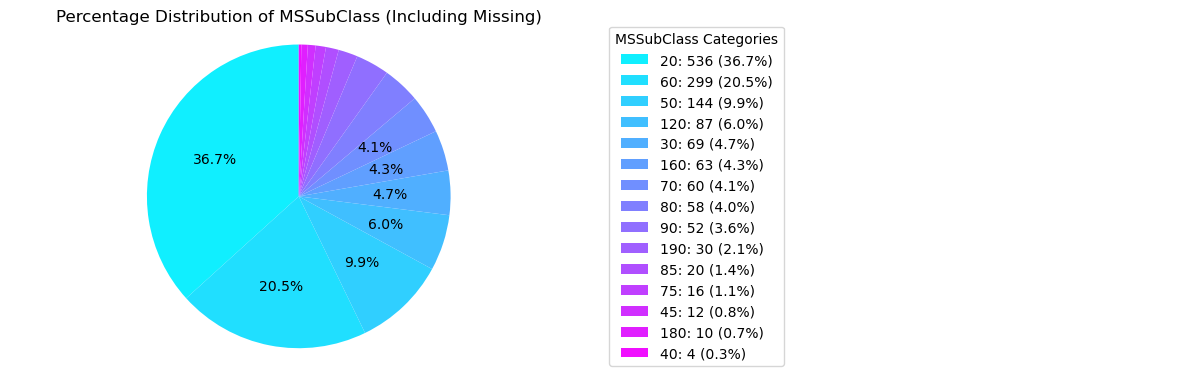

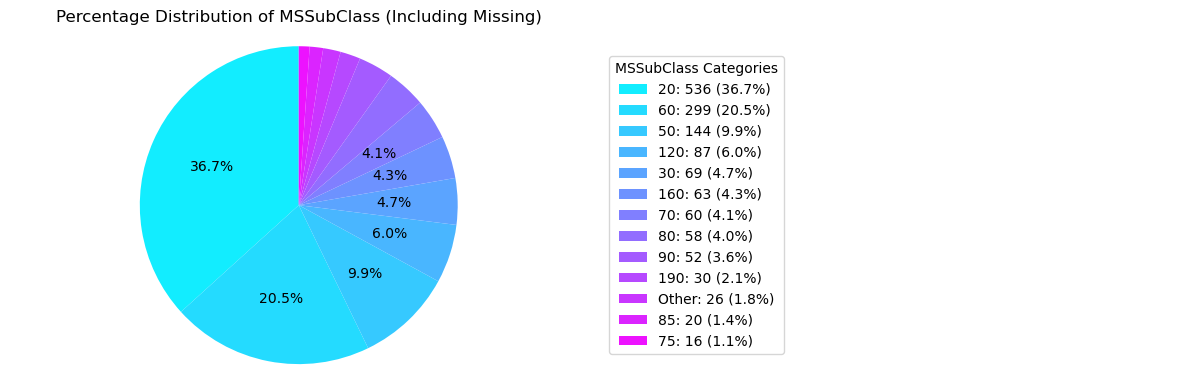

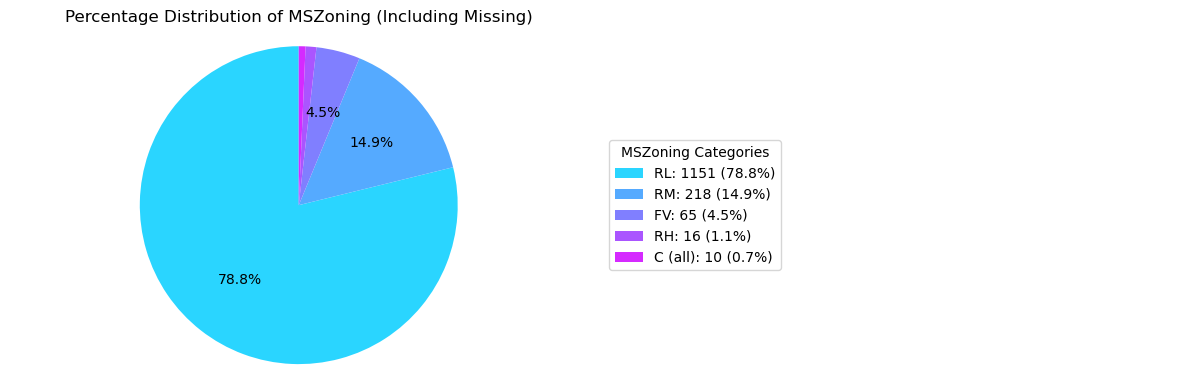

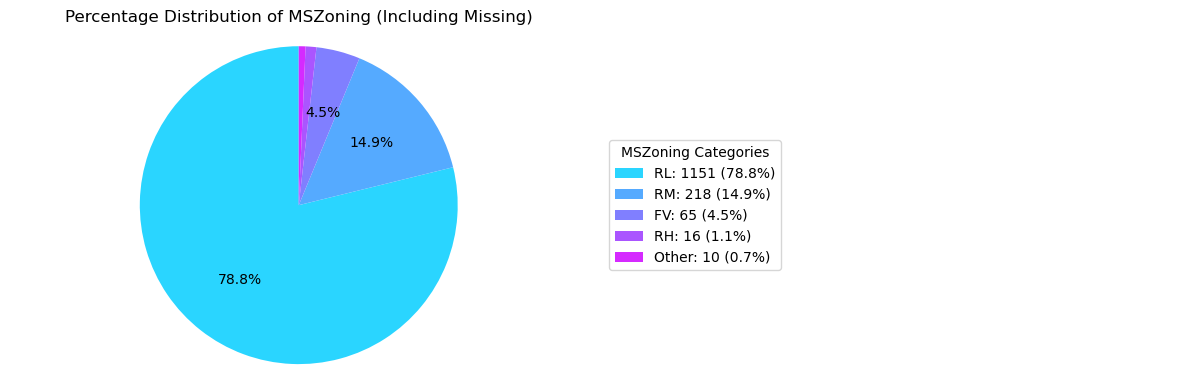

No pre-encoding transformers for feature: LotFrontage
No pre-encoding transformers for feature: LotArea


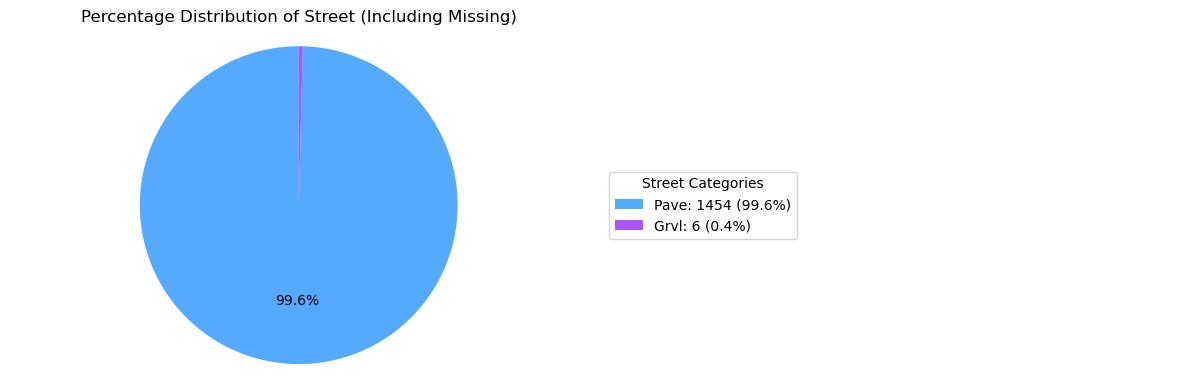

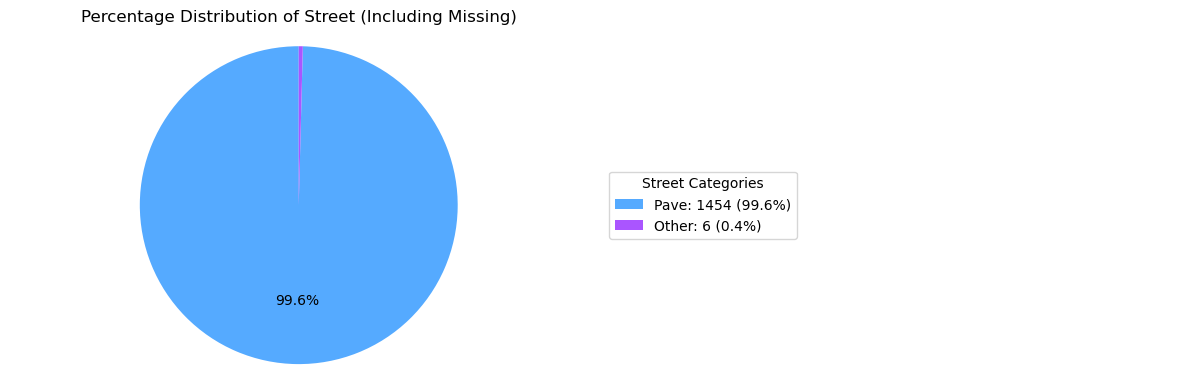

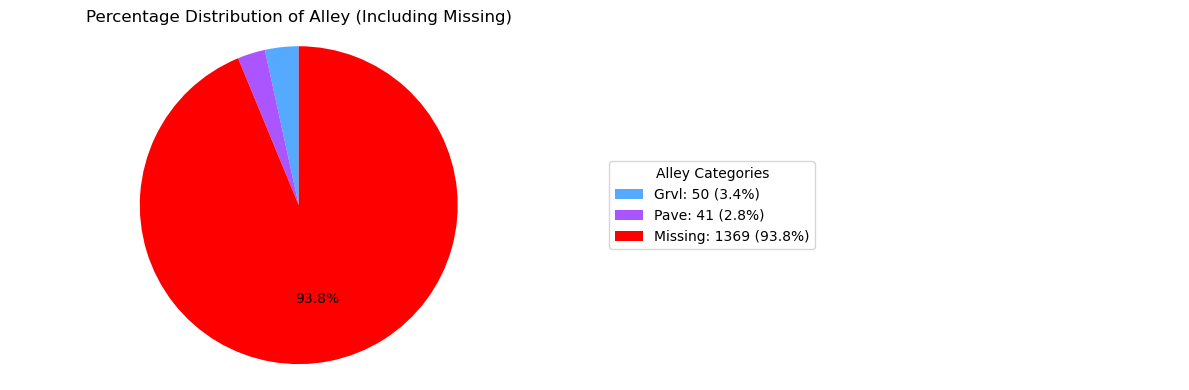

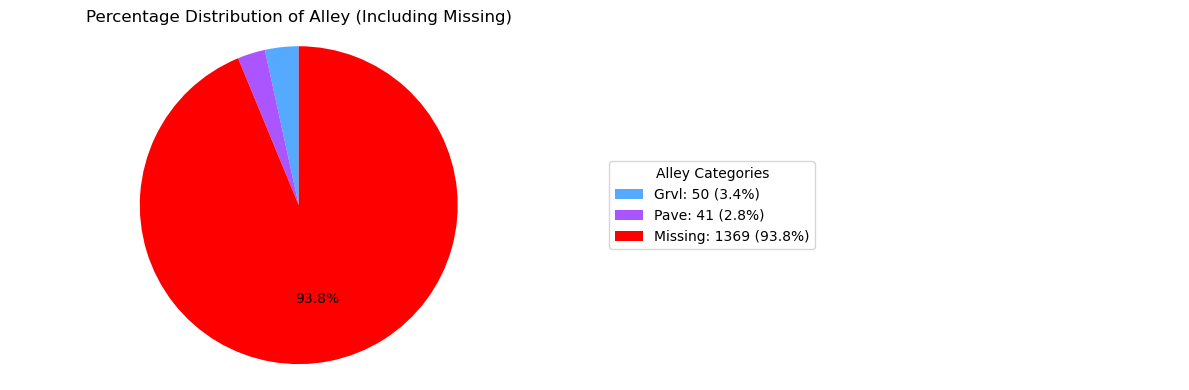

No pre-encoding transformers for feature: LotShape
No pre-encoding transformers for feature: LandContour


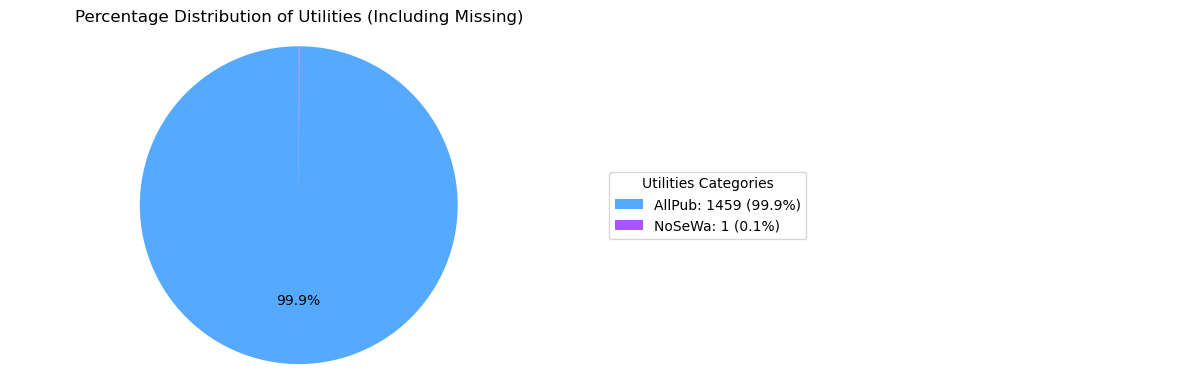

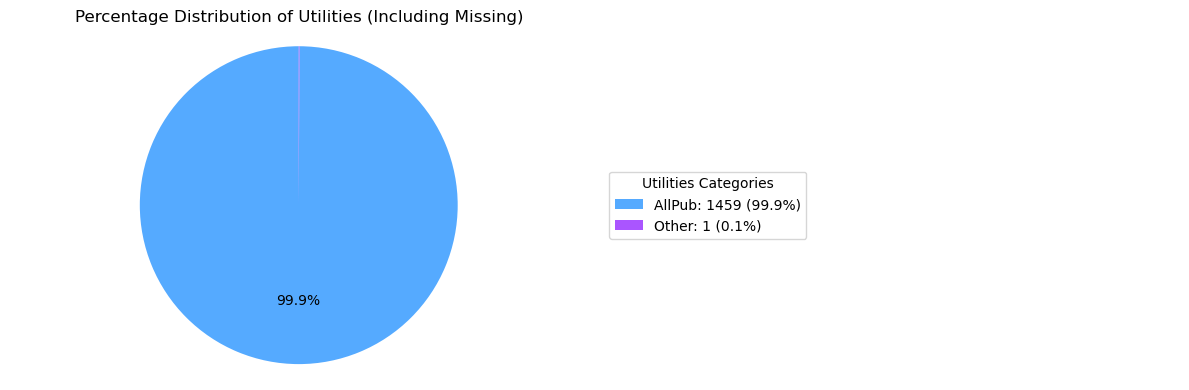

No pre-encoding transformers for feature: LotConfig
No pre-encoding transformers for feature: LandSlope


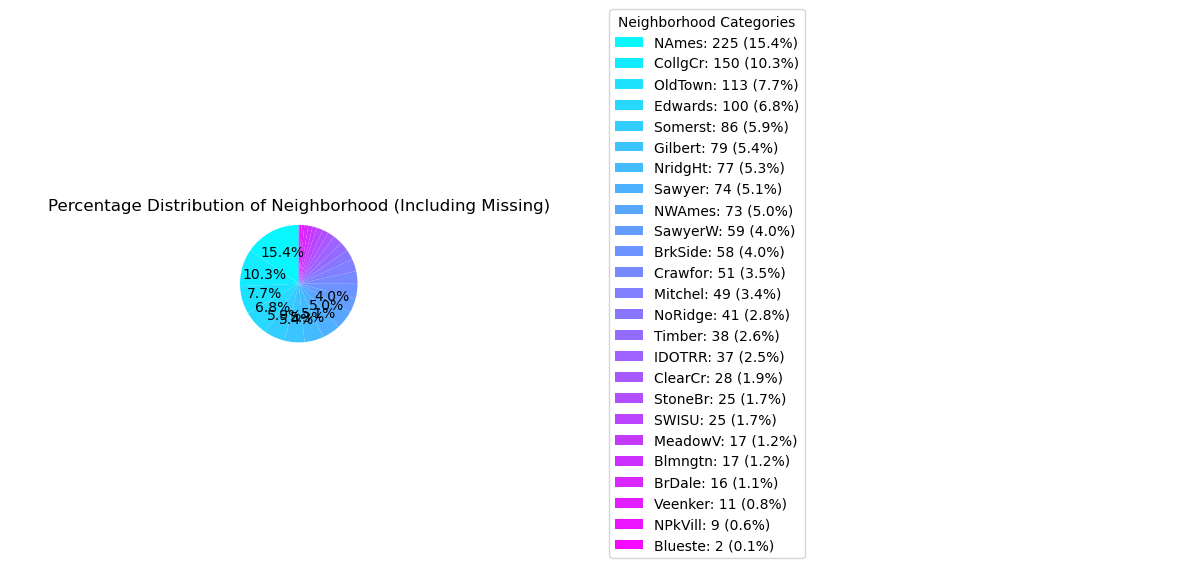

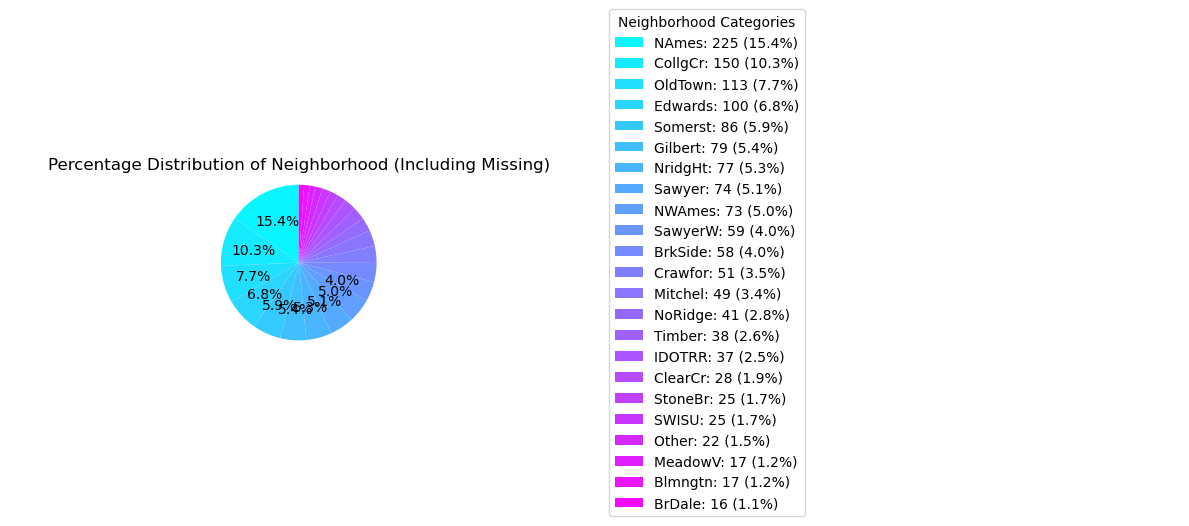

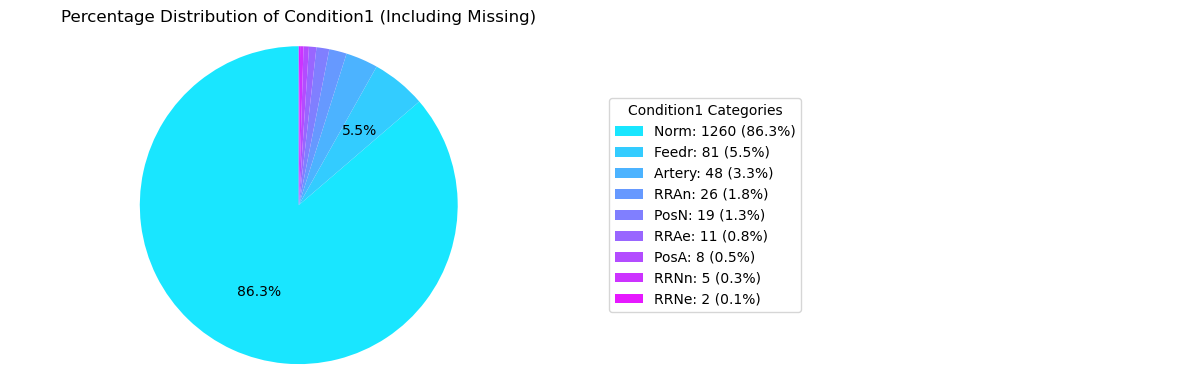

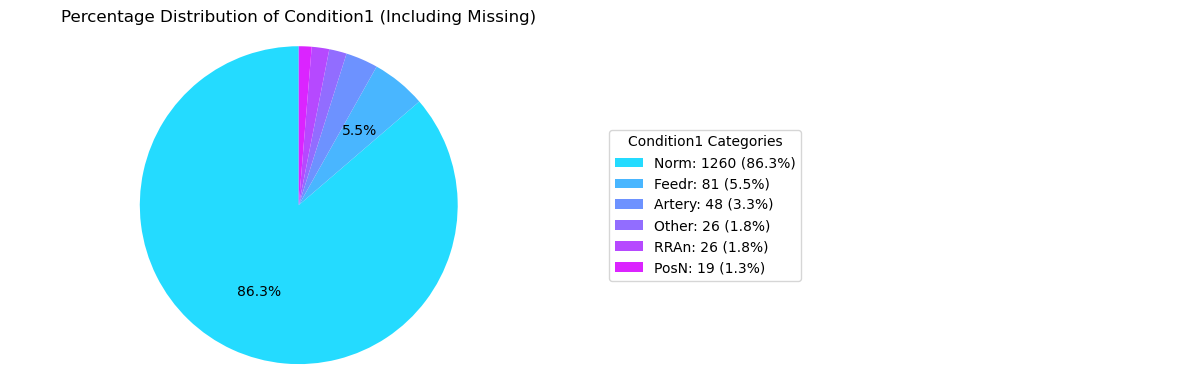

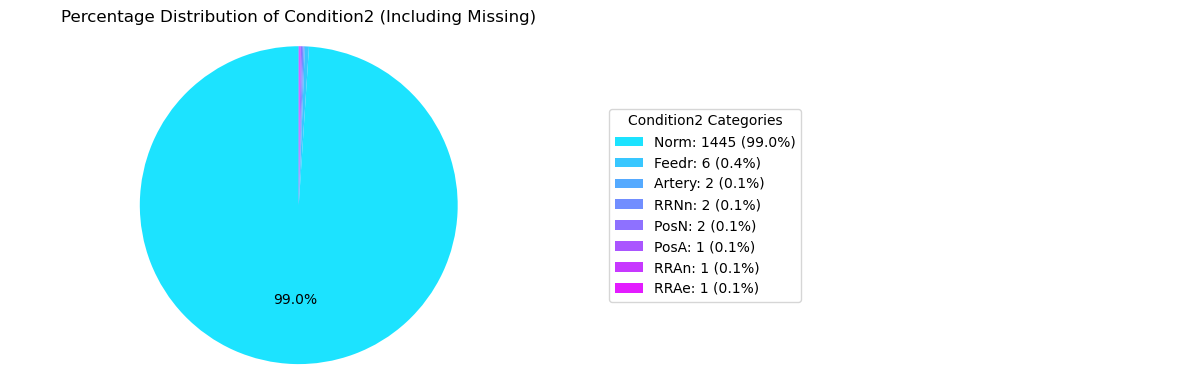

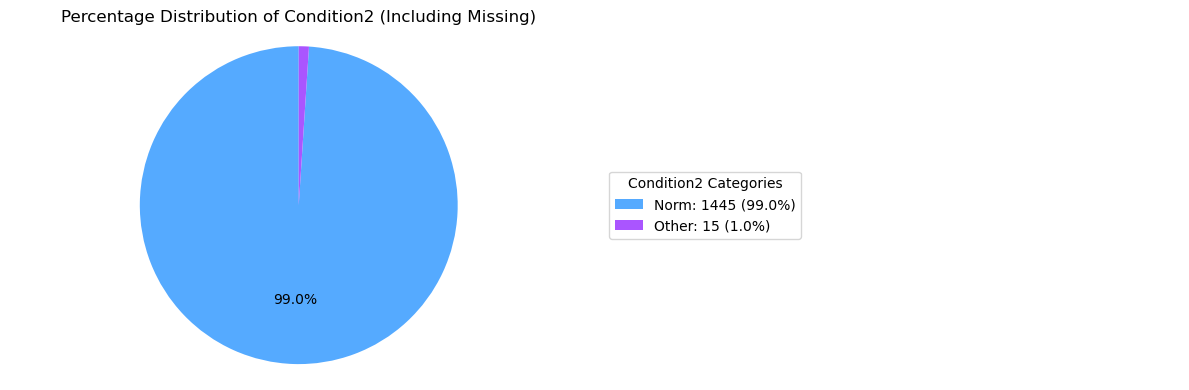

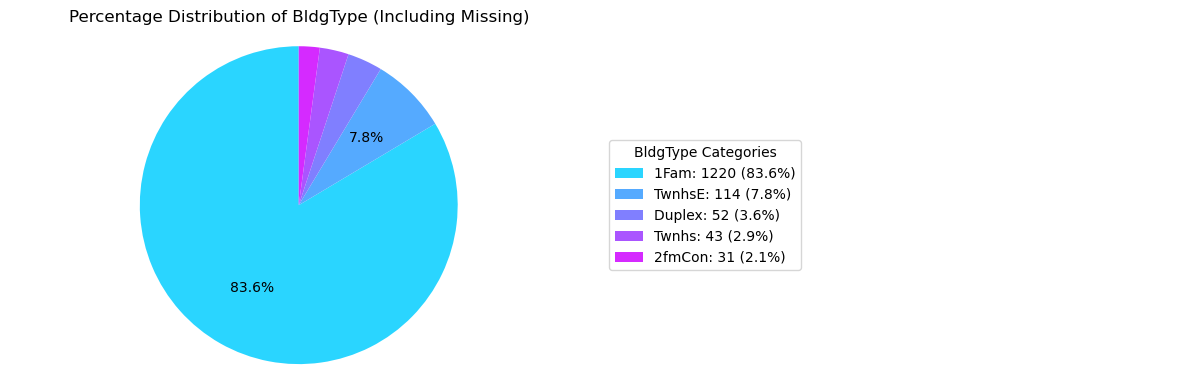

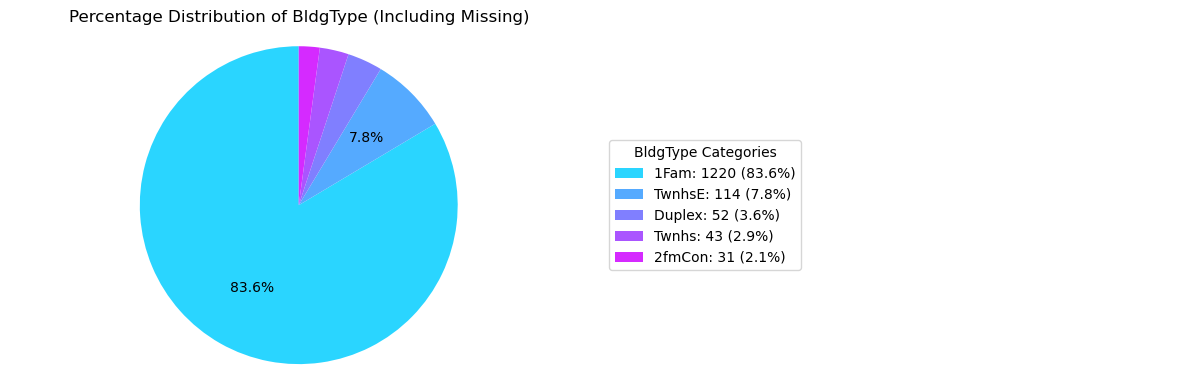

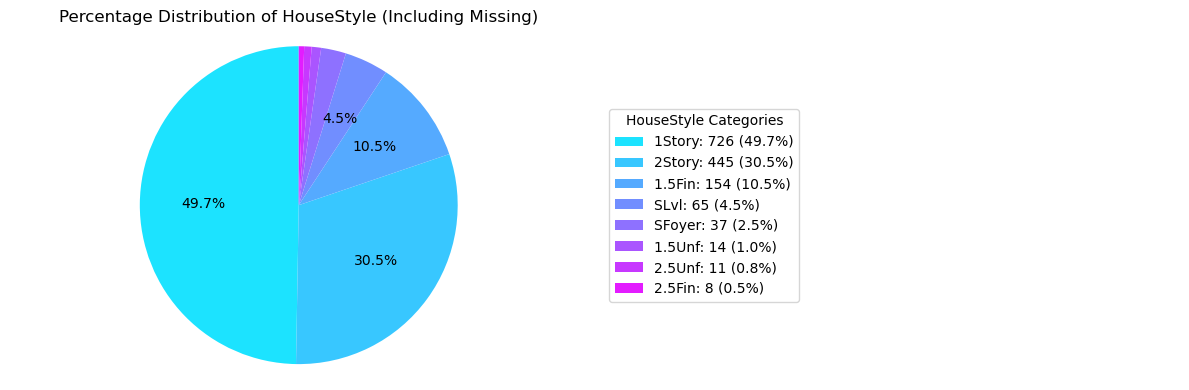

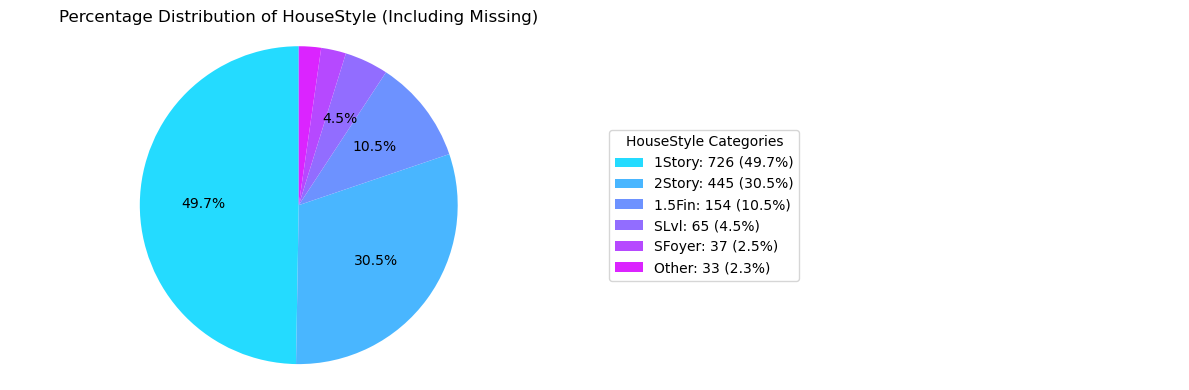

No pre-encoding transformers for feature: OverallQual
No pre-encoding transformers for feature: OverallCond
No pre-encoding transformers for feature: YearBuilt
No pre-encoding transformers for feature: YearRemodAdd


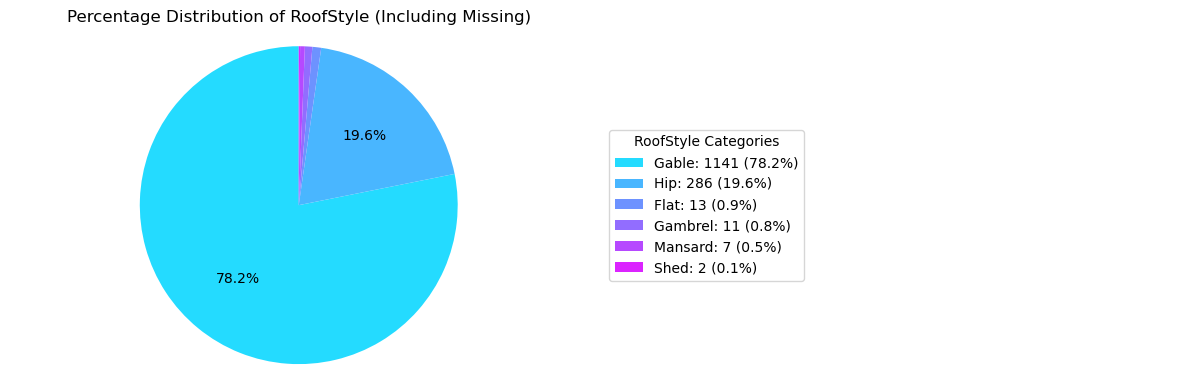

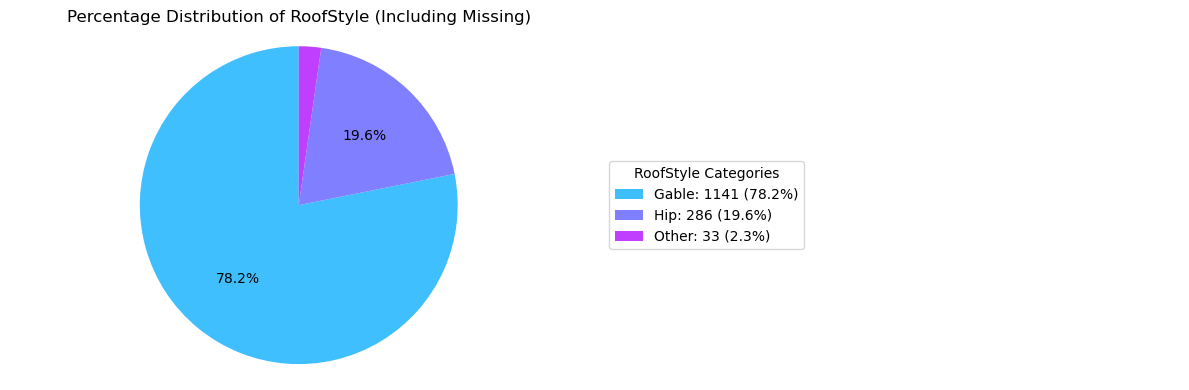

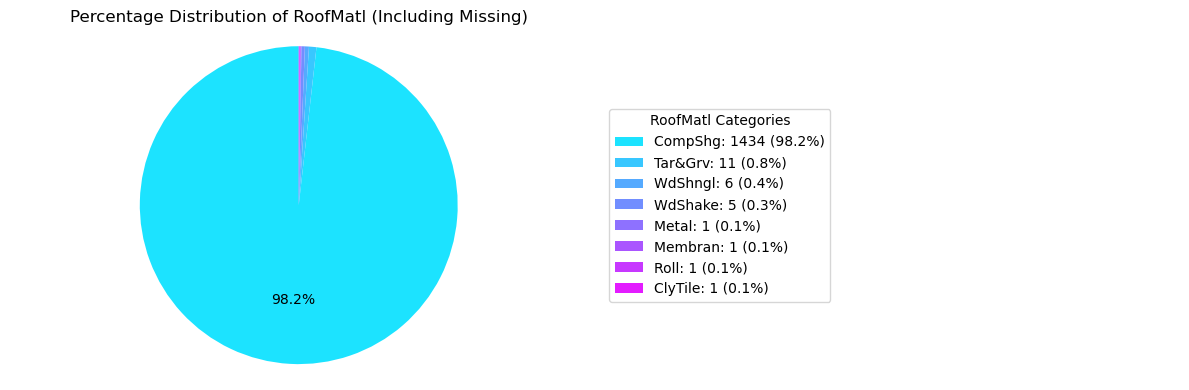

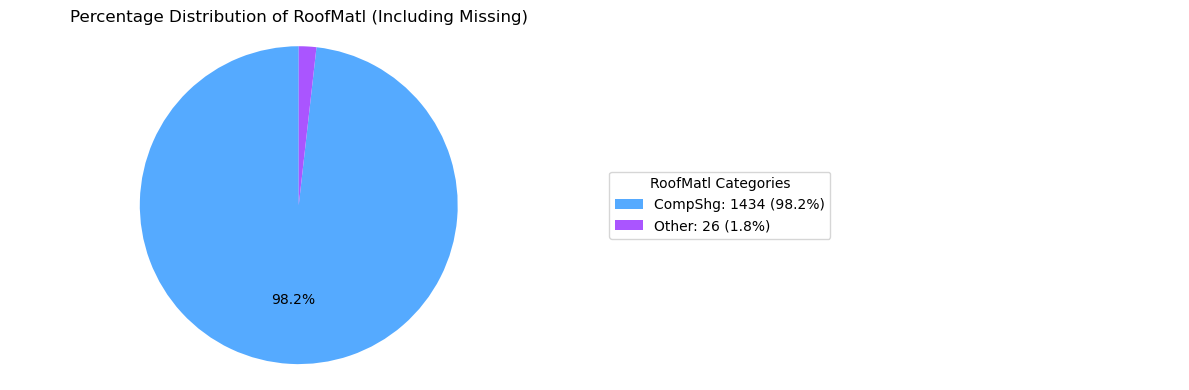

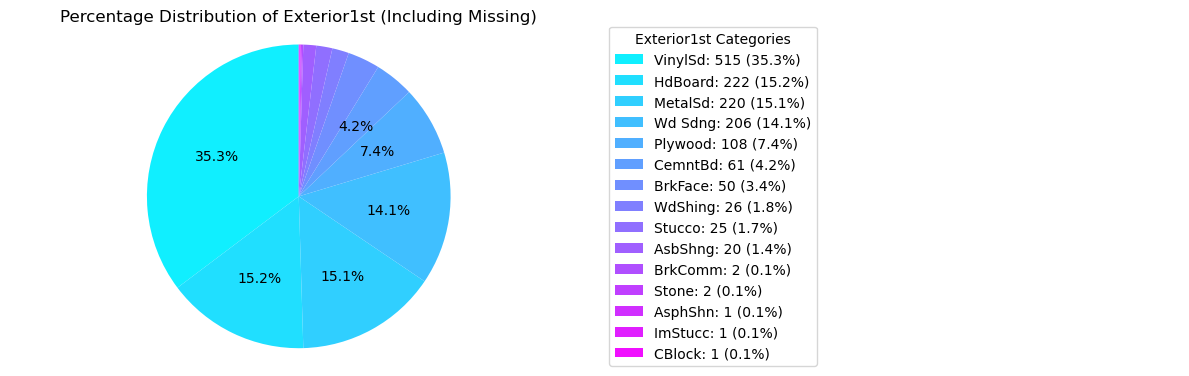

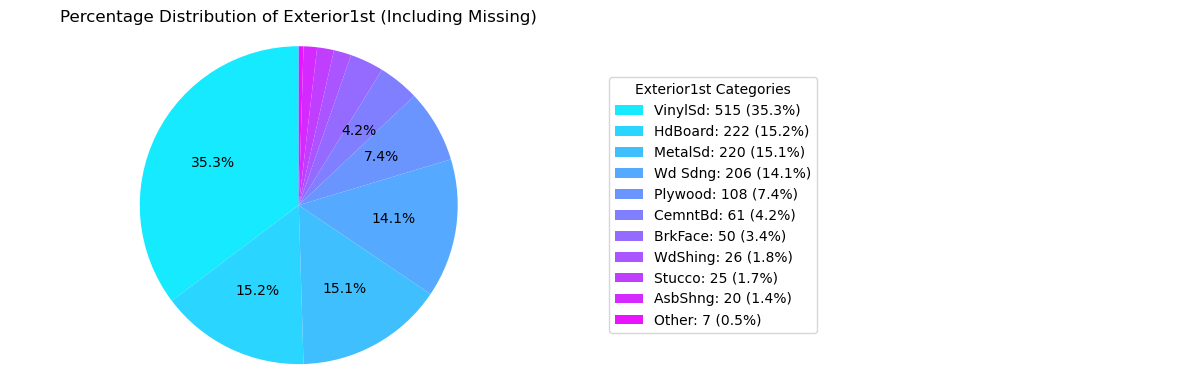

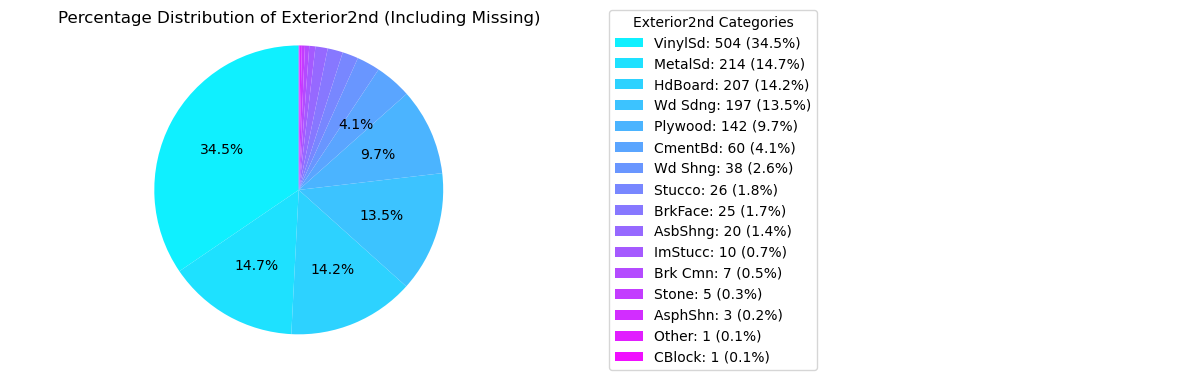

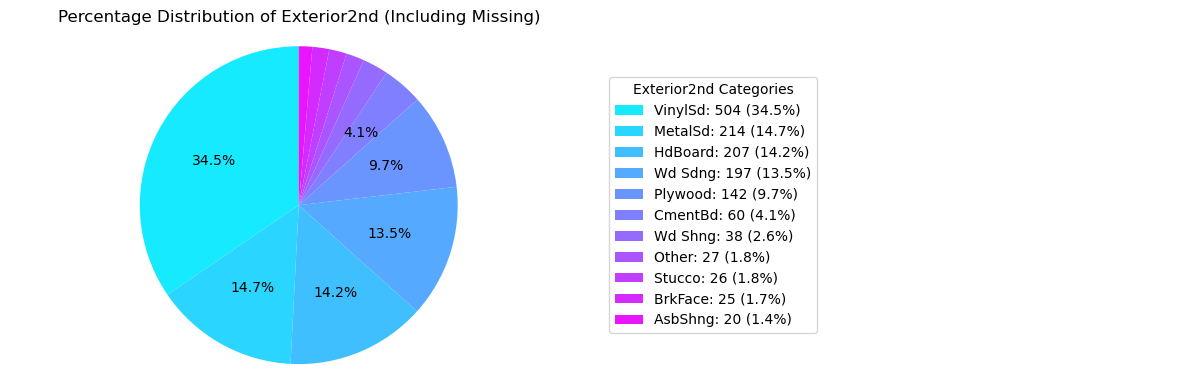

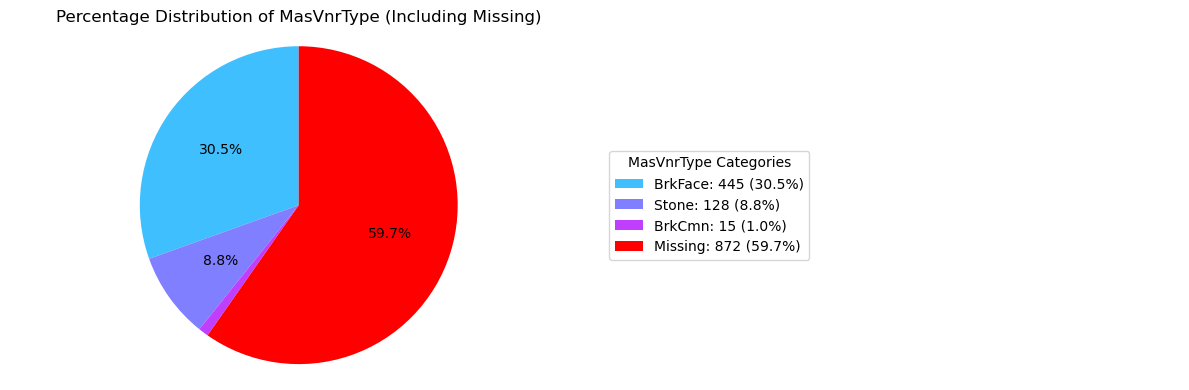

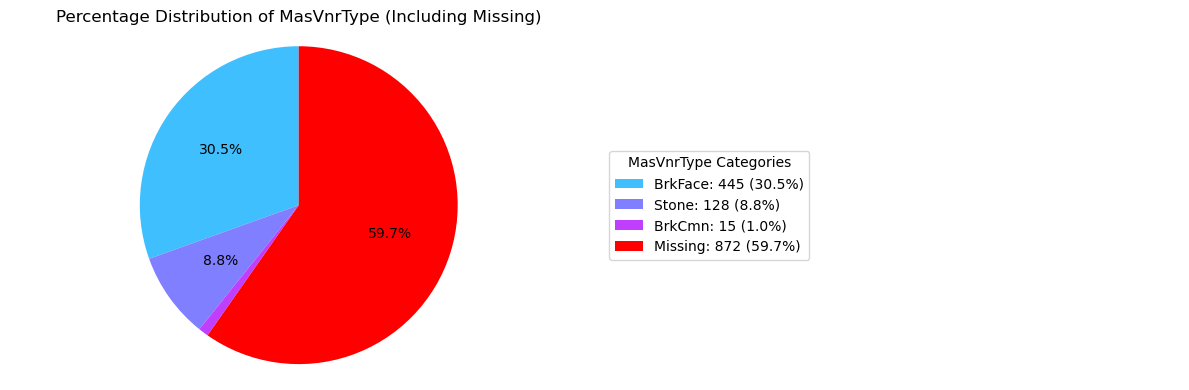

No pre-encoding transformers for feature: MasVnrArea
No pre-encoding transformers for feature: ExterQual
No pre-encoding transformers for feature: ExterCond


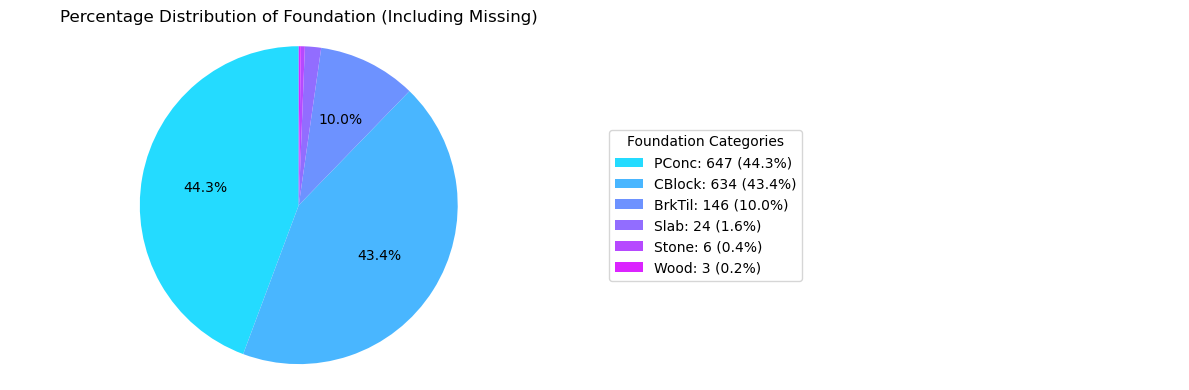

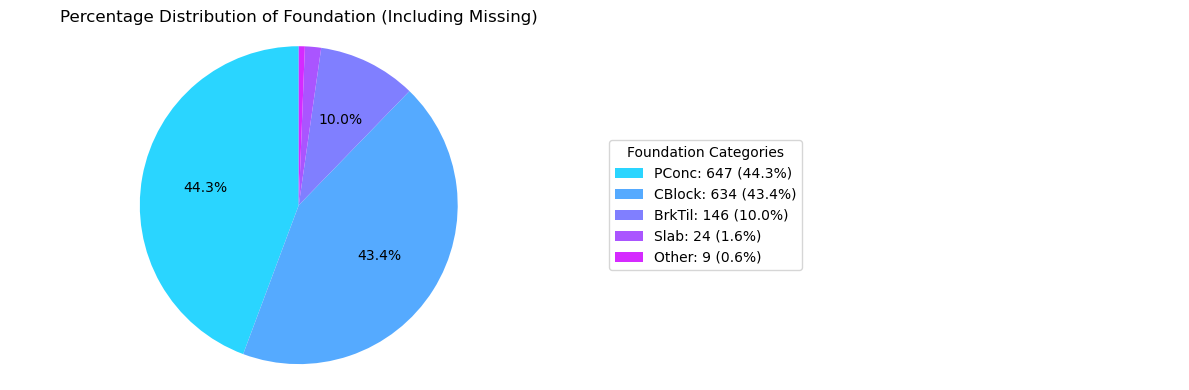

No pre-encoding transformers for feature: BsmtQual
No pre-encoding transformers for feature: BsmtCond
No pre-encoding transformers for feature: BsmtExposure
No pre-encoding transformers for feature: BsmtFinType1
No pre-encoding transformers for feature: BsmtFinSF1
No pre-encoding transformers for feature: BsmtFinType2
No pre-encoding transformers for feature: BsmtFinSF2
No pre-encoding transformers for feature: BsmtUnfSF
No pre-encoding transformers for feature: TotalBsmtSF


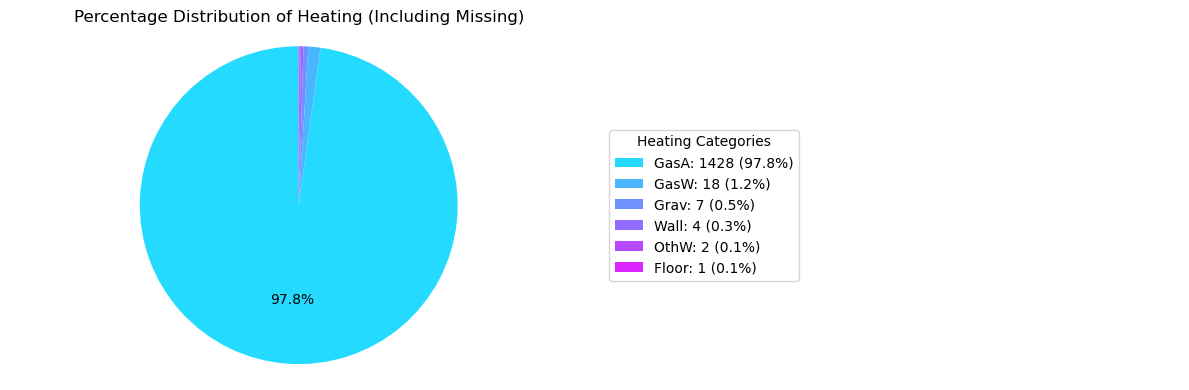

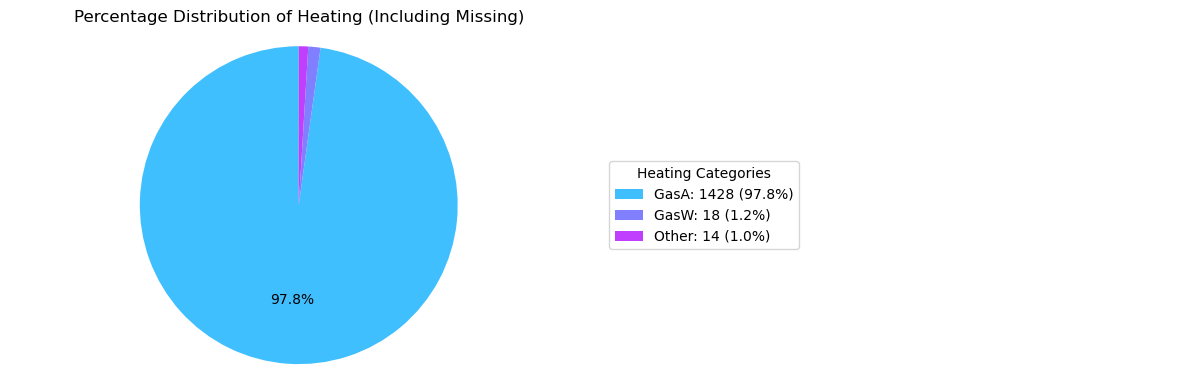

No pre-encoding transformers for feature: HeatingQC
No pre-encoding transformers for feature: CentralAir


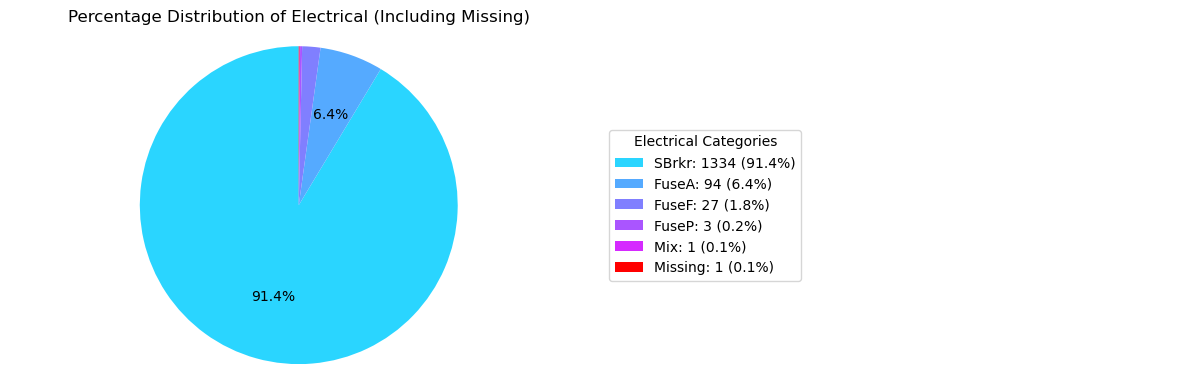

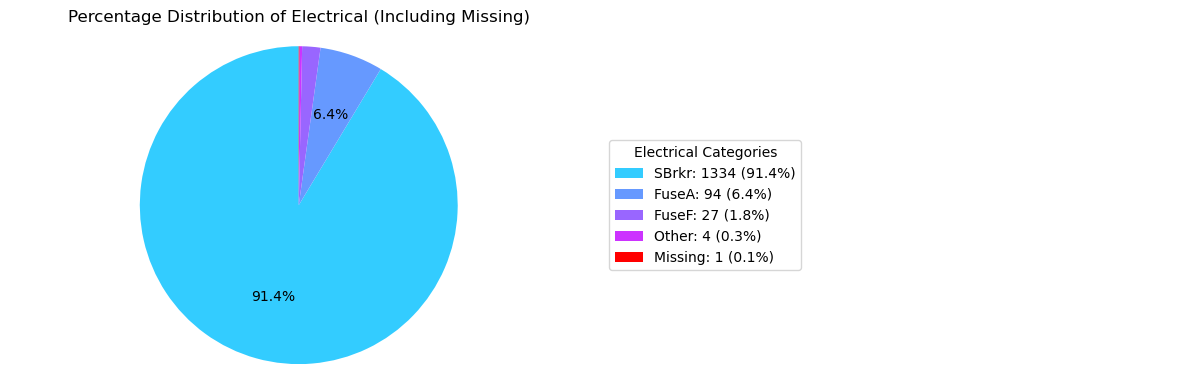

No pre-encoding transformers for feature: 1stFlrSF
No pre-encoding transformers for feature: 2ndFlrSF
No pre-encoding transformers for feature: LowQualFinSF
No pre-encoding transformers for feature: GrLivArea
No pre-encoding transformers for feature: BsmtFullBath
No pre-encoding transformers for feature: BsmtHalfBath
No pre-encoding transformers for feature: FullBath
No pre-encoding transformers for feature: HalfBath
No pre-encoding transformers for feature: KitchenQual
No pre-encoding transformers for feature: TotRmsAbvGrd
No pre-encoding transformers for feature: Functional
No pre-encoding transformers for feature: Fireplaces
No pre-encoding transformers for feature: FireplaceQu


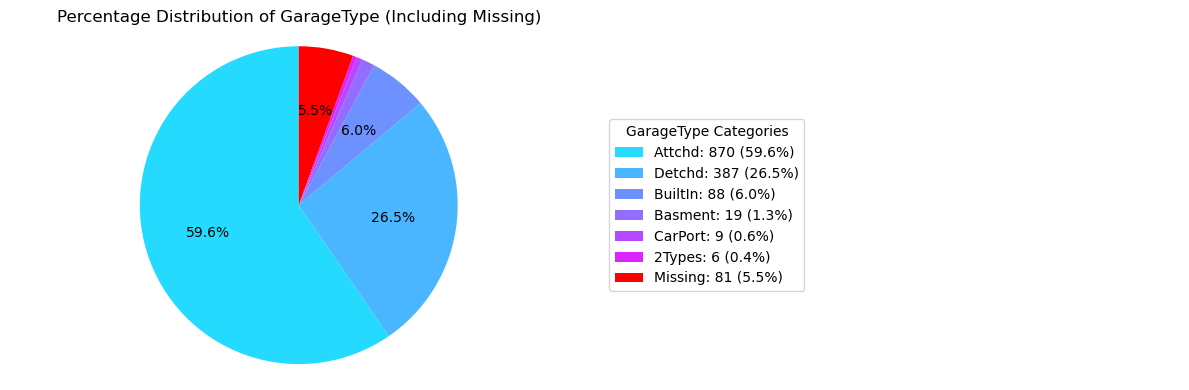

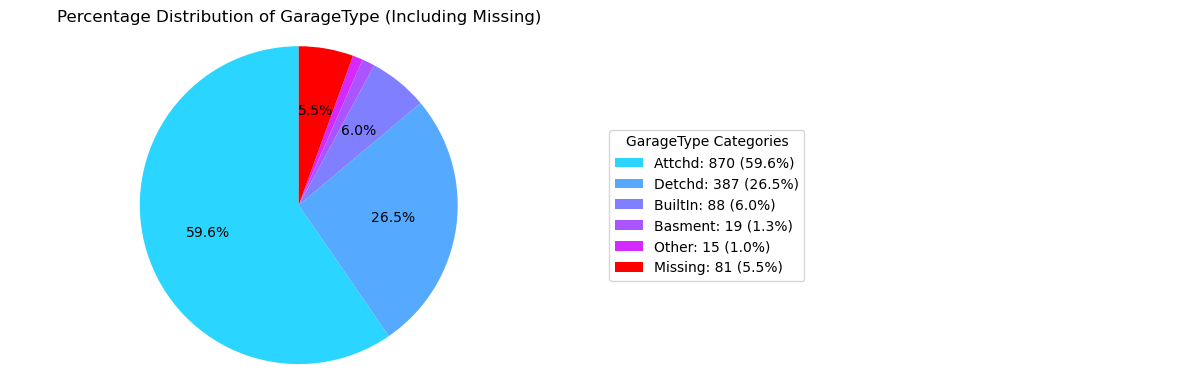

No pre-encoding transformers for feature: GarageYrBlt
No pre-encoding transformers for feature: GarageFinish
No pre-encoding transformers for feature: GarageCars
No pre-encoding transformers for feature: GarageArea
No pre-encoding transformers for feature: GarageQual
No pre-encoding transformers for feature: GarageCond
No pre-encoding transformers for feature: PavedDrive
No pre-encoding transformers for feature: WoodDeckSF
No pre-encoding transformers for feature: OpenPorchSF
No pre-encoding transformers for feature: EnclosedPorch
No pre-encoding transformers for feature: 3SsnPorch
No pre-encoding transformers for feature: ScreenPorch
No pre-encoding transformers for feature: PoolArea
No pre-encoding transformers for feature: PoolQC


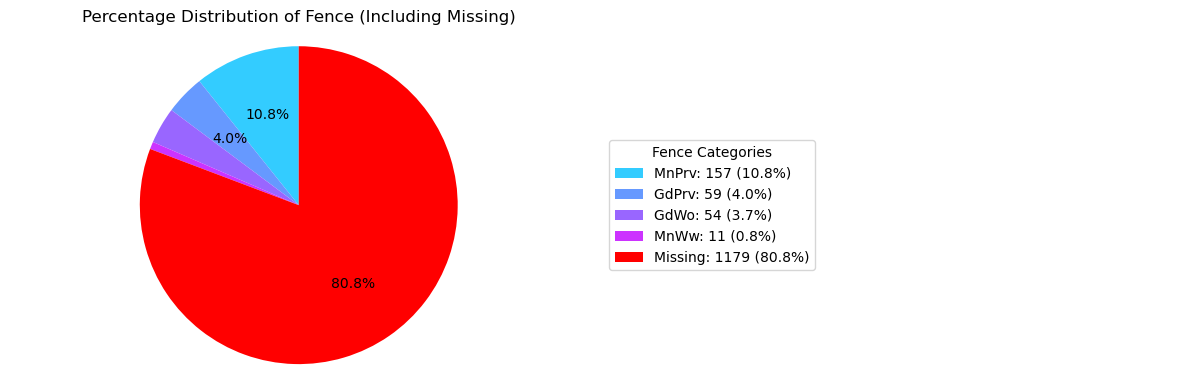

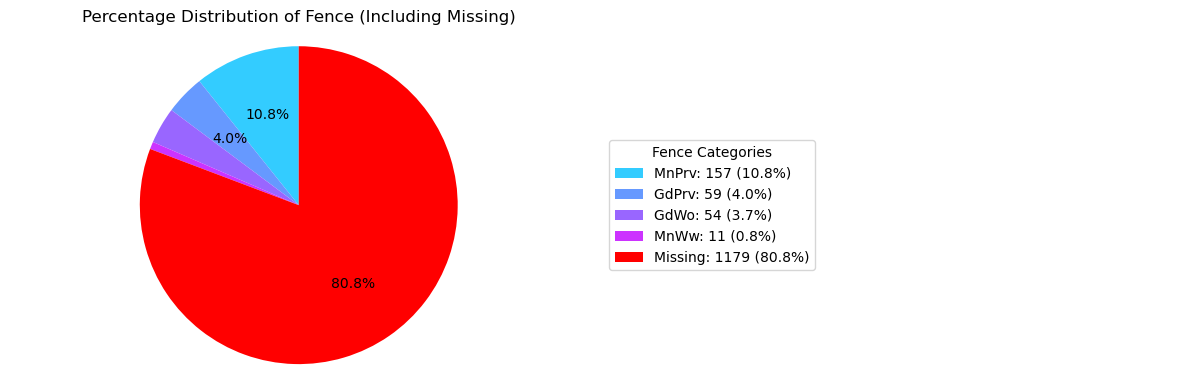

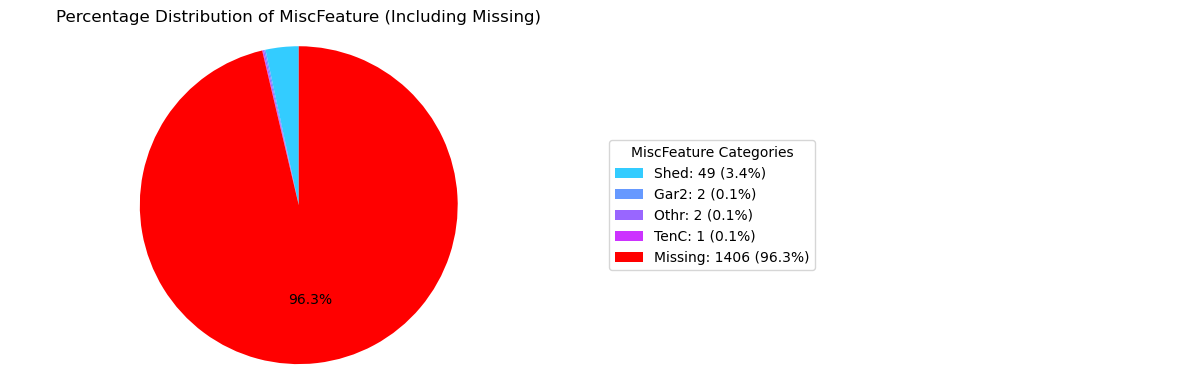

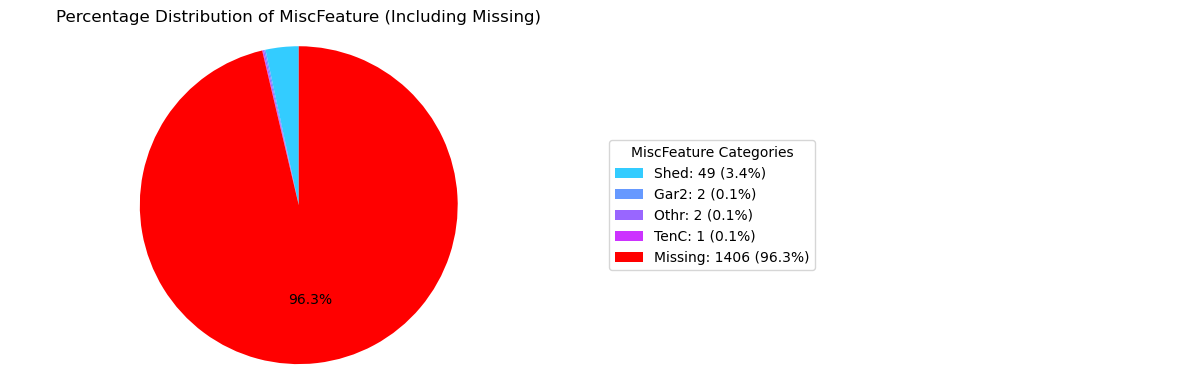

No pre-encoding transformers for feature: MiscVal
No pre-encoding transformers for feature: MoSold
No pre-encoding transformers for feature: YrSold


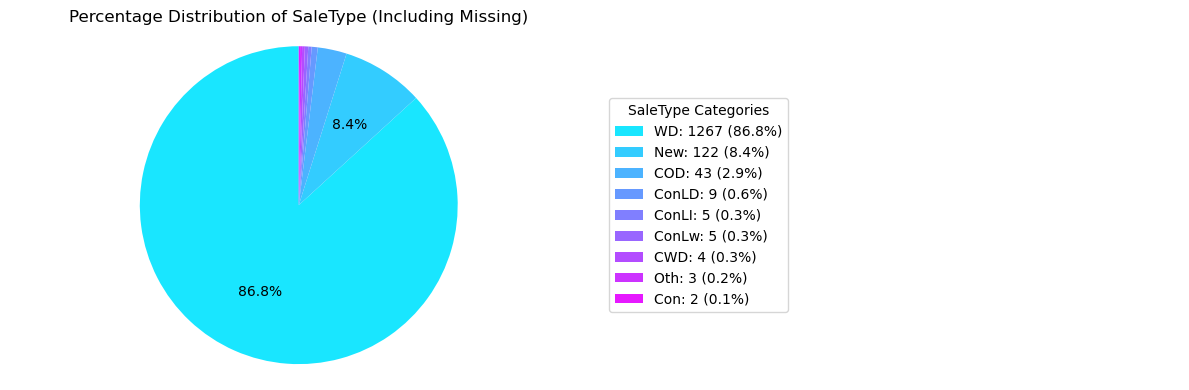

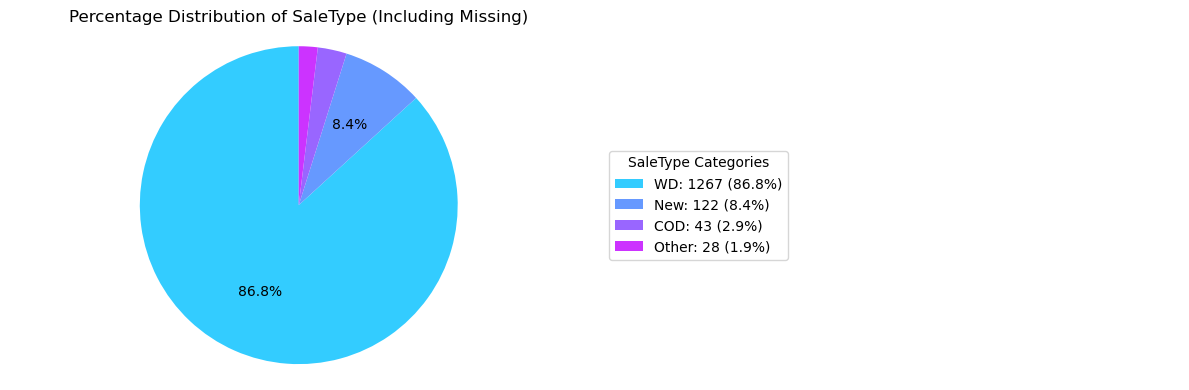

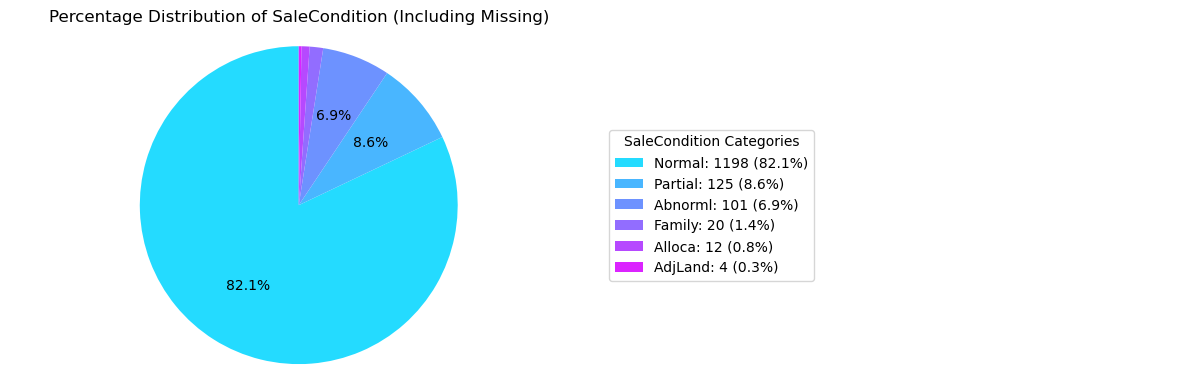

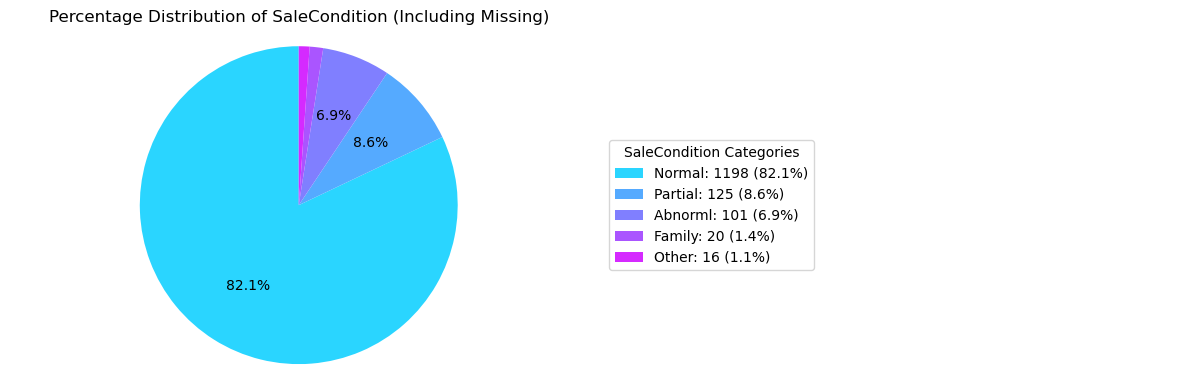

No pre-encoding transformers for feature: BedroomAbvGr
No pre-encoding transformers for feature: KitchenAbvGr


In [86]:
# Test the pre-encode transformers for a all columns
for feature in data_description_dict:
    test_custom_transformers_pre_encode(feature, feature_engineering_plan, df, rare_category_threshold=0.01)

build pipeline for each feature

In [120]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

def build_feature_pipeline(feature, feature_engineering_plan, data_description_dict, current_year=2024, rare_category_threshold=0.01):
    """
    Builds a preprocessing pipeline for a single feature.
    
    Parameters:
    - feature (str): The feature name.
    - feature_engineering_plan (dict): The feature engineering plan dictionary.
    - data_description_dict (dict): Dictionary containing feature descriptions.
    - current_year (int): The current year for temporal feature transformations.
    - rare_category_threshold (float): Threshold to group rare categories.
    
    Returns:
    - feature_pipeline (Pipeline): The preprocessing pipeline for the feature.
    """
    params = feature_engineering_plan.get(feature, {})
    
    steps = []
    
    # 1. Imputation
    imputer_step = create_imputer(feature, params)
    steps.append(imputer_step)
    
    # 2. Pre-encoding Custom Transformations
    pre_encode_transformers = create_custom_transformers_pre_encode(
        feature, params, rare_category_threshold
    )
    steps.extend(pre_encode_transformers)
    
    # 3. Encoding
    encoder_step = create_encoder(feature, params)
    if encoder_step:
        steps.append(encoder_step)
    
    # 4. Post-encoding Custom Transformations
    post_encode_transformers = create_custom_transformers_post_encode(
        feature, params, current_year
    )
    steps.extend(post_encode_transformers)
    
    # Assemble the feature pipeline
    feature_pipeline = Pipeline(steps=steps)
    
    return feature_pipeline


test the pipeline

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def test_preprocessing_on_feature(feature, feature_engineering_plan, data_description_dict, df, current_year=2024, rare_category_threshold=0.01):
    """
    Tests the preprocessing pipeline on a single feature by visualizing it before and after preprocessing.
    
    Parameters:
    - feature (str): The feature name to test.
    - feature_engineering_plan (dict): The feature engineering plan dictionary.
    - data_description_dict (dict): Dictionary containing feature descriptions.
    - df (pd.DataFrame): The original dataframe.
    - current_year (int): The current year for temporal feature transformations.
    - rare_category_threshold (float): Threshold to group rare categories.
    
    Returns:
    - None: Displays histograms of the feature before and after preprocessing.
    """
    # Extract the feature data before preprocessing
    original_data = df[feature].copy()
    
    # Build the feature pipeline
    feature_pipeline = build_feature_pipeline(
        feature, 
        feature_engineering_plan, 
        data_description_dict, 
        current_year, 
        rare_category_threshold
    )
    
    # Prepare the data for the pipeline
    feature_data = df[[feature]].copy()
    
    # Fit and transform the data
    transformed_data = feature_pipeline.fit_transform(feature_data)
    
    # Convert transformed data to a DataFrame for visualization
    if isinstance(transformed_data, np.ndarray):
        # Handle cases where multiple transformed features are generated
        if transformed_data.ndim == 1 or transformed_data.shape[1] == 1:
            transformed_data_df = pd.Series(transformed_data.ravel(), name=f'{feature}_transformed')
        else:
            transformed_data_df = pd.DataFrame(
                transformed_data, 
                columns=[f'{feature}_transformed_{i}' for i in range(transformed_data.shape[1])]
            )
    elif isinstance(transformed_data, pd.DataFrame):
        transformed_data_df = transformed_data
    else:
        raise ValueError("Transformed data is neither a numpy array nor a pandas DataFrame")
    
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot original feature
    sns.histplot(original_data, kde=True, ax=axes[0], bins=30, color='skyblue')
    axes[0].set_title(f'Original {feature}')
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel('Frequency')
    
    # Plot transformed feature
    if isinstance(transformed_data_df, pd.Series):
        sns.histplot(transformed_data_df, kde=True, ax=axes[1], bins=30, color='salmon')
        axes[1].set_title(f'Transformed {feature}')
        axes[1].set_xlabel(f'{feature}_transformed')
        axes[1].set_ylabel('Frequency')
    else:
        for col in transformed_data_df.columns:
            sns.histplot(transformed_data_df[col], kde=True, ax=axes[1], bins=30, label=col, element='step')
        axes[1].set_title(f'Transformed {feature}')
        axes[1].set_xlabel('Transformed Features')
        axes[1].set_ylabel('Frequency')
        axes[1].legend()
    
    plt.tight_layout()
    plt.show()


In [122]:
# Example feature to test
test_feature = 'MSZoning'

# Call the test function
test_preprocessing_on_feature(
    feature=test_feature, 
    feature_engineering_plan=feature_engineering_plan, 
    data_description_dict=data_description_dict, 
    df=df, 
    current_year=2024, 
    rare_category_threshold=0.01
)


AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

build the complete pipeline for all features.

In [116]:
from sklearn.compose import ColumnTransformer

def build_pipeline(feature_engineering_plan, data_description_dict, current_year=2024, rare_category_threshold=0.01):
    """
    Builds a sklearn ColumnTransformer pipeline based on the feature engineering plan.
    
    Parameters:
    - feature_engineering_plan (dict): The feature engineering plan dictionary.
    - data_description_dict (dict): Dictionary containing feature descriptions.
    - current_year (int): The current year for temporal feature transformations.
    - rare_category_threshold (float): Threshold to group rare categories.
    
    Returns:
    - preprocessor (ColumnTransformer): The constructed preprocessing pipeline.
    """
    transformers = []
    
    for feature in feature_engineering_plan.keys():
        feature_pipeline = build_feature_pipeline(
            feature, 
            feature_engineering_plan, 
            data_description_dict, 
            current_year, 
            rare_category_threshold
        )
        transformers.append((feature, feature_pipeline, [feature]))
    
    # Create the ColumnTransformer
    preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')
    
    return preprocessor




apply the pipeline

In [118]:
# Build the pipeline using the refactored build_pipeline function
preprocessor = build_pipeline(feature_engineering_plan, data_description_dict, current_year=2024, rare_category_threshold=0.01)

In [117]:


# Fit and transform the training data
X_train_transformed = preprocessor.fit_transform(df)

# Function to retrieve feature names after transformation
def get_feature_names(preprocessor, feature_engineering_plan):
    """
    Retrieves the feature names after transformation.

    Parameters:
    - preprocessor (ColumnTransformer): The preprocessing pipeline.
    - feature_engineering_plan (dict): The feature engineering plan dictionary.

    Returns:
    - feature_names (list): List of transformed feature names.
    """
    feature_names = []
    for name, transformer, features in preprocessor.transformers_:
        if name == 'remainder' and transformer == 'drop':
            continue
        if isinstance(transformer, Pipeline):
            # Check if OneHotEncoder is in the pipeline
            encoder = None
            for step_name, step_transformer in transformer.steps:
                if isinstance(step_transformer, OneHotEncoder):
                    encoder = step_transformer
                    break
            if encoder:
                encoded_names = encoder.get_feature_names_out(features)
                feature_names.extend(encoded_names)
            elif 'binary_indicator' in [step[0] for step in transformer.steps]:
                # Handle binary indicators
                for step_name, step_transformer in transformer.steps:
                    if step_name == 'to_dataframe':
                        # Extract the binary feature name
                        # Assuming the last step is 'to_dataframe'
                        bin_feat = step_transformer.func.__self__.columns[0]
                        feature_names.append(bin_feat)
            elif 'create_temporal_features' in [step[0] for step in transformer.steps]:
                # Extract temporal feature names
                feature_names.extend(['BuiltCentury', 'BuiltHalfCentury'])
            else:
                # For other transformers like FunctionTransformer
                feature_names.extend(features)
        else:
            # For non-pipeline transformers
            feature_names.extend(features)
    return feature_names

# Get feature names
feature_names = get_feature_names(preprocessor, feature_engineering_plan)

# Convert transformed data to DataFrame with feature names
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)

print(X_train_transformed_df)



AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [27]:
#todo: how to see the steps in the pipeline?


# from sklearn import set_config
# # Display the pipeline in a diagram format
# set_config(display='diagram')
# feature_engineering_pipeline

def visualize_pipeline(feature, feature_engineering_pipeline):
    """
    Visualizes the pipeline steps for a given feature in the custom transformer.

    Parameters:
    feature (str): The feature name for which the pipeline is visualized.
    feature_engineering_pipeline: The custom transformer object containing pipelines for features.

    Returns:
    None
    """
    if feature not in feature_engineering_pipeline.transformers:
        print(f"No pipeline found for feature: {feature}")
        return

    pipeline = feature_engineering_pipeline.transformers[feature]
    print(f"Pipeline for feature '{feature}':")
    for name, step in pipeline.steps:
        print(f"  {name}: {step}")

visualize_pipeline('Condition1', feature_engineering_pipeline)


Pipeline for feature 'Condition1':
  imputer: SimpleImputer(strategy='most_frequent')


Visualize a specific column before and after transformation

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

def visualize_feature_transformation(feature, feature_engineering_plan, df, transformed_df):
    """
    Visualize the transformation of a feature based on its feature engineering plan.
    
    Parameters:
        feature (str): The feature name.
        feature_engineering_plan (dict): The feature engineering plan.
        df (pd.DataFrame): The original dataset.
        transformed_df (pd.DataFrame): The transformed dataset.
    """
    # Check if the feature is one-hot encoded
    is_one_hot_encoded = feature_engineering_plan.get(feature, {}).get('encoder') == 'OneHotEncoder'
    
    plt.figure(figsize=(12, 6))
    
    if is_one_hot_encoded:
        # Original column
        original_column = df[feature]
        
        # Transformed columns for this feature
        transformed_columns = transformed_df.filter(like=f'{feature}_')  # Filter one-hot encoded columns
        
        # Plot original column
        plt.subplot(1, 2, 1)
        original_column.value_counts().plot(kind='bar', alpha=0.7, color='blue')
        plt.title(f"Original {feature}")
        plt.xlabel("Categories")
        plt.ylabel("Count")
        
        # Plot transformed columns
        plt.subplot(1, 2, 2)
        transformed_columns.sum().plot(kind='bar', alpha=0.7, color='green')
        plt.title(f"Transformed {feature} (One-Hot Encoded)")
        plt.xlabel("Encoded Categories")
        plt.ylabel("Count")
    
    else:
        # Original column
        original_column = df[feature]
        transformed_column = transformed_df[feature]
        
        # Plot original column
        plt.subplot(1, 2, 1)
        if original_column.dtype in ['float64', 'int64']:
            plt.hist(original_column.dropna(), bins=30, alpha=0.7, color='blue')
            plt.title(f"Original {feature}")
            plt.xlabel("Values")
            plt.ylabel("Frequency")
        else:
            original_column.value_counts().plot(kind='bar', alpha=0.7, color='blue')
            plt.title(f"Original {feature}")
            plt.xlabel("Categories")
            plt.ylabel("Count")
        
        # Plot transformed column
        plt.subplot(1, 2, 2)
        if transformed_column.dtype in ['float64', 'int64']:
            plt.hist(transformed_column, bins=30, alpha=0.7, color='green')
            plt.title(f"Transformed {feature}")
            plt.xlabel("Values")
            plt.ylabel("Frequency")
        else:
            transformed_column.value_counts().plot(kind='bar', alpha=0.7, color='green')
            plt.title(f"Transformed {feature}")
            plt.xlabel("Categories")
            plt.ylabel("Count")
    
    plt.tight_layout()
    plt.show()



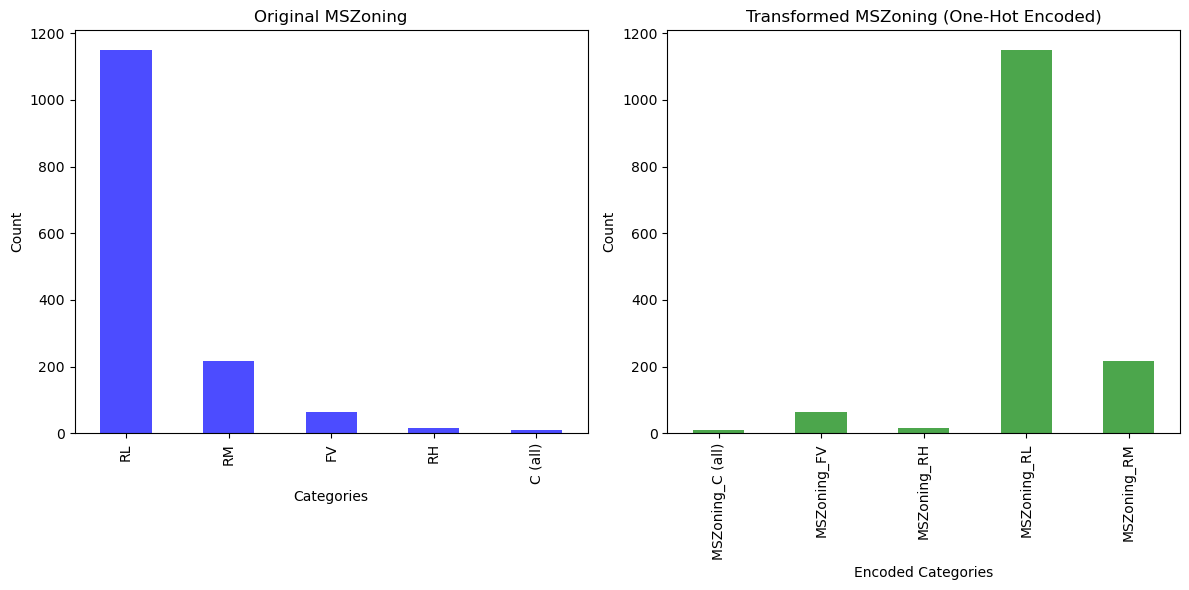

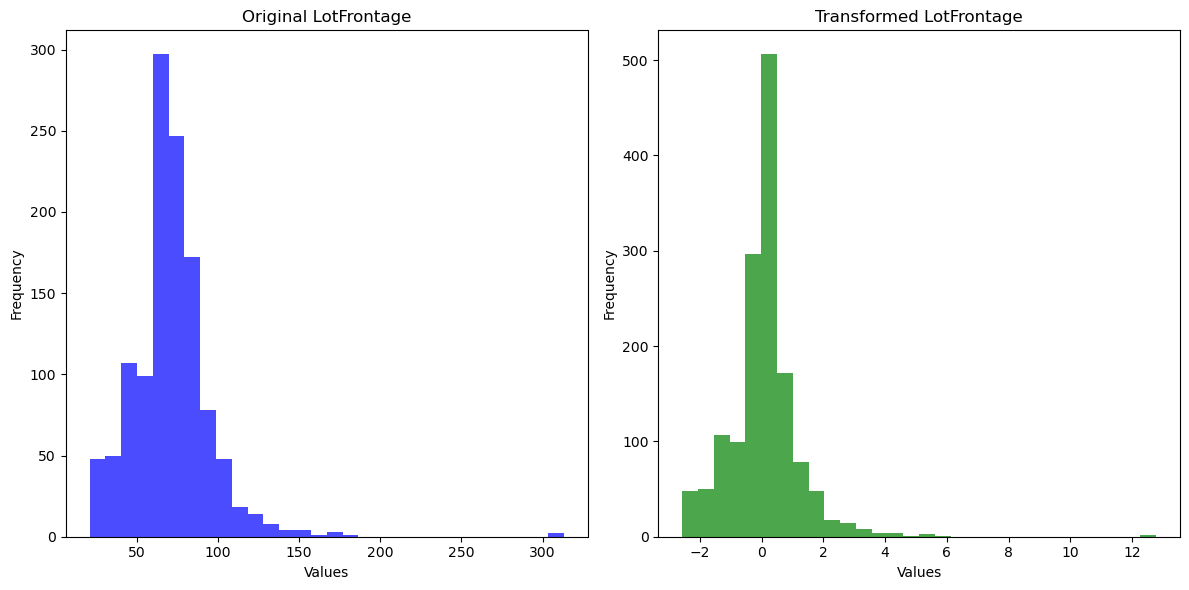

In [20]:
# Visualize MSZoning (one-hot encoded)
visualize_feature_transformation('MSZoning', feature_engineering_plan, df, transformed_df)

# Visualize LotFrontage (numerical feature)
visualize_feature_transformation('LotFrontage', feature_engineering_plan, df, transformed_df)

## Identifying Trends and Patterns
Quantifying Feature Impacts:
-Correlation.
-Mutual information.
-Conditional mutual information.


Dimension Reduction:

PCA or t-SNE to visualize relationships between features.
Analysis of principal components to determine which features contribute most to the variance.
Advanced Pattern Detection:

Interaction Detection with Decision Trees (highly recommended as it's EDA-driven, even if model-based).
Pairwise feature analysis to uncover significant relationships.
Distribution Trends:

Temporal trends (e.g., feature values changing over time).
Categorical breakdowns of key features versus the target (e.g., box plots, violin plots).

### Quantifying Feature Impact

Quantifying Feature Impact
todo: get the one hot encoding data from the feature engineering plan dict.

In [29]:
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import f_oneway
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

def quantify_feature_impact(transformed_df, data_description_dict, target_column):
    """
    Quantifies feature impact for all features in the dataset based on their types.

    Parameters:
        transformed_df (pd.DataFrame): The transformed dataset.
        data_description_dict (dict): Dictionary containing feature types for each field.
        target_column (str): The target variable.

    Returns:
        pd.DataFrame: A summary of feature impacts, including correlation, mutual information, 
                      and other relevant metrics.
    """
    feature_impacts = []

    for feature in transformed_df.columns:
        if feature == target_column:
            continue  # Skip target column

        feature_type = data_description_dict.get(feature, {}).get('Feature Type', 'Unknown')
        impact = {'Feature': feature, 'Feature Type': feature_type}

        try:
            # Handle one-hot encoded features by grouping them
            if feature_type == 'nominal' and any(transformed_df.columns.str.startswith(feature + "_")):
                one_hot_columns = transformed_df.filter(like=feature + "_")
                aggregated_feature = one_hot_columns.sum(axis=1)
                mutual_info = mutual_info_regression(
                    aggregated_feature.to_frame(), transformed_df[target_column]
                )[0]
                impact['Mutual Information'] = mutual_info
                impact['Correlation'] = None  # Correlation is not meaningful for one-hot encoding
                continue

            # Continuous: Use correlation and mutual information
            if feature_type == 'continuous':
                corr = transformed_df[feature].corr(transformed_df[target_column])
                mutual_info = mutual_info_regression(
                    transformed_df[[feature]], transformed_df[target_column]
                )[0]
                impact['Correlation'] = corr
                impact['Mutual Information'] = mutual_info

            # Ordinal: Use correlation and mutual information
            elif feature_type == 'ordinal':
                corr = transformed_df[feature].corr(transformed_df[target_column])
                mutual_info = mutual_info_regression(
                    transformed_df[[feature]], transformed_df[target_column]
                )[0]
                impact['Correlation'] = corr
                impact['Mutual Information'] = mutual_info

            # Nominal: Use ANOVA and mutual information
            elif feature_type == 'nominal':
                groups = [
                    transformed_df[target_column][
                        transformed_df[feature] == category
                    ]
                    for category in transformed_df[feature].unique()
                ]
                f_stat, p_value = f_oneway(*groups)
                mutual_info = mutual_info_regression(
                    pd.get_dummies(transformed_df[feature]), transformed_df[target_column]
                ).mean()
                impact['F-Statistic'] = f_stat
                impact['P-Value'] = p_value
                impact['Mutual Information'] = mutual_info

            # Boolean: Use correlation and mutual information
            elif feature_type == 'boolean':
                corr = transformed_df[feature].corr(transformed_df[target_column])
                mutual_info = mutual_info_regression(
                    transformed_df[[feature]], transformed_df[target_column]
                )[0]
                impact['Correlation'] = corr
                impact['Mutual Information'] = mutual_info

            # Cyclic: Use circular transformations and mutual information
            elif feature_type == 'cyclic':
                cyclic_transformed = pd.DataFrame({
                    f'{feature}_sin': np.sin(2 * np.pi * transformed_df[feature] / transformed_df[feature].max()),
                    f'{feature}_cos': np.cos(2 * np.pi * transformed_df[feature] / transformed_df[feature].max())
                })
                mutual_info = mutual_info_regression(
                    cyclic_transformed, transformed_df[target_column]
                ).mean()
                impact['Mutual Information'] = mutual_info

            # Temporal: Use mutual information directly
            elif feature_type == 'temporal':
                mutual_info = mutual_info_regression(
                    transformed_df[[feature]], transformed_df[target_column]
                )[0]
                impact['Mutual Information'] = mutual_info

            feature_impacts.append(impact)

        except Exception as e:
            print(f"Error processing feature {feature}: {e}")

    return pd.DataFrame(feature_impacts)


In [30]:
# Quantify feature impacts
feature_impact_df = quantify_feature_impact(transformed_df, data_description_dict, target_column='SalePrice')
print(feature_impact_df)

/home/alireza/Apps/anaconda3/envs/eda-house-prices/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


Error processing feature LotShape: could not convert string to float: 'Reg'
Error processing feature LandContour: could not convert string to float: 'Lvl'
Error processing feature LotConfig: could not convert string to float: 'Inside'
Error processing feature LandSlope: could not convert string to float: 'Gtl'


/home/alireza/Apps/anaconda3/envs/eda-house-prices/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):
/home/alireza/Apps/anaconda3/envs/eda-house-prices/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


Error processing feature MasVnrArea: Input X contains NaN.
Error processing feature ExterQual: could not convert string to float: 'Gd'
Error processing feature ExterCond: could not convert string to float: 'TA'
Error processing feature BsmtQual: could not convert string to float: 'Gd'
Error processing feature BsmtCond: could not convert string to float: 'TA'
Error processing feature BsmtExposure: could not convert string to float: 'No'
Error processing feature BsmtFinType1: could not convert string to float: 'GLQ'
Error processing feature BsmtFinType2: could not convert string to float: 'Unf'
Error processing feature HeatingQC: could not convert string to float: 'Ex'
Error processing feature CentralAir: could not convert string to float: 'Y'
Error processing feature KitchenQual: could not convert string to float: 'Gd'
Error processing feature Functional: could not convert string to float: 'Typ'
Error processing feature FireplaceQu: could not convert string to float: 'TA'


/home/alireza/Apps/anaconda3/envs/eda-house-prices/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):
/home/alireza/Apps/anaconda3/envs/eda-house-prices/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):
/home/alireza/Apps/anaconda3/envs/eda-house-prices/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


Error processing feature GarageYrBlt: Input X contains NaN.
Error processing feature GarageFinish: could not convert string to float: 'RFn'
Error processing feature GarageQual: could not convert string to float: 'TA'
Error processing feature GarageCond: could not convert string to float: 'TA'
Error processing feature PavedDrive: could not convert string to float: 'Y'
Error processing feature PoolQC: could not convert string to float: 'Ex'
             Feature Feature Type  Correlation  Mutual Information  \
0   MSZoning_C (all)      Unknown          NaN                 NaN   
1        MSZoning_FV      Unknown          NaN                 NaN   
2        MSZoning_RH      Unknown          NaN                 NaN   
3        MSZoning_RL      Unknown          NaN                 NaN   
4        MSZoning_RM      Unknown          NaN                 NaN   
..               ...          ...          ...                 ...   
56           MiscVal   continuous     -0.02119            0.002281 

#todo for test dataset:
what if there is data that is not a valid option?


## Initial Hypothesis Testing
This section is for forming and testing initial ideas based on the insights from the "Identifying Trends and Patterns" section. Hypotheses here should guide your feature engineering and modeling efforts.

Include the Following:

Examples of Hypotheses:

"Higher OverallQual is strongly associated with higher SalePrice."
"Neighborhood influences SalePrice, but the effect varies significantly."
"Interaction between LotArea and GrLivArea might capture larger home effects."
"Temporal feature (YrSold) has no significant effect on SalePrice."
Basic Tests:

Use plots or statistics to test hypotheses.

In [37]:
import pandas as pd
import numpy as np

# Convert the list to a DataFrame
field = 'MSSubClass'
df1 = pd.DataFrame(list(df[field]), columns=['Value'])

# Add a column for data typesi
df1['Data Type'] = df1['Value'].apply(lambda x: type(x).__name__)

# Add a column for missing values status
df1['Is Missing'] = df1['Value'].apply(lambda x: pd.isnull(x))

# Display the table
print(df1)


      Value Data Type  Is Missing
0        60       int       False
1        20       int       False
2        60       int       False
3        70       int       False
4        60       int       False
...     ...       ...         ...
1455     60       int       False
1456     20       int       False
1457     70       int       False
1458     20       int       False
1459     20       int       False

[1460 rows x 3 columns]


### 2. Handle Inconsistent Data Types

Often, datasets have columns with inconsistent or incorrect data types (e.g., numerical data stored as strings). We will ensure that each column has the correct data type.

In [17]:
# Find and display examples of mixed data types within a column
mixed_types_found = False  # Initialize flag to track if mixed data types are found

for col in df.columns:
    mixed_types = df[col].apply(type).nunique() > 1  # Check if there are more than one data type
    if mixed_types:
        mixed_types_found = True  # Set flag to True if mixed types are found
        
        # Get the unique data types in the column
        unique_types = df[col].apply(type).unique()
        
        # Print column name and the different types found
        print(f"Column '{col}' contains mixed data types: {unique_types}")
        
        # Display examples of each data type
        print(f"Examples of different types in column '{col}':")
        for data_type in unique_types:
            examples = df[col][df[col].apply(lambda x: isinstance(x, data_type))].head(3).tolist()
            print(f" - {data_type}: {examples}")
        print()  # Blank line for readability

# Check if any mixed data types were found
if not mixed_types_found:
    print("No mixed data types found in any columns.")

No mixed data types found in any columns.


### 3. Handle Outliers

Outliers can distort the analysis, especially in regression tasks. We will detect and handle outliers using the IQR (Interquartile Range) method for continuous variables.


Column: LotFrontage
Outlier Values: [141. 174. 174. 140. 150. 137. 144. 149. 313. 168. 182. 138. 160. 152.
 313. 153.]


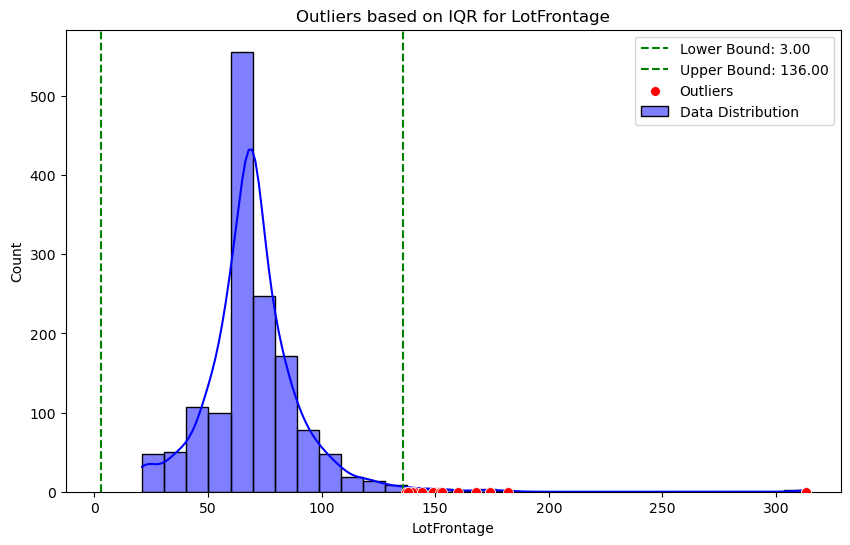


Column: LotArea
Outlier Values: [ 50271  31770  25419 159000  39104 215245 164660  53107  34650  70761
  53227  40094  32668  25095  46589  26178 115149  53504  28698  45600
  25286  27650  24090  25000  29959  35760  35133  32463  24682  36500
  63887  25339  57200  26142]


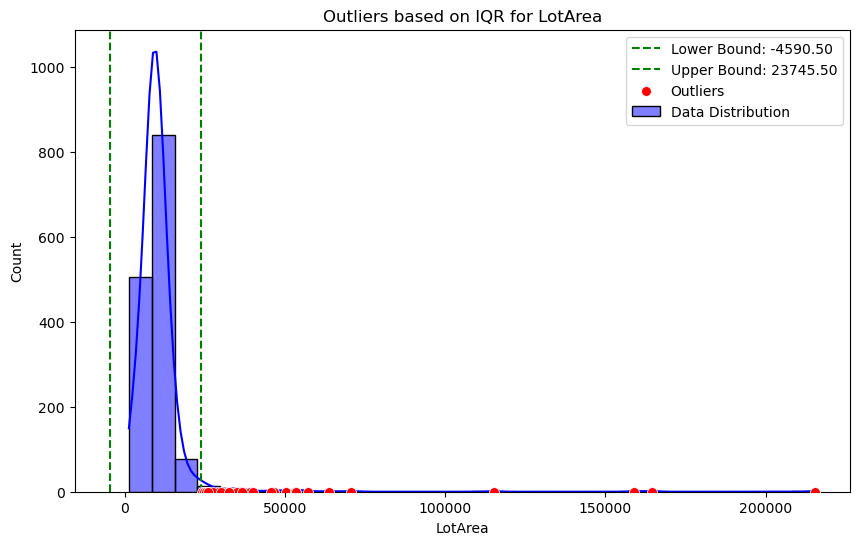


Column: MasVnrArea
Outlier Values: [1031. 1115.  768. 1129.  664.  748.  922. 1600.  870.  772.  921.  762.
  660. 1170.  894.  673.  860. 1047.  816.  760.  975.  660. 1378.  766.
  788.  796.  705.  731.]


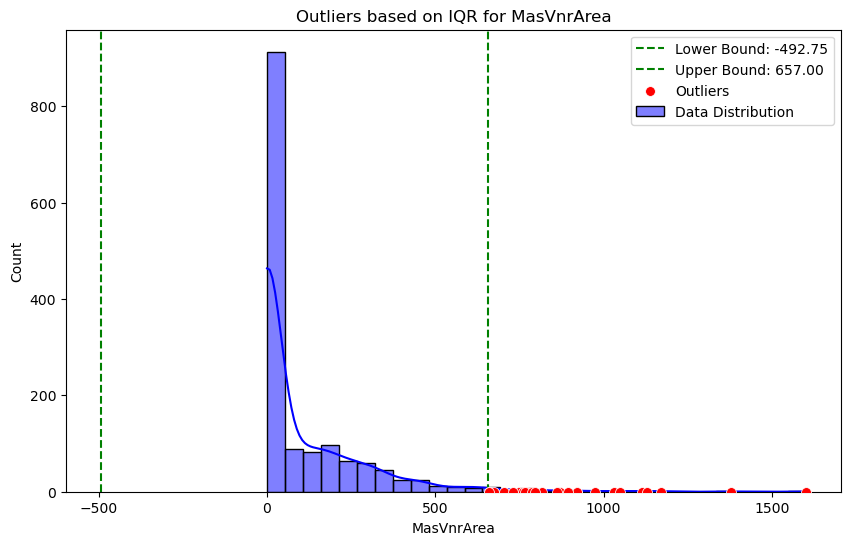


Column: BsmtFinSF1
Outlier Values: [5644]


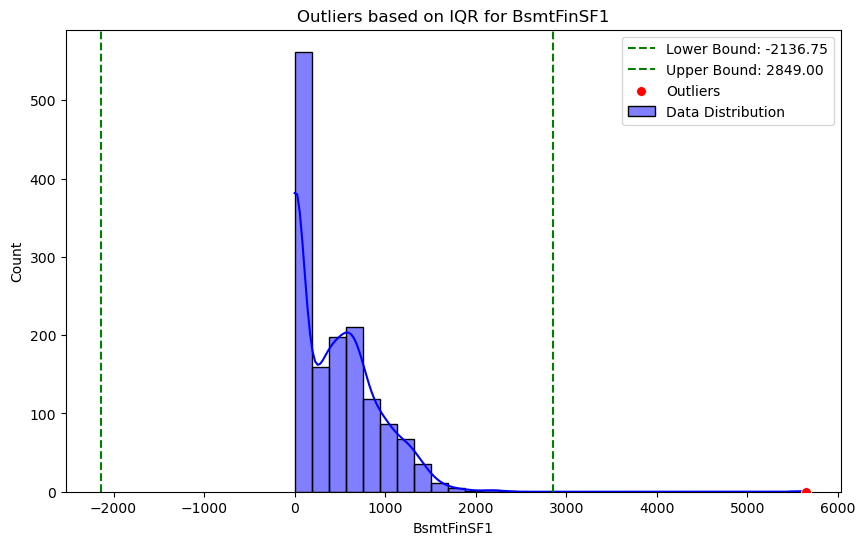


Column: BsmtFinSF2
Outlier Values: [  32  668  486   93  491  506  712  362   41  169  869  150  670   28
 1080  181  768  215  374  208  441  184  279  306  180  712  580  690
  692  228  125 1063  620  175  820 1474  264  479  147  232  380  544
  294  258  121  180  391  531  344  539  713  210  311 1120  165  532
  279   96  495  180  174 1127  139  202  645  123  551  219  606  147
  612  480  182  132  336  468  287   35  499  180  180  723  119  182
   40  551  117  239   80  472   64 1057  127  630  480  128  377  764
  345  539 1085  435  823  500  290  324  634  411  841 1061   93  466
  396  354  294  149  193  117  273  465  400  468   41  682   64  557
  230  106  791  240  287  547  391  469  177  108  374  600  492  211
  168   96 1031  438  375  144   81  906  608  276  661   68  173  972
  105  420  469  546  334  352  872  374  110  627  163 1029  290]


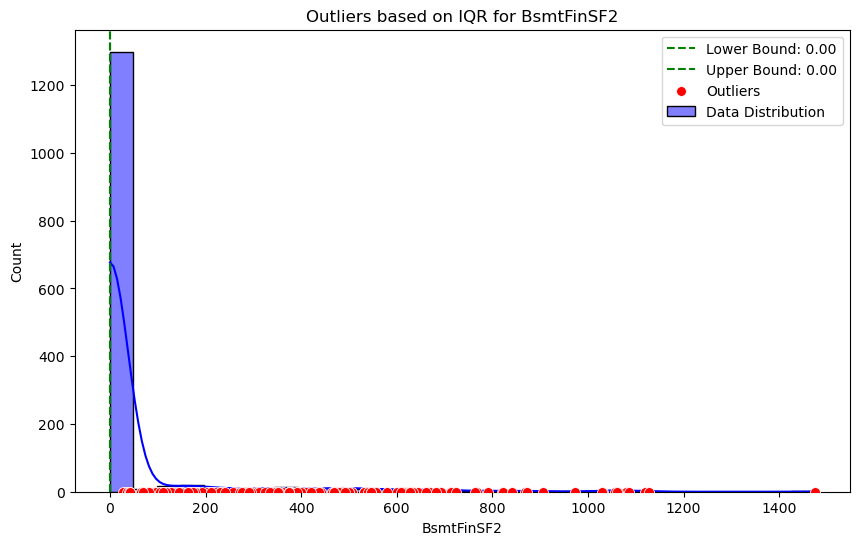


Column: TotalBsmtSF
Outlier Values: [3206 3094 3200 3138 6110]


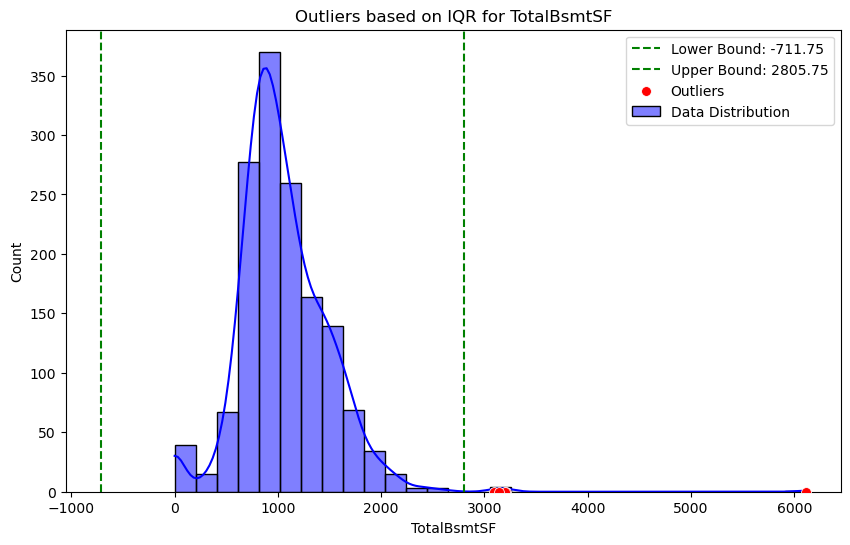


Column: 1stFlrSF
Outlier Values: [3228 3138 4692]


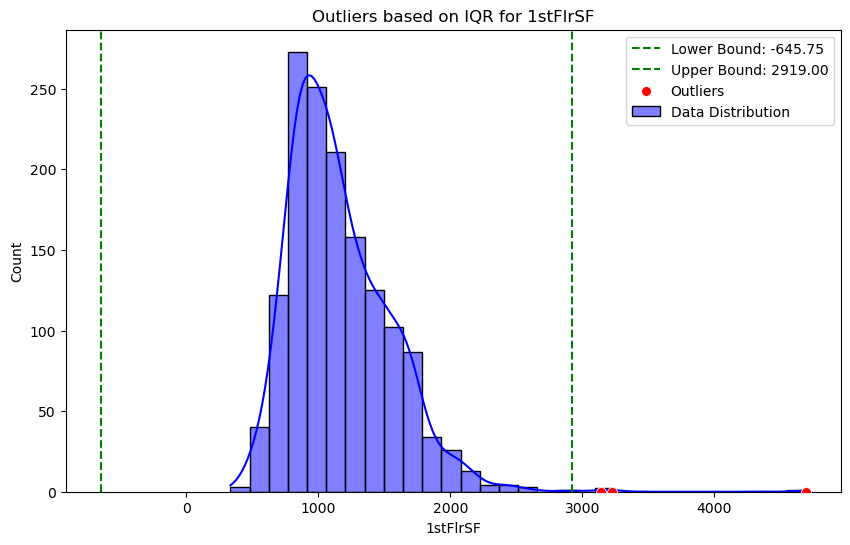


Column: LowQualFinSF
Outlier Values: [360 513 234 528 572 144 392 371 390 420 473 156 515 360  80  80  53 232
 481 120 514 397 479 205  80 384]


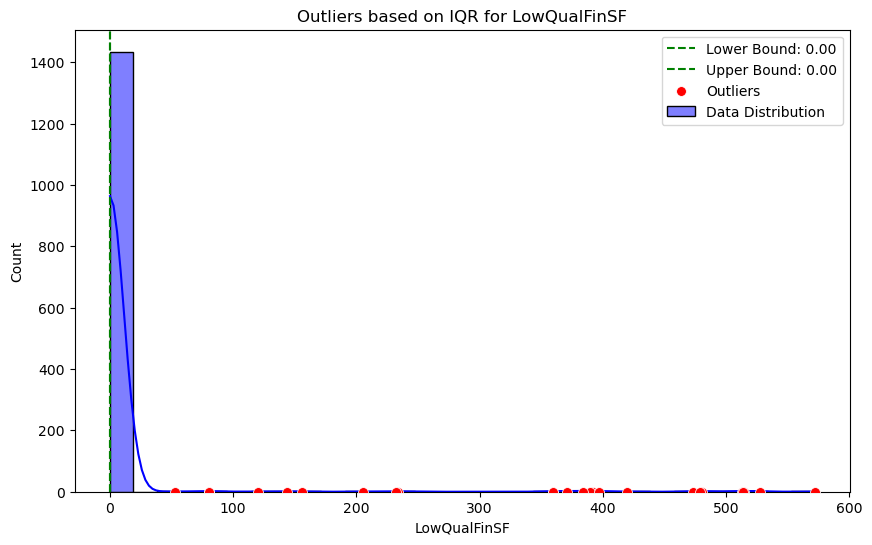


Column: GrLivArea
Outlier Values: [4676 4316 4476 5642]


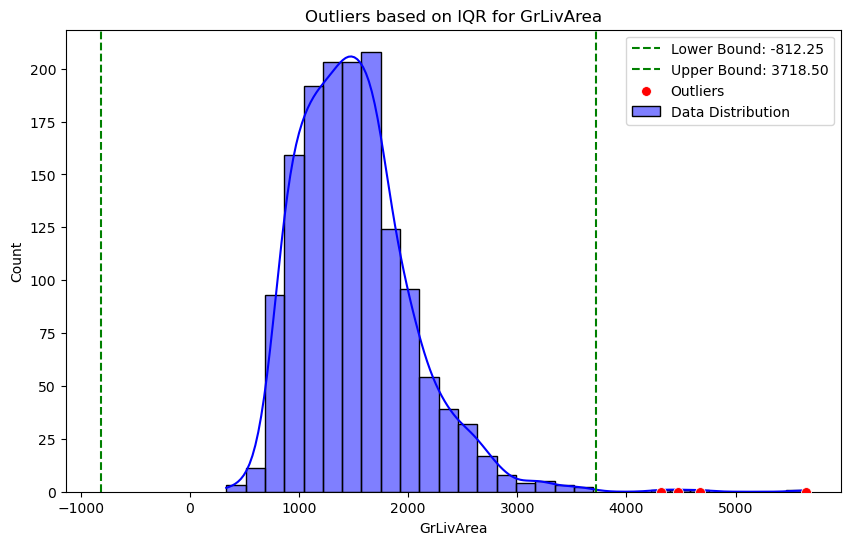


Column: BsmtHalfBath
Outlier Values: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]


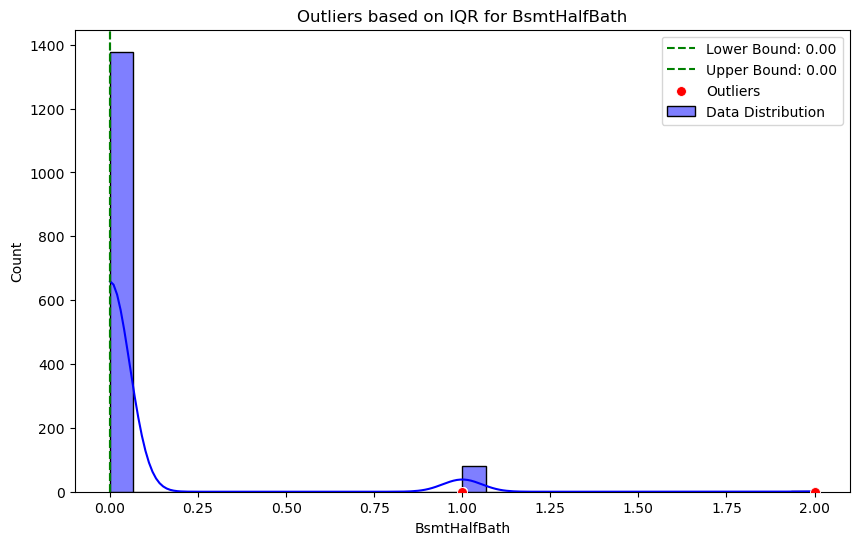


Column: BedroomAbvGr
Outlier Values: [8]


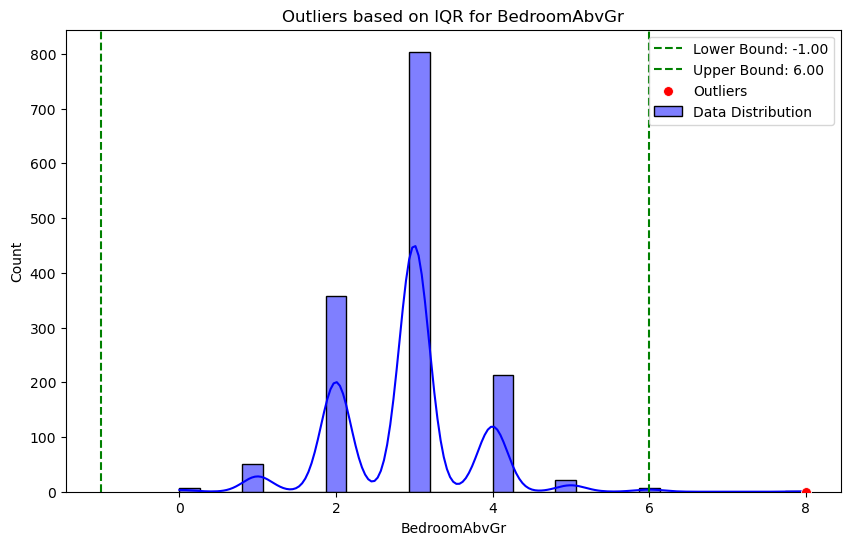


Column: KitchenAbvGr
Outlier Values: [2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2
 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


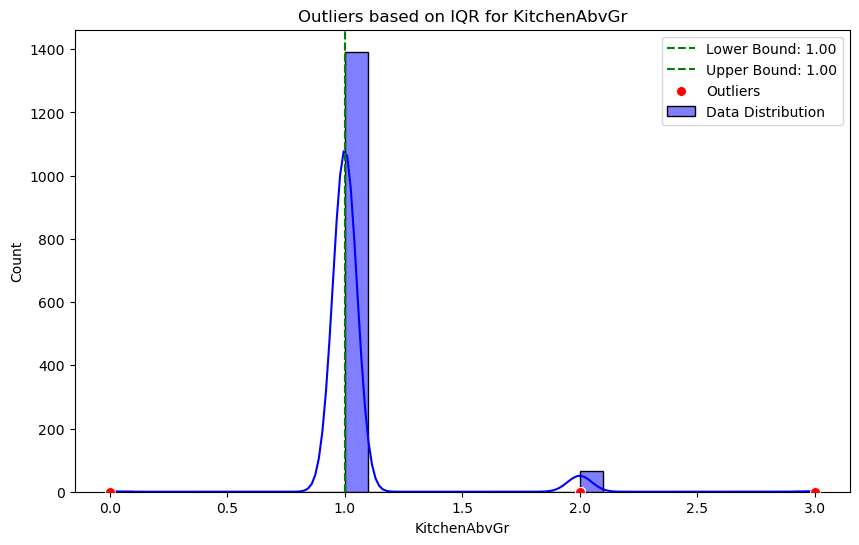


Column: TotRmsAbvGrd
Outlier Values: [14]


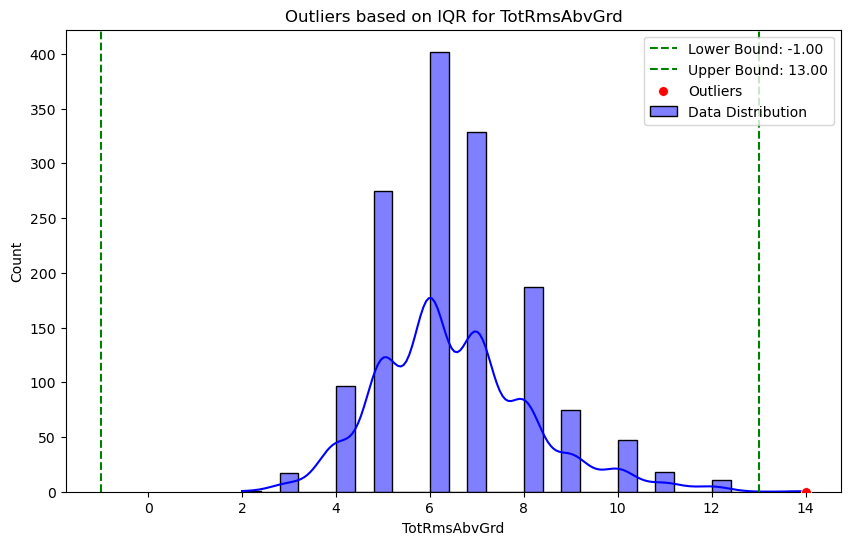


Column: GarageArea
Outlier Values: [1390 1356 1418]


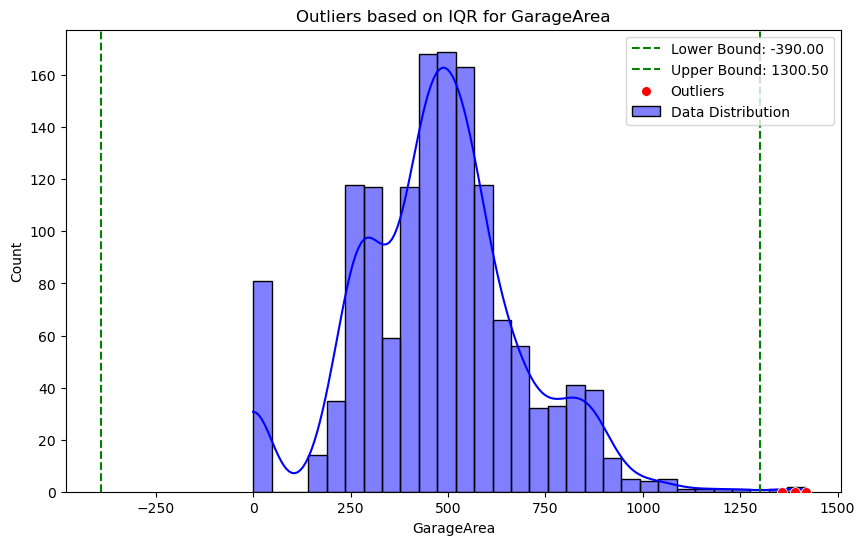


Column: WoodDeckSF
Outlier Values: [857 728 736]


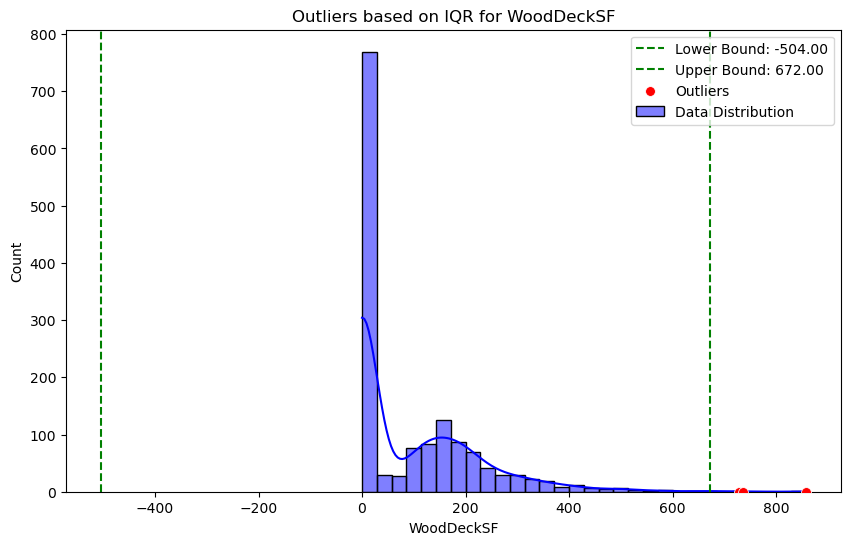


Column: OpenPorchSF
Outlier Values: [523 285 406 502 274 312 288 341 291 312 418 364 282 319 304 287 292 547]


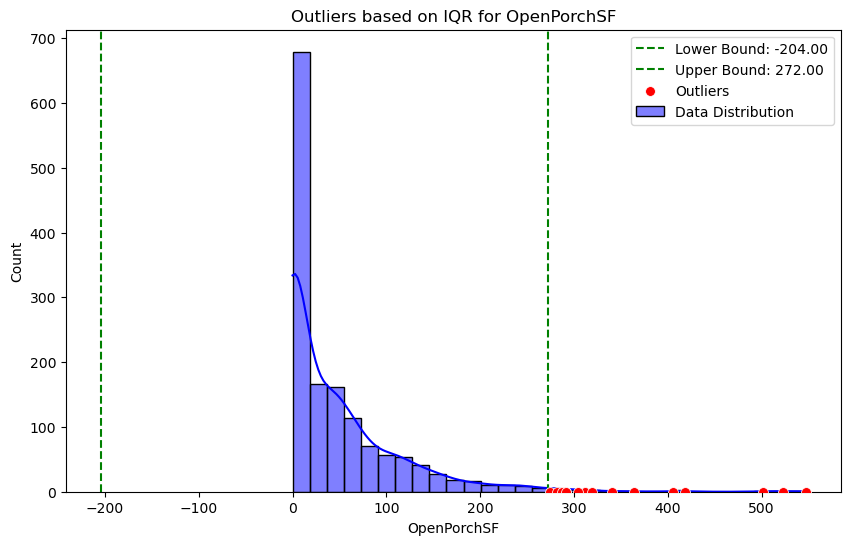


Column: EnclosedPorch
Outlier Values: [272 228 205 176 205  87 172 102  37 144  64 114 202 128 156  44  77 144
 192 144 140 180 228 128 183  39 184  40 552  30 126  96  60 150 120 202
  77 112 252  52 224 234 144 244 268 137  24 108 294 177 218 242  91 112
 160 130 184 126 169 105  34  96 248 236 120  32  80 115 291 184 116 158
 112 210  36 156 144 200  84 148 116 120 136 102 240  54 112  39 100  36
 189 293 164  40 216 239 112 252 240 180  67  90 120  56 112 129  40  98
 143 216 234 112 112  70 386 154 185 156 156 134 196 264 185 275  96 120
 112 116 230 254  68 194 192  34 150 164 112 224  32 318 244  48  94 138
 108 112 226 192 174 228  19 170 220 128  80 115 137 192 252 112  96 176
 216 176 214 280  96 116 102 190 236 192  84 330 208 145 259 126 264  81
 164  42 123 162 100 286 190 168  20 301 198  96 221 112 212  50 150 168
 112 160 114 216 154  99 158 216 252 112]


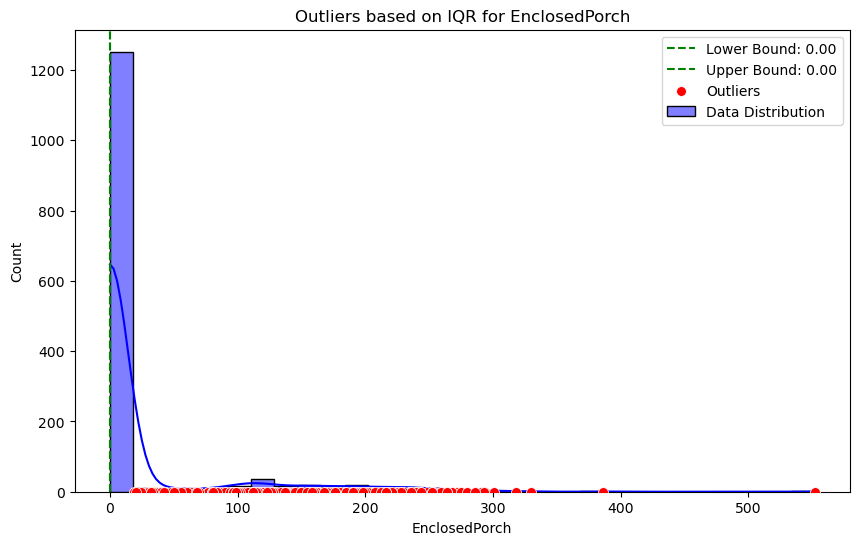


Column: 3SsnPorch
Outlier Values: [320 407 130 180 168 180 140 508 238 245 196 144 144 182 168 162  23 168
 216  96 216 153 290 304]


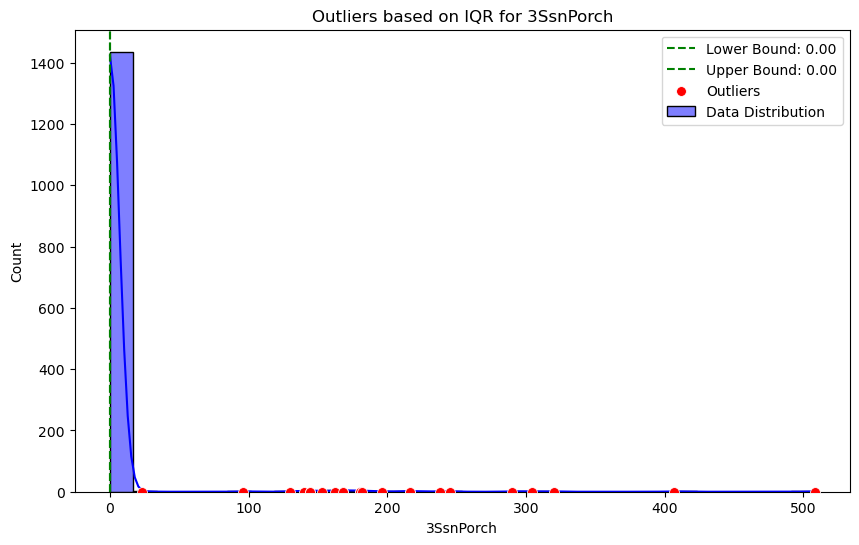


Column: ScreenPorch
Outlier Values: [176 198 291 252  99 184 168 130 142 192 410 224 266 170 154 153 144 142
 128 259 160 198 271 234 184 374 192 185 182  90 144 224 396 170 176 140
 276 192 180 161 168 145 200 122  95 144 120  60 120 126 189 260 147 385
 287 200 156 100 180 216 210 197 204 192 225 192 152 175 126 312 222 265
 224 322 120 190 233  63 147 180  53 143 189 189 189 192 160 160 126 100
 273 180  90 288 263 224 147 120  80 163  90 288 116 259 224 216 480 120
 178 440 155 168 220 119 165  40]


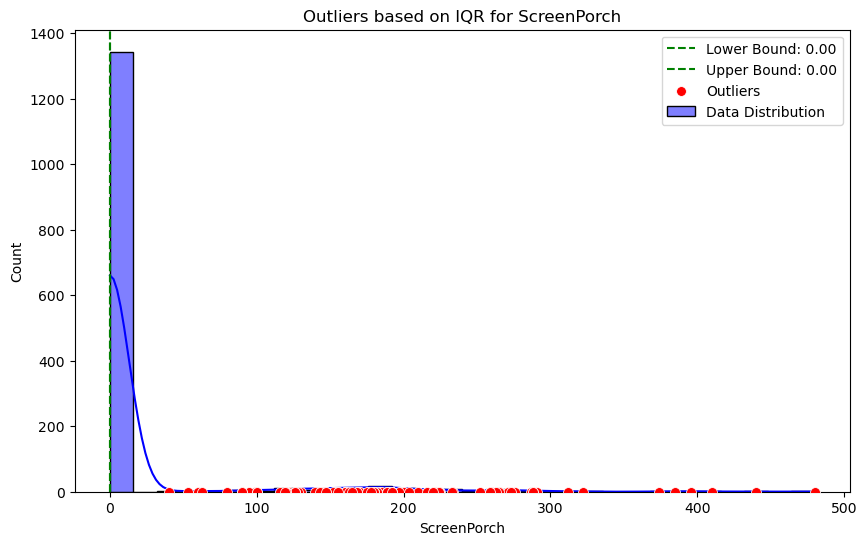


Column: PoolArea
Outlier Values: [512 648 576 555 480 519 738]


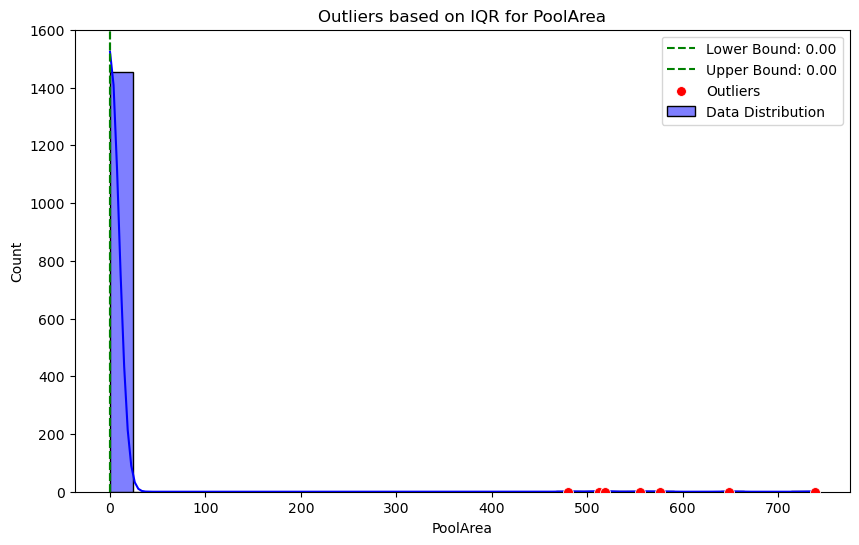


Column: MiscVal
Outlier Values: [  700   350   700   500   400   700   480   400   400   450   450   500
   450   700   400 15500  1200   800   480   400  2000  2000   600   500
   600   600  3500   500   400   450   500  1300  1200   500   400    54
   500   400   400  2000   620   400   560   500   700  1400   400  8300
   600  1150  2000  2500]


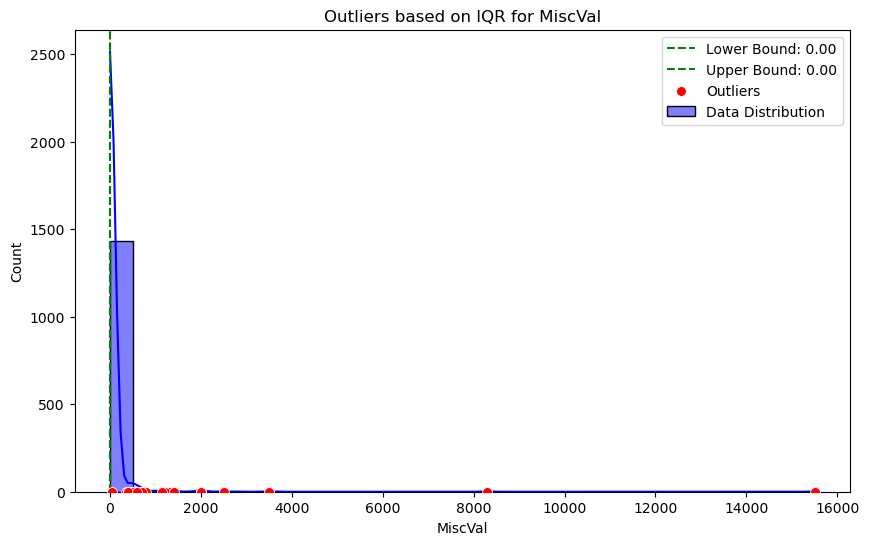

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def detect_and_visualize_outliers_iqr(df, data_description_dict):
    for field in df.columns:
        # Check if the feature type is 'continuous' in data_description_dict
        if data_description_dict.get(field, {}).get('Feature Type') == 'continuous':
            
            # Calculate Q1 (25th percentile) and Q3 (75th percentile)
            Q1 = df[field].quantile(0.25)
            Q3 = df[field].quantile(0.75)
            IQR = Q3 - Q1
            
            # Calculate the bounds for outliers
            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR
            
            # Identify outliers
            outliers = df[(df[field] < lower_bound) | (df[field] > upper_bound)]
            
            if len(outliers) > 0:
                print(f"\nColumn: {field}")
                print(f"Outlier Values: {outliers[field].values}")
                
                # Plot the distribution of the data
                plt.figure(figsize=(10, 6))
                
                # Plot histogram with KDE for data distribution
                sns.histplot(df[field], kde=True, color='blue', label='Data Distribution', bins=30)
                
                # Plot the bounds for IQR
                plt.axvline(lower_bound, color='green', linestyle='dashed', label=f'Lower Bound: {lower_bound:.2f}')
                plt.axvline(upper_bound, color='green', linestyle='dashed', label=f'Upper Bound: {upper_bound:.2f}')
                
                # Highlight the outliers in red
                sns.scatterplot(x=outliers[field], y=np.zeros_like(outliers[field]), color='red', s=50, label='Outliers', zorder=5)
                
                # Add title and labels
                plt.title(f"Outliers based on IQR for {field}")
                plt.xlabel(f"{field}")
                plt.ylabel("Count")
                plt.legend()
                
                # Show the plot
                plt.show()

# Example usage:
# Assuming df is your DataFrame and data_description_dict contains the feature types
detect_and_visualize_outliers_iqr(df, data_description_dict)


todo:
I dont know how to handle outliers and whether is makes a real difference at the end

Highly Skewed Features:
{'LotFrontage': 2.4091466665496006, 'LotArea': 12.207687851233496, 'MasVnrArea': 2.6776164510820997, 'BsmtFinSF1': 1.685503071910789, 'BsmtFinSF2': 4.255261108933303, 'TotalBsmtSF': 1.5242545490627664, '1stFlrSF': 1.3767566220336365, 'LowQualFinSF': 9.011341288465387, 'GrLivArea': 1.3665603560164552, 'BsmtHalfBath': 4.103402697955168, 'WoodDeckSF': 1.5413757571931312, 'OpenPorchSF': 2.3643417403694404, 'EnclosedPorch': 3.08987190371177, '3SsnPorch': 10.304342032693112, 'ScreenPorch': 4.122213743143115, 'PoolArea': 14.828373640750588, 'MiscVal': 24.476794188821916, 'KitchenAbvGr': 4.488396777072859}
LotFrontage: Skewness = 2.41


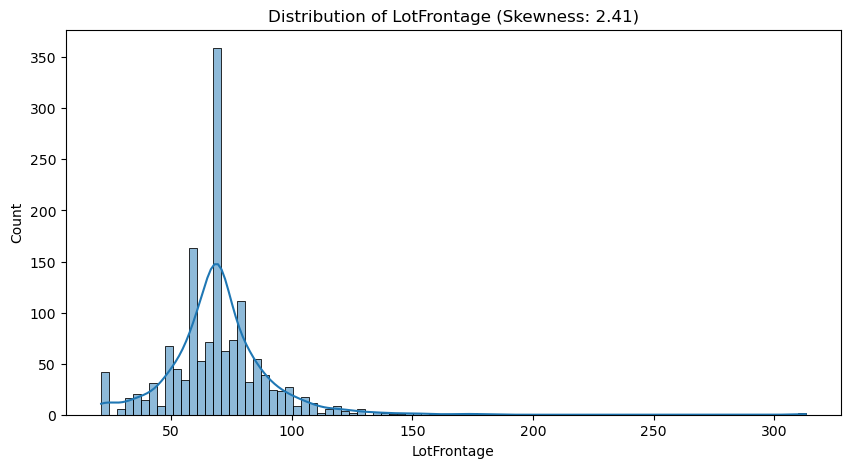

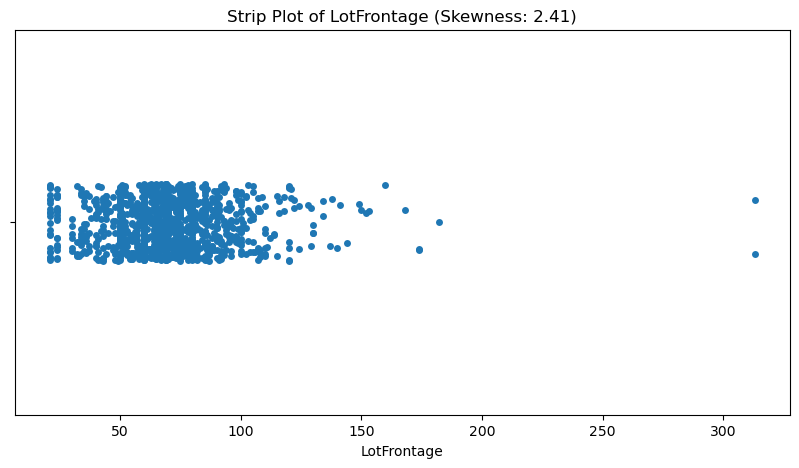

LotArea: Skewness = 12.21


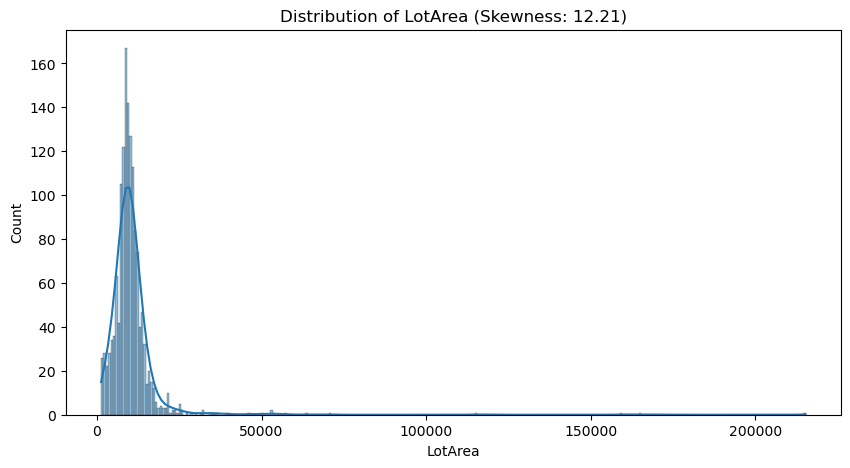

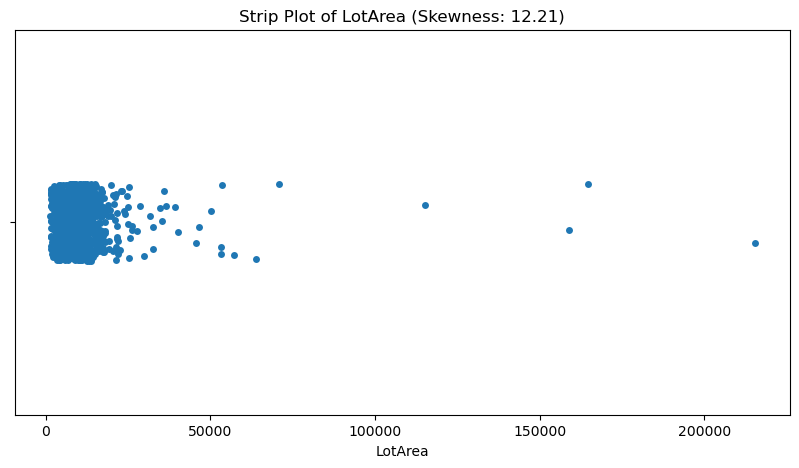

MasVnrArea: Skewness = 2.68


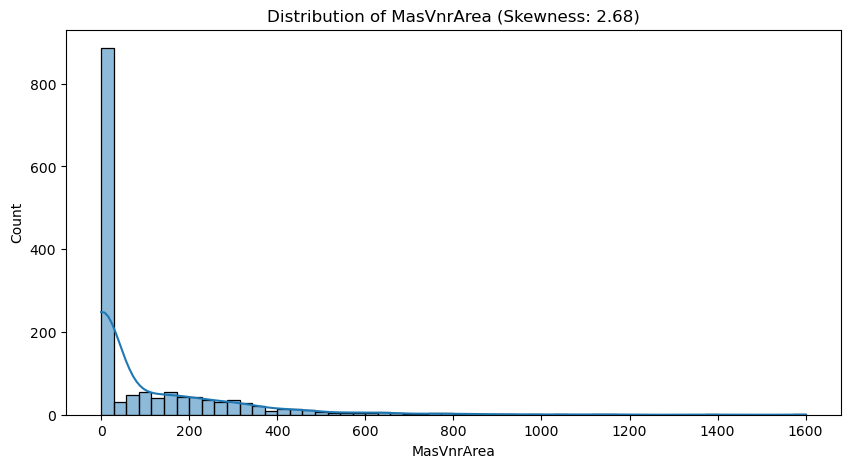

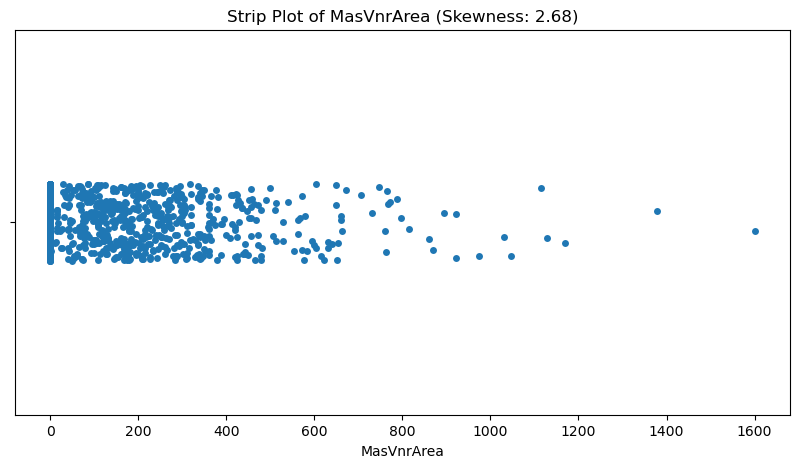

BsmtFinSF1: Skewness = 1.69


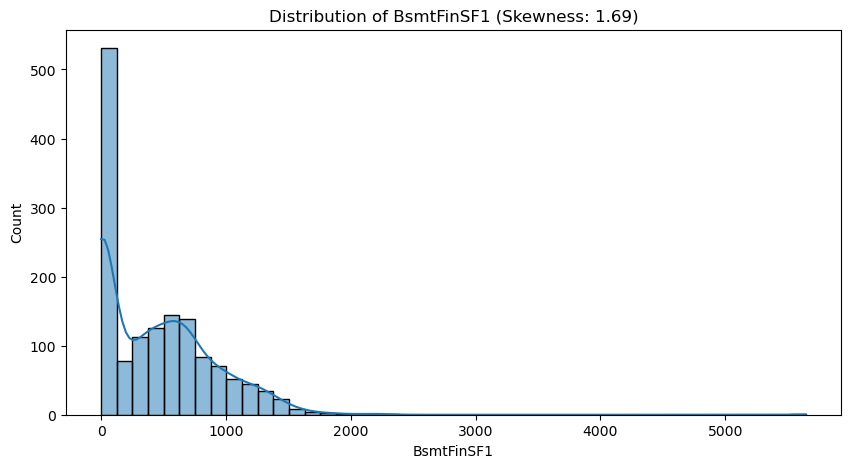

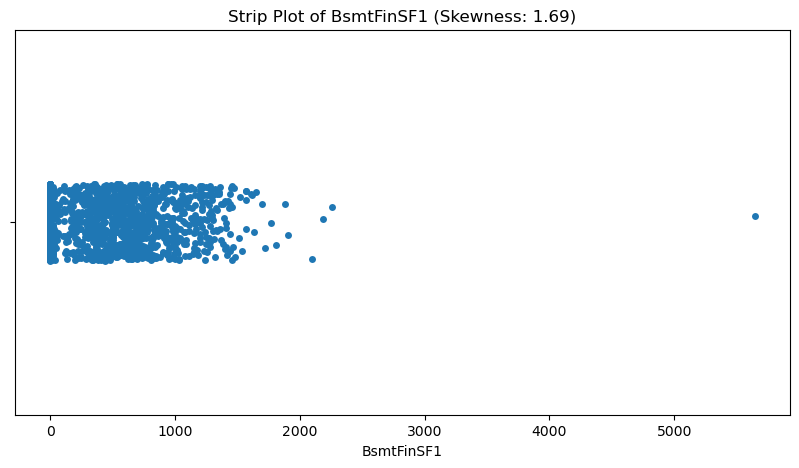

BsmtFinSF2: Skewness = 4.26


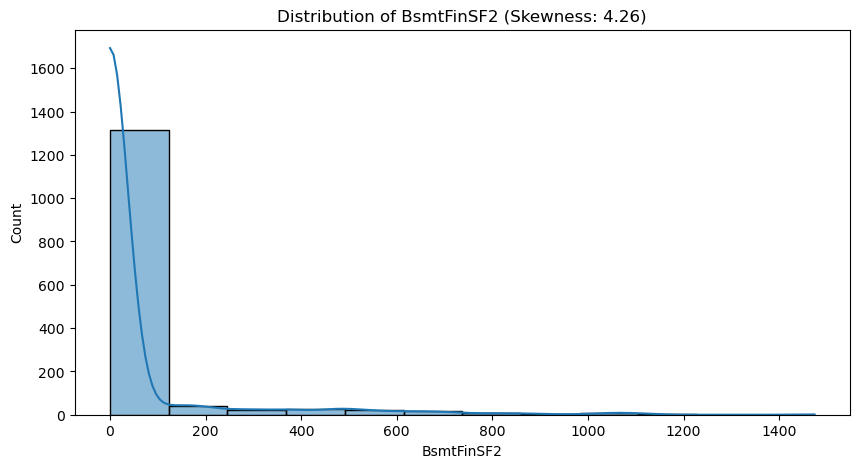

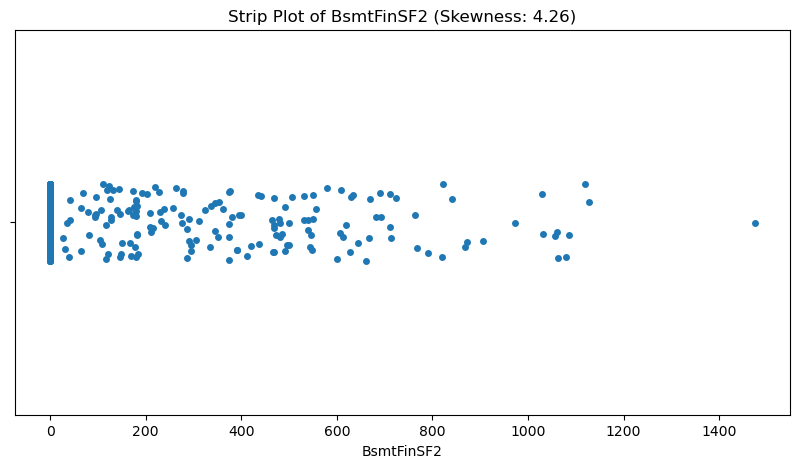

TotalBsmtSF: Skewness = 1.52


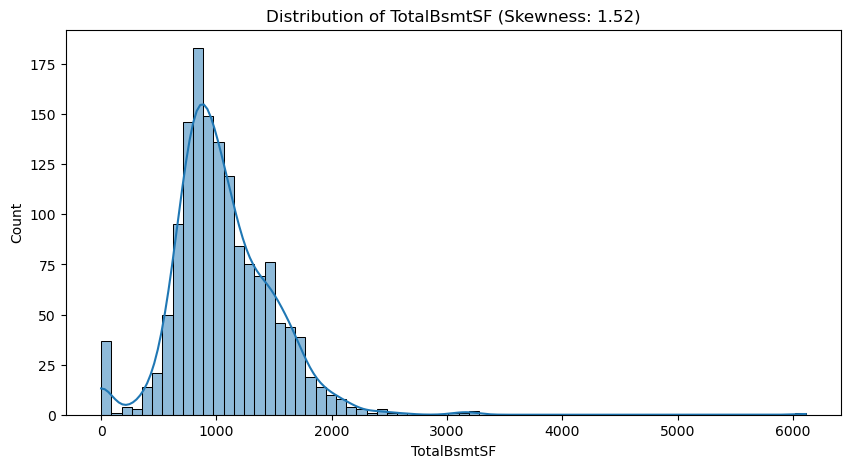

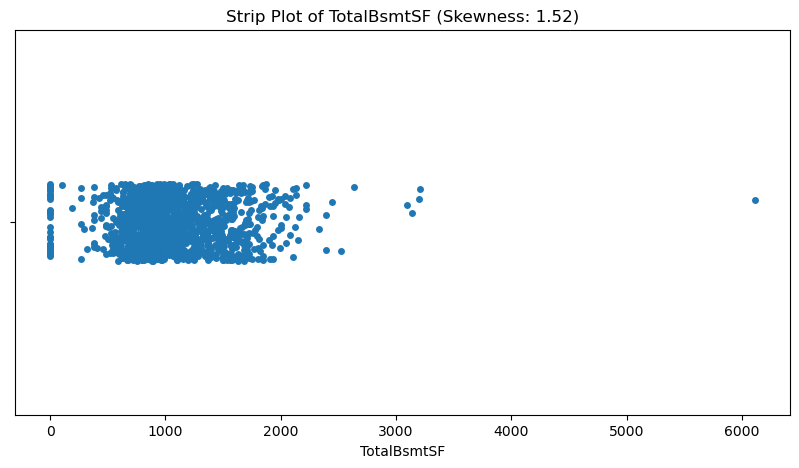

1stFlrSF: Skewness = 1.38


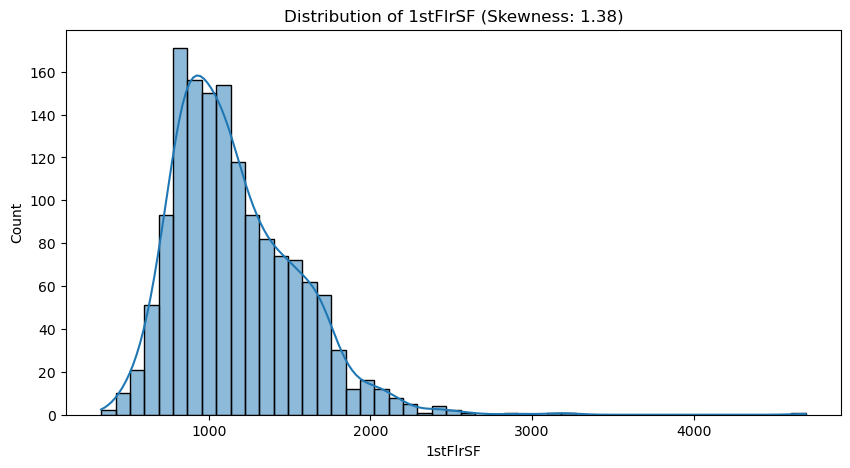

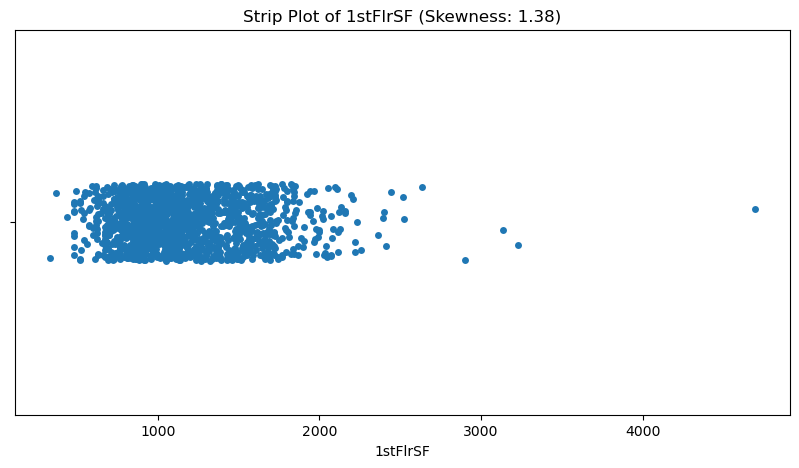

LowQualFinSF: Skewness = 9.01


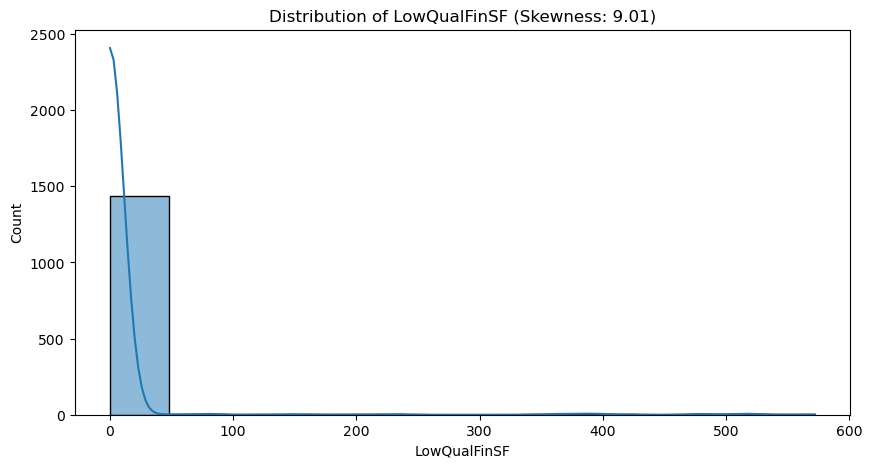

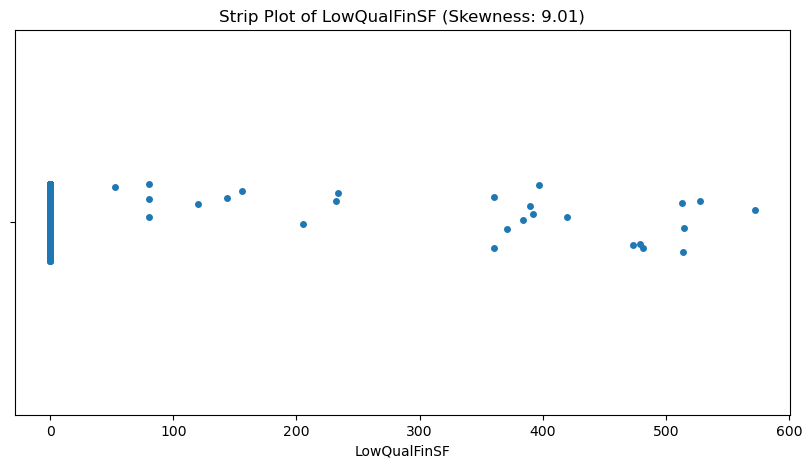

GrLivArea: Skewness = 1.37


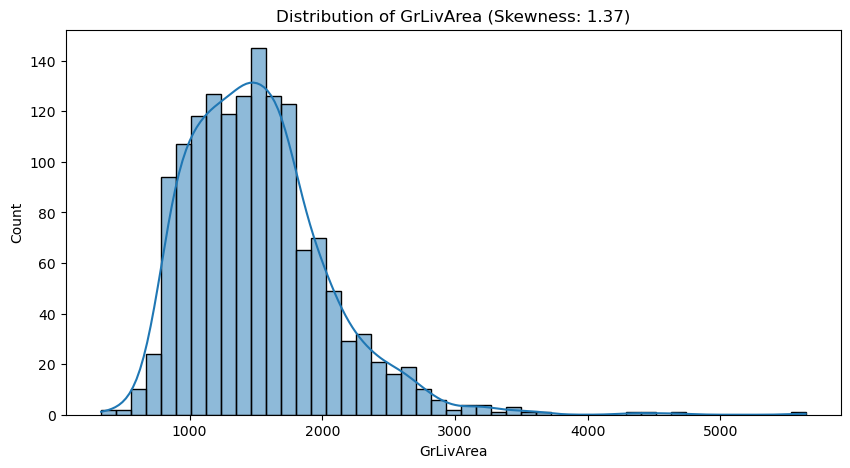

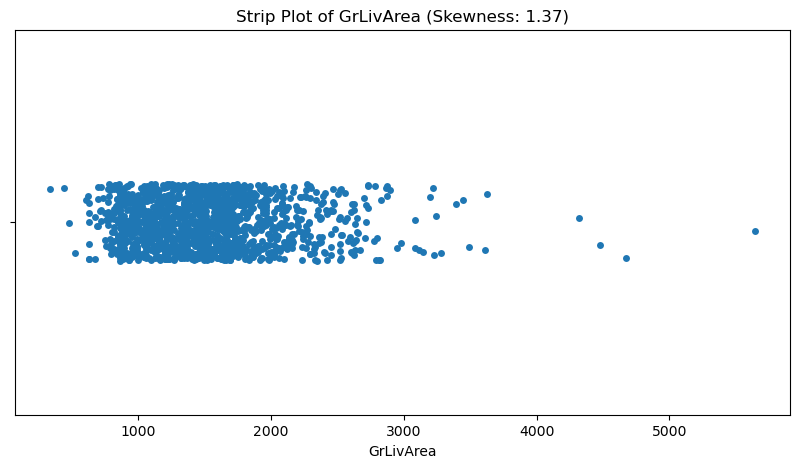

BsmtHalfBath: Skewness = 4.10


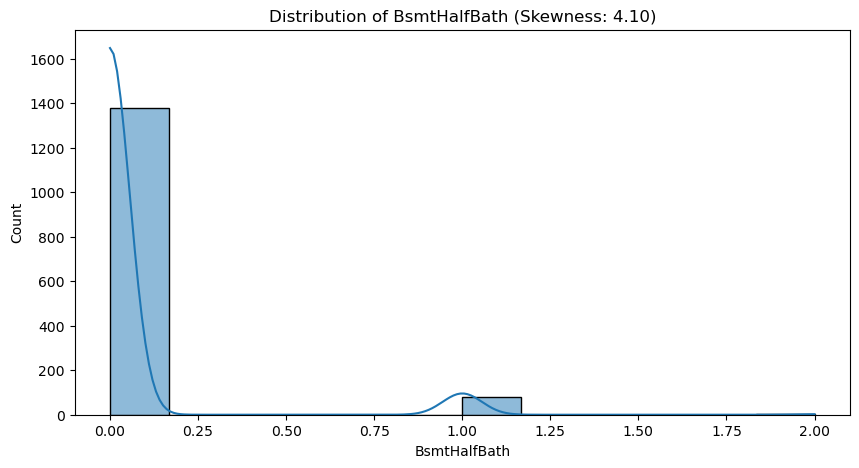

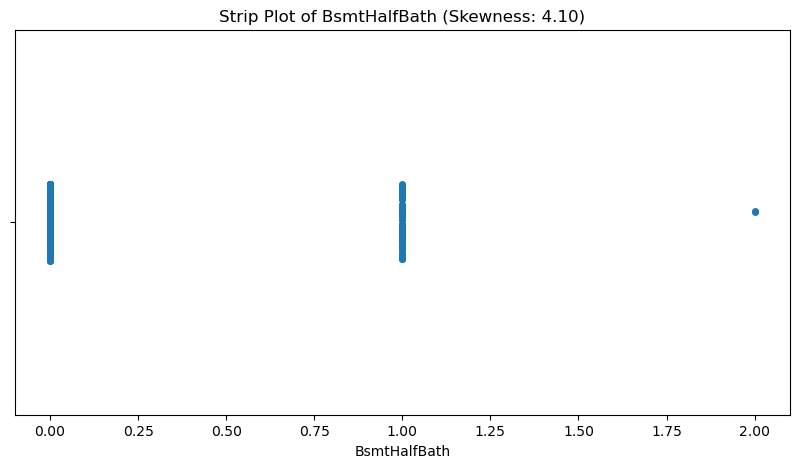

WoodDeckSF: Skewness = 1.54


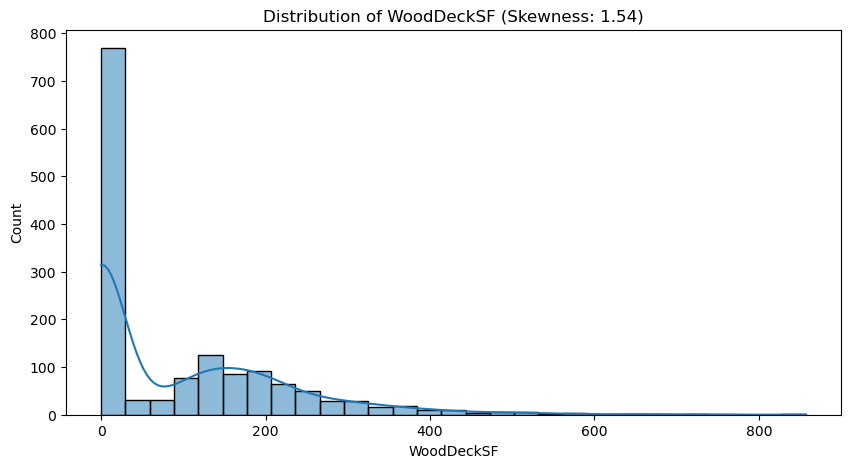

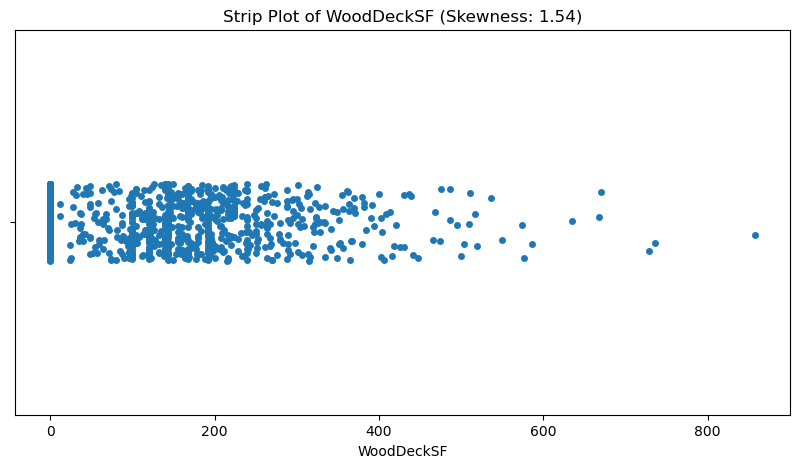

OpenPorchSF: Skewness = 2.36


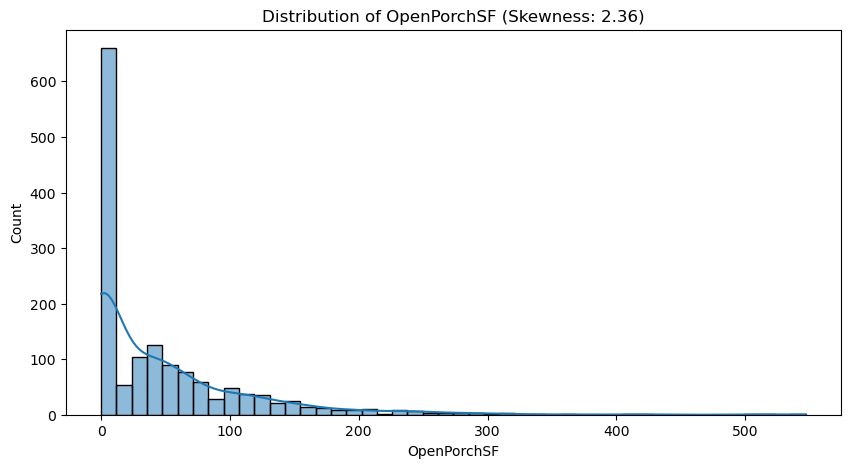

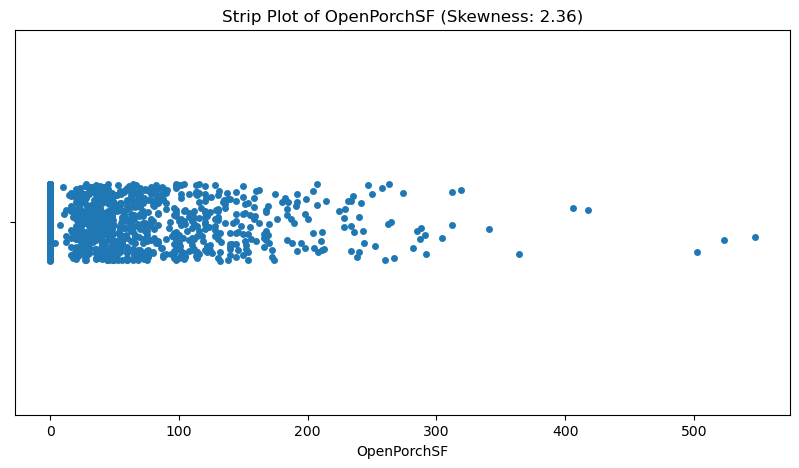

EnclosedPorch: Skewness = 3.09


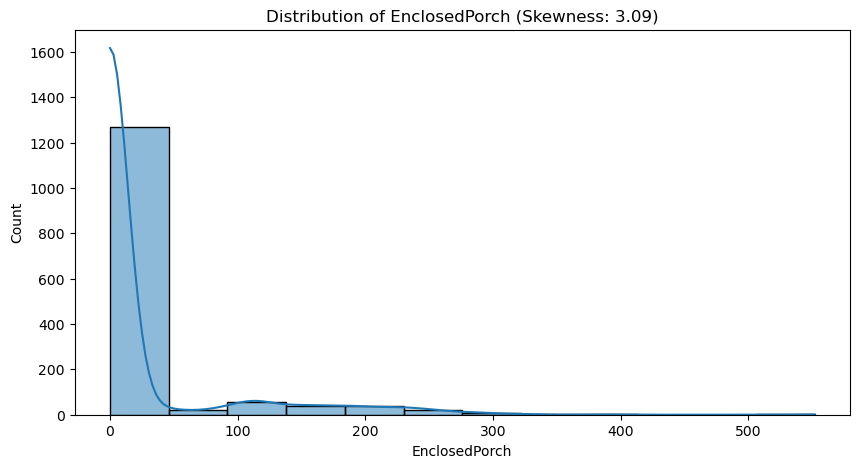

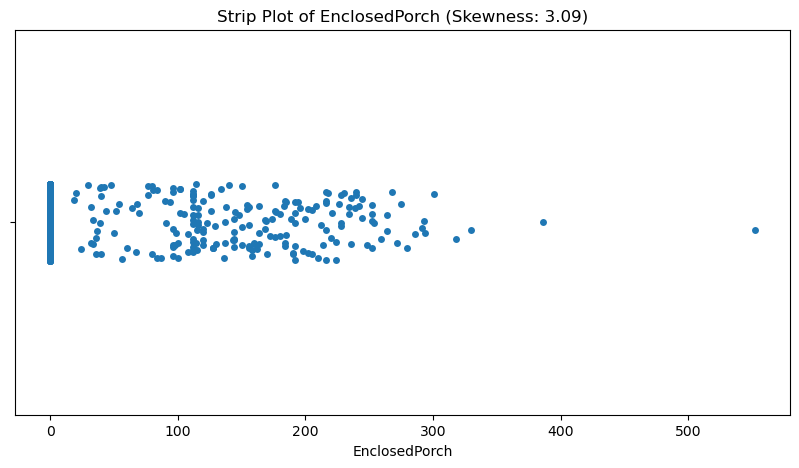

3SsnPorch: Skewness = 10.30


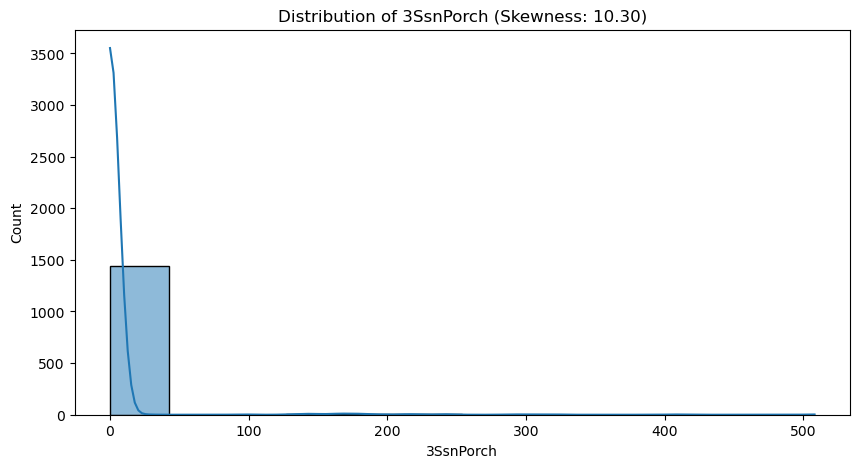

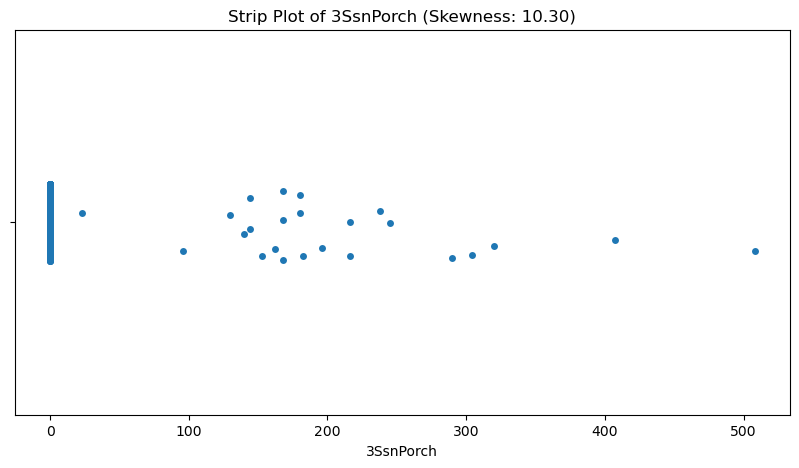

ScreenPorch: Skewness = 4.12


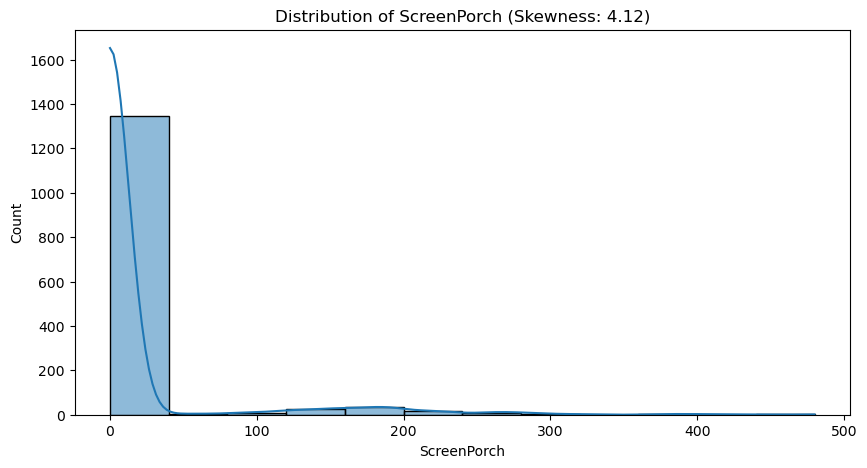

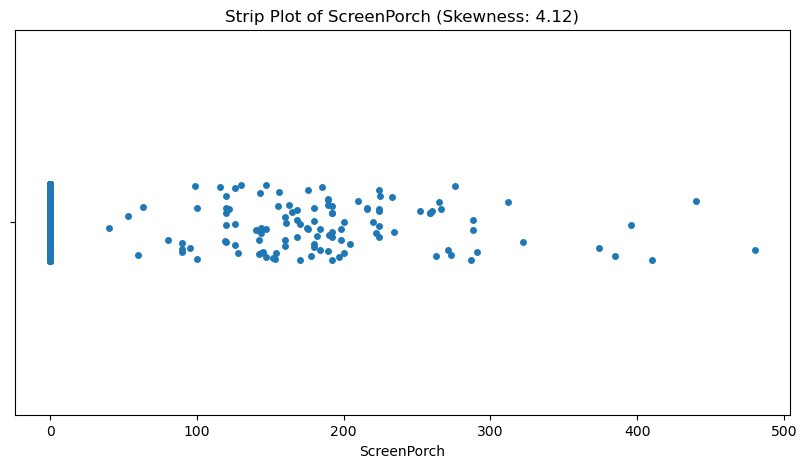

PoolArea: Skewness = 14.83


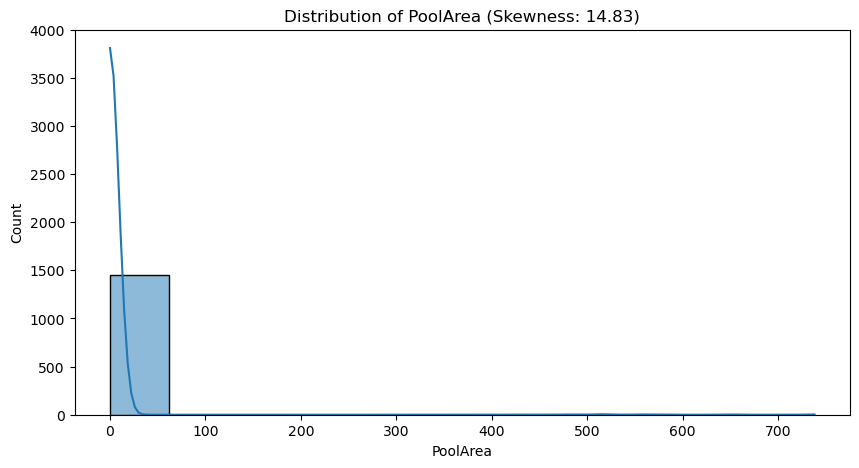

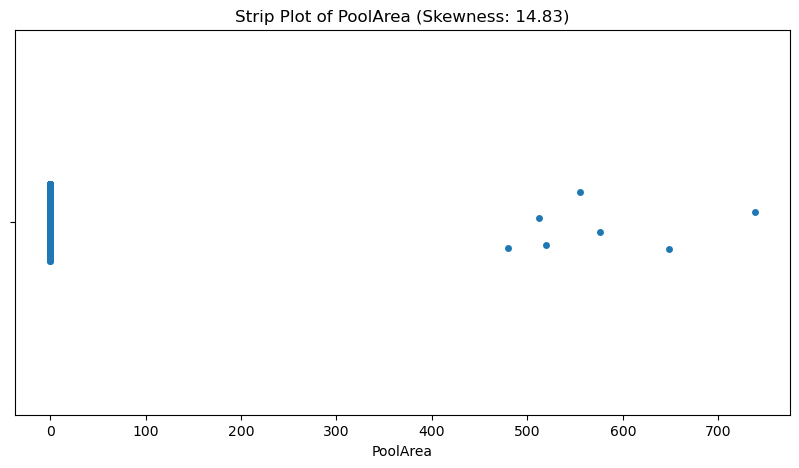

MiscVal: Skewness = 24.48


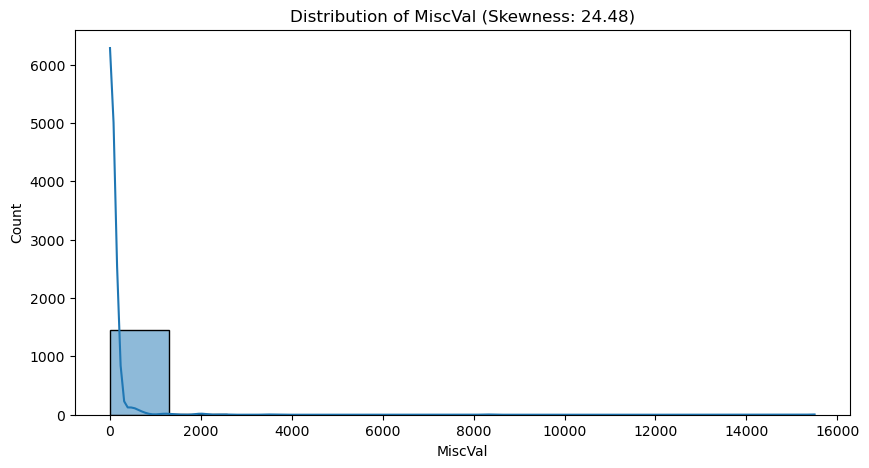

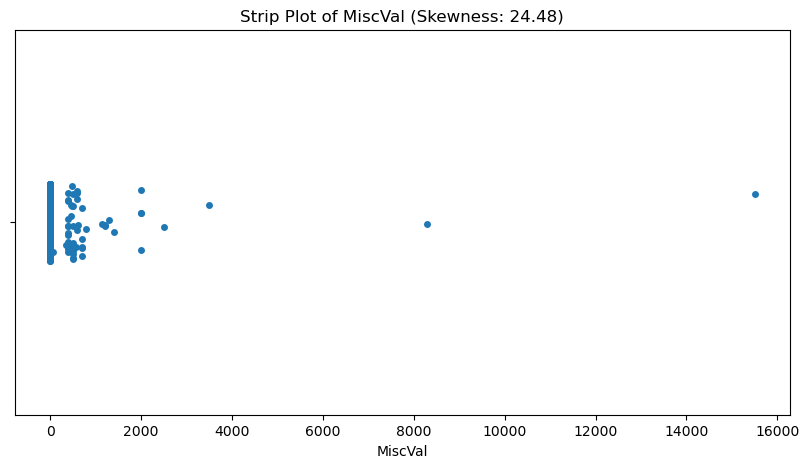

KitchenAbvGr: Skewness = 4.49


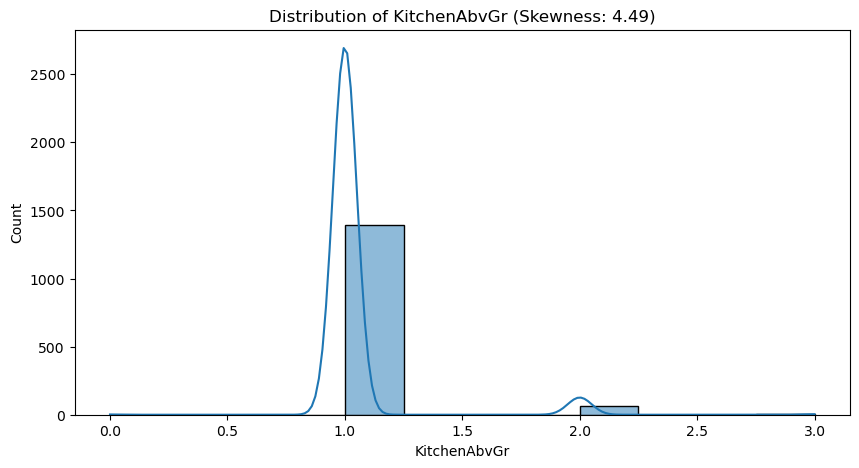

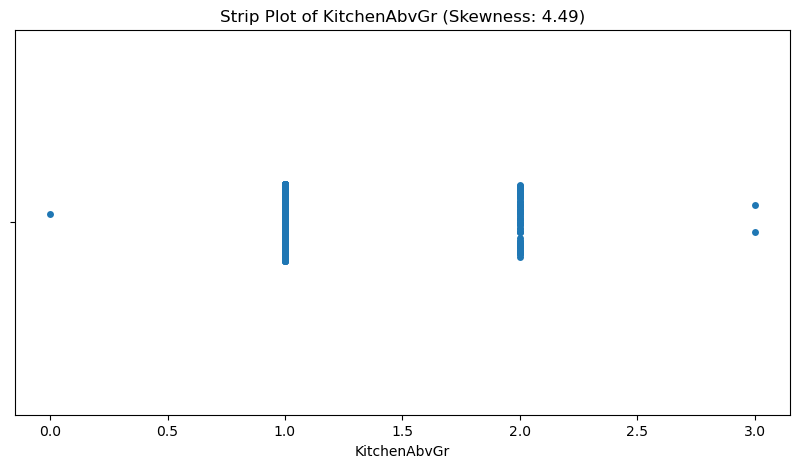

In [37]:
#to find highly skewed features

# Set skewness threshold for identifying highly skewed features
skew_threshold = 1

# List of continuous features (you might get these from your data_description_dict)
continuous_features = [col for col, data in data_description_dict.items() if data['Feature Type'] == 'continuous']

# Dictionary to store skewness values for each continuous feature
skewed_features = {}

# Calculate skewness and identify highly skewed features
for feature in continuous_features:
    skewness = df[feature].skew()
    if abs(skewness) > skew_threshold:
        skewed_features[feature] = skewness

# Display skewed features
print("Highly Skewed Features:")
print(skewed_features)
for feature, skewness in skewed_features.items():
    print(f"{feature}: Skewness = {skewness:.2f}")

    # Plot histogram and KDE for each highly skewed feature
    plt.figure(figsize=(10, 5))
    sns.histplot(df[feature], kde=True)
    plt.title(f"Distribution of {feature} (Skewness: {skewness:.2f})")
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.stripplot(x=df[feature], jitter=True)
    plt.title(f"Strip Plot of {feature} (Skewness: {skewness:.2f})")
    plt.xlabel(feature)
    plt.show()


## feature impact
find the most important features, insights...

In [36]:
print(list(df['LotFrontage']))

[65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, 69.0, 51.0, 50.0, 70.0, 85.0, 69.0, 91.0, 69.0, 51.0, 69.0, 72.0, 66.0, 70.0, 101.0, 57.0, 75.0, 44.0, 69.0, 110.0, 60.0, 98.0, 47.0, 60.0, 50.0, 69.0, 85.0, 70.0, 60.0, 108.0, 112.0, 74.0, 68.0, 65.0, 84.0, 115.0, 69.0, 69.0, 70.0, 61.0, 48.0, 84.0, 33.0, 66.0, 69.0, 52.0, 110.0, 68.0, 60.0, 100.0, 24.0, 89.0, 66.0, 60.0, 63.0, 60.0, 44.0, 50.0, 69.0, 76.0, 69.0, 72.0, 47.0, 81.0, 95.0, 69.0, 74.0, 85.0, 60.0, 21.0, 69.0, 50.0, 72.0, 60.0, 100.0, 32.0, 78.0, 80.0, 69.0, 121.0, 122.0, 40.0, 105.0, 60.0, 60.0, 85.0, 80.0, 60.0, 69.0, 69.0, 78.0, 73.0, 85.0, 77.0, 69.0, 77.0, 64.0, 94.0, 69.0, 75.0, 60.0, 50.0, 85.0, 105.0, 75.0, 69.0, 77.0, 69.0, 61.0, 34.0, 69.0, 74.0, 90.0, 65.0, 69.0, 50.0, 75.0, 55.0, 48.0, 60.0, 69.0, 55.0, 69.0, 69.0, 88.0, 69.0, 75.0, 69.0, 78.0, 80.0, 69.0, 82.0, 73.0, 65.0, 70.0, 78.0, 71.0, 78.0, 70.0, 24.0, 51.0, 69.0, 63.0, 69.0, 120.0, 107.0, 69.0, 69.0, 84.0, 60.0, 60.0, 92.0, 100.0, 134.0, 69.0, 110.0, 95.0, 55.0

Dimension Reduction (should it be part of the EDA roadmap??): Feature engineering, such as log transformations or encoding, ensures that your features are represented in a way that is meaningful for the model. PCA, feature importance, and similar techniques work best when features are already in a form that the model can interpret.
For instance, scaling and encoding allow PCA to treat all features on a comparable scale, while transformations (like log for skewed data) reduce noise and make the features better suited for linear techniques.

## Standalone Purpose of EDA

EDA is used to:

1. **Understand the Data**: Helps you get a sense of the data, identify trends, patterns, and relationships between variables, and discover the overall structure.
2. **Identify Data Quality Issues**: Uncover missing data, outliers, or incorrect data types that need cleaning.
3. **Guide Feature Engineering**: Informs which features may need transformation, scaling, or encoding for machine learning models.
4. **Hypothesis Generation**: Helps formulate hypotheses about the data and develop insights that guide the rest of the analysis.
5. **Reporting Insights**: In some cases, especially in business analytics, EDA alone might be sufficient to answer key questions. If the data reveals insights, these can be reported without needing to build a predictive model.

---

## Next Steps After EDA (for ML Workflow)

After performing EDA, you typically move into the data preprocessing stage, which feeds directly into the machine learning pipeline. Here's an outline of the steps after EDA:

### 1. Data Preprocessing
This is where you clean and transform your data based on insights from EDA:

- **Handle Missing Data**: Impute missing values (e.g., mean, median, mode, or specific values) or remove rows/columns if necessary.
- **Outlier Treatment**: Handle outliers that can negatively impact model performance (e.g., remove or transform them).
- **Feature Scaling**: Normalize or standardize features, especially for algorithms sensitive to feature scaling (e.g., SVM, KNN).
- **Feature Encoding**: Convert categorical variables into numerical format (e.g., One-Hot Encoding, Label Encoding).
- **Feature Transformation**: Apply log, square root, or polynomial transformations to features if necessary (especially for skewed data).
- **Feature Engineering**: Create new features or modify existing ones based on domain knowledge or insights from EDA.

### 2. Feature Selection
Based on the results of EDA, you might decide to select or reduce features before feeding them into the model:

- **Filter Methods**: Use correlation matrices, variance thresholds, or statistical tests to identify irrelevant or redundant features.
- **Wrapper Methods**: Use techniques like recursive feature elimination (RFE) to select features.
- **Embedded Methods**: Use models like decision trees or Lasso (L1 regularization) that automatically select important features during training.

### 3. Splitting Data (Train/Test/Validation)
Split your dataset into training, validation, and test sets:

- **Training Set**: Used to train the machine learning model.
- **Validation Set**: Used for hyperparameter tuning and model evaluation during training.
- **Test Set**: A separate dataset to evaluate the final model's performance after training.

### 4. Model Selection
Select a few machine learning models based on the type of problem:

- **Classification**: Logistic regression, decision trees, random forests, support vector machines, etc.
- **Regression**: Linear regression, decision trees, random forests, XGBoost, etc.
- **Clustering**: K-means, hierarchical clustering, DBSCAN, etc.

### 5. Model Training
Train multiple models and compare performance:

- Use cross-validation to avoid overfitting and assess how well your model generalizes to unseen data.
- Fine-tune hyperparameters using techniques like grid search or random search.

### 6. Model Evaluation
Evaluate your models using appropriate metrics:

- **For Classification**: Accuracy, precision, recall, F1-score, AUC-ROC.
- **For Regression**: Mean squared error (MSE), root mean squared error (RMSE), R-squared.
- **For Clustering**: Silhouette score, Davies–Bouldin index.

### 7. Hyperparameter Tuning
Fine-tune your model’s hyperparameters using validation data:

- Use grid search, random search, or more advanced methods like Bayesian optimization to find the best combination of hyperparameters.

### 8. Final Model Selection and Testing
Evaluate the final model on the test set to get an estimate of its performance on unseen data.

### 9. Model Deployment
After selecting the best model, prepare it for deployment:

- Save the model (using `pickle`, `joblib`, etc.).
- Create an API or integrate it into a system for real-time or batch predictions.

### 10. Model Monitoring and Maintenance
After deployment, monitor the model’s performance over time to ensure it still meets performance requirements. Retrain as needed if model performance degrades (concept drift).

---

## Conclusion

While EDA can be a standalone process in some cases, its primary purpose in machine learning workflows is to prepare the data and gain insights that will guide the next steps in model building. The end goal is to clean, transform, and select the best features so that the machine learning algorithms can perform optimally.
